# Examining Impact Rating Results for a Specific Match

Looking at map 1 (de_mirage) of the following series between Mousesports and Faze:

**https://www.hltv.org/matches/2340866/mousesports-vs-faze-esl-one-road-to-rio-europe**

The VOD for this match can be viewed here: https://youtu.be/9X7KpyXN5P0

This particular game has be chosen because it highlights key features of the Impact Rating system - specifically round 5, where the CT side win a full-eco round.

**Note:** the Impact Rating values shown in this notebook may be slightly different to results generated from processing the same demo with the most recent prediction model.

In [1]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML, clear_output

import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import ipywidgets as widgets
import seaborn as sns
sns.set()

In [2]:
# ignore this code block - embedding json results into the notebook
data = json.loads('{"metadata": {"version": "0.6.0"},"roundsPlayed": 26,"players": [{"steamID": 76561197991272318,"name": "ropz","overallRating": {"averageRating": -0.05463859728766206,"ratingBreakdown": {"damageRating": 0.06285132783432101,"flashAssistRating": 0.0002274773045972266,"tradeDamageRating": 0.00893678983321168,"defuseRating": 0,"hurtRating": -0.12665419225979196}},"roundRatings": [{"round": 1,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 2,"totalRating": 0.1891013111276298,"ratingBreakdown": {"damageRating": 0.1891013111276298,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 3,"totalRating": 0.09970488289478582,"ratingBreakdown": {"damageRating": 0.18735332817442782,"flashAssistRating": 0,"tradeDamageRating": 0.14716638267589616,"defuseRating": 0,"hurtRating": -0.23481482795553815}},{"round": 4,"totalRating": -0.07250980596525336,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.07250980596525336}},{"round": 5,"totalRating": -0.09208841216542452,"ratingBreakdown": {"damageRating": 0.12067452201034956,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.21276293417577408}},{"round": 6,"totalRating": -0.1553812706121974,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.1553812706121974}},{"round": 7,"totalRating": 0.02126081335643805,"ratingBreakdown": {"damageRating": 0.02126081335643805,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 8,"totalRating": 0.22709373101427602,"ratingBreakdown": {"damageRating": 0.22709373101427602,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 9,"totalRating": -0.19633226853324132,"ratingBreakdown": {"damageRating": 0.07539590051577597,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2717281690490173}},{"round": 10,"totalRating": -0.13958143804024786,"ratingBreakdown": {"damageRating": 0.11106293094198058,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2506443689822284}},{"round": 11,"totalRating": -0.1376193727052135,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.1376193727052135}},{"round": 12,"totalRating": -0.22435384129758645,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.22435384129758645}},{"round": 13,"totalRating": -0.14322389273242497,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.14322389273242497}},{"round": 14,"totalRating": -0.1677237546814802,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.05922193177463414,"defuseRating": 0,"hurtRating": -0.22694568645611435}},{"round": 15,"totalRating": 0.2893275111829247,"ratingBreakdown": {"damageRating": 0.28947999228896426,"flashAssistRating": 0,"tradeDamageRating": 0.022366777921518248,"defuseRating": 0,"hurtRating": -0.022519259027557817}},{"round": 16,"totalRating": -0.13992880190621715,"ratingBreakdown": {"damageRating": 0.09186388864226136,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2317926905484785}},{"round": 17,"totalRating": -0.003979466123558904,"ratingBreakdown": {"damageRating": 0.0003864130621485877,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.004365879185707491}},{"round": 18,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 19,"totalRating": -0.1308820816106846,"ratingBreakdown": {"damageRating": 0.25920992723749253,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.39009200884817713}},{"round": 20,"totalRating": 0.020609399609634062,"ratingBreakdown": {"damageRating": 0.04411986202948894,"flashAssistRating": 0.005914409919527892,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.029424872339382777}},{"round": 21,"totalRating": -0.3653090374296725,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.3653090374296725}},{"round": 22,"totalRating": -0.016016647658077338,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.016016647658077338}},{"round": 23,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 24,"totalRating": -0.13912993364958748,"ratingBreakdown": {"damageRating": 0.017131903291112638,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.15626183694070012}},{"round": 25,"totalRating": -0.0416109870847825,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.0416109870847825}},{"round": 26,"totalRating": -0.10203016646925207,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.0036014432914551475,"defuseRating": 0,"hurtRating": -0.10563160976070722}}]},{"steamID": 76561198201620490,"name": "broky","overallRating": {"averageRating": 0.010775300558804792,"ratingBreakdown": {"damageRating": 0.09998923095525808,"flashAssistRating": 0.012364808378765687,"tradeDamageRating": 0.01821314436310645,"defuseRating": 0,"hurtRating": -0.11979188313832542}},"roundRatings": [{"round": 1,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 2,"totalRating": -0.12084709771647367,"ratingBreakdown": {"damageRating": 0.2824809598301984,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.40332805754667206}},{"round": 3,"totalRating": 0.1089969819875557,"ratingBreakdown": {"damageRating": 0.2645664815669029,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.15556949957934718}},{"round": 4,"totalRating": 0.09781730770013553,"ratingBreakdown": {"damageRating": 0.0020322508302357822,"flashAssistRating": 0.09598673665222174,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.00020167978232199513}},{"round": 5,"totalRating": -0.2630350333657932,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2630350333657932}},{"round": 6,"totalRating": -0.15269381586221842,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.15269381586221842}},{"round": 7,"totalRating": -0.0033690823963322797,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.0033690823963322797}},{"round": 8,"totalRating": -0.04558193998800582,"ratingBreakdown": {"damageRating": 0.04588670545234026,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.09146864544034608}},{"round": 9,"totalRating": -0.09602867568555612,"ratingBreakdown": {"damageRating": 0.06084723443816149,"flashAssistRating": 0,"tradeDamageRating": 0.035290648975671024,"defuseRating": 0,"hurtRating": -0.19216655909938862}},{"round": 10,"totalRating": -0.07810708630431787,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.0444872958828521,"defuseRating": 0,"hurtRating": -0.12259438218716996}},{"round": 11,"totalRating": -0.38399239030402366,"ratingBreakdown": {"damageRating": 0.2948365559876106,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.6788289462916341}},{"round": 12,"totalRating": 0.22662503209489746,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0.22662503209489746,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 13,"totalRating": -0.027742518497113178,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.16738926704748458,"defuseRating": 0,"hurtRating": -0.19513178554459776}},{"round": 14,"totalRating": 0.1848390779308461,"ratingBreakdown": {"damageRating": 0.238781633710411,"flashAssistRating": -0.053942555779564895,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 15,"totalRating": -0.16584587641294335,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.16584587641294335}},{"round": 16,"totalRating": 0.24162326626733543,"ratingBreakdown": {"damageRating": 0.3229503096318912,"flashAssistRating": 0,"tradeDamageRating": 0.0733373442943553,"defuseRating": 0,"hurtRating": -0.15466438765891105}},{"round": 17,"totalRating": 0.019012614406551533,"ratingBreakdown": {"damageRating": 0.019012614406551533,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 18,"totalRating": 0.010424097413348266,"ratingBreakdown": {"damageRating": 0.25569783054025597,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2452737331269077}},{"round": 19,"totalRating": 0.14746183021193535,"ratingBreakdown": {"damageRating": 0.14746183021193535,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 20,"totalRating": 0.03758741650648967,"ratingBreakdown": {"damageRating": 0.03758741650648967,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 21,"totalRating": 0.276909706258866,"ratingBreakdown": {"damageRating": 0.17324043941115552,"flashAssistRating": 0,"tradeDamageRating": 0.15303719724040477,"defuseRating": 0,"hurtRating": -0.04936793039269427}},{"round": 22,"totalRating": 0.015523833018956544,"ratingBreakdown": {"damageRating": 0.021345278223115237,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.005821445204158691}},{"round": 23,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 24,"totalRating": 0.14641732459573756,"ratingBreakdown": {"damageRating": 0.16170970972420903,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.015292385128471475}},{"round": 25,"totalRating": -0.20805680393958603,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.20805680393958603}},{"round": 26,"totalRating": 0.3122196466086329,"ratingBreakdown": {"damageRating": 0.2712827543652473,"flashAssistRating": 0.05281580488035361,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.011878912636967968}}]},{"steamID": 76561197997351207,"name": "rain","overallRating": {"averageRating": -0.023423860888512248,"ratingBreakdown": {"damageRating": 0.1086498753080214,"flashAssistRating": 0.00027723063903676594,"tradeDamageRating": 0.0030578580707424285,"defuseRating": 0,"hurtRating": -0.1354088249063129}},"roundRatings": [{"round": 1,"totalRating": 0.40236742869127584,"ratingBreakdown": {"damageRating": 0.40236742869127584,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 2,"totalRating": -0.0063097697752675375,"ratingBreakdown": {"damageRating": 0.3436971627874269,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.35000693256269444}},{"round": 3,"totalRating": -0.18735332817442782,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.18735332817442782}},{"round": 4,"totalRating": 0.11824119916183062,"ratingBreakdown": {"damageRating": 0.11824119916183062,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 5,"totalRating": -0.12517025255553263,"ratingBreakdown": {"damageRating": 0.19615694317365215,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.3213271957291848}},{"round": 6,"totalRating": -0.15835172257329833,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.15835172257329833}},{"round": 7,"totalRating": -0.007640184987732191,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.007640184987732191}},{"round": 8,"totalRating": -0.16787846751004054,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.008770752018511279,"defuseRating": 0,"hurtRating": -0.17664921952855184}},{"round": 9,"totalRating": -0.06876649518612227,"ratingBreakdown": {"damageRating": 0.006629405329653698,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.07539590051577597}},{"round": 10,"totalRating": -0.1719047017986849,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.1719047017986849}},{"round": 11,"totalRating": -0.0392583549382971,"ratingBreakdown": {"damageRating": 0.03149810269913211,"flashAssistRating": 0,"tradeDamageRating": 0.07021027238679,"defuseRating": 0,"hurtRating": -0.14096673002421922}},{"round": 12,"totalRating": 0.3127419760116912,"ratingBreakdown": {"damageRating": 0.3127419760116912,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 13,"totalRating": -0.10480712466917402,"ratingBreakdown": {"damageRating": 0.16738926704748458,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2721963917166586}},{"round": 14,"totalRating": -0.08314481634721094,"ratingBreakdown": {"damageRating": 0.21769391647385483,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.30083873282106577}},{"round": 15,"totalRating": -0.08226359990116484,"ratingBreakdown": {"damageRating": 0.016905869469605213,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.09916946937077006}},{"round": 16,"totalRating": 0.12964193634621224,"ratingBreakdown": {"damageRating": 0.2317926905484785,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.10215075420226627}},{"round": 17,"totalRating": 0.0038637385225354917,"ratingBreakdown": {"damageRating": 0.02618278322918173,"flashAssistRating": 0,"tradeDamageRating": 0.0005232854340018491,"defuseRating": 0,"hurtRating": -0.022842330140648084}},{"round": 18,"totalRating": 0.007207996614955914,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0.007207996614955914,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 19,"totalRating": 0.11411446158221322,"ratingBreakdown": {"damageRating": 0.28131233547643497,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.1671978738942217}},{"round": 20,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 21,"totalRating": -0.30335568609157776,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.30335568609157776}},{"round": 22,"totalRating": 0.015289096525099318,"ratingBreakdown": {"damageRating": 0.017448003676146018,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.0021589071510466967}},{"round": 23,"totalRating": -0.20854952480168448,"ratingBreakdown": {"damageRating": 0.0848285354227497,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2933780602244342}},{"round": 24,"totalRating": 0.09953856632058586,"ratingBreakdown": {"damageRating": 0.18369573345029383,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.08415716712970799}},{"round": 25,"totalRating": -0.15940564436379012,"ratingBreakdown": {"damageRating": 0.08276559382339876,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2421712381871889}},{"round": 26,"totalRating": 0.062132890796287525,"ratingBreakdown": {"damageRating": 0.10354981153626673,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.0414169207399792}}]},{"steamID": 76561198039986599,"name": "coldzera","overallRating": {"averageRating": 0.05372551892511284,"ratingBreakdown": {"damageRating": 0.20001678020863542,"flashAssistRating": -0.007275790209471287,"tradeDamageRating": 0.0037277484443018548,"defuseRating": 0.00010186720586156821,"hurtRating": -0.14284508672421464}},"roundRatings": [{"round": 1,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 2,"totalRating": -0.10170979217064476,"ratingBreakdown": {"damageRating": 0.07473200090752723,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.17644179307817198}},{"round": 3,"totalRating": -0.05951793739625416,"ratingBreakdown": {"damageRating": 0.23481482795553815,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2943327653517923}},{"round": 4,"totalRating": -0.02202200042029251,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": -0.02202200042029251,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 5,"totalRating": -0.12900259141829765,"ratingBreakdown": {"damageRating": 0.4960590059473861,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.6250615973656838}},{"round": 6,"totalRating": -0.18425224850273217,"ratingBreakdown": {"damageRating": 0.2031881013858926,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.38744034988862475}},{"round": 7,"totalRating": -0.0005616910275256515,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.0005616910275256515}},{"round": 8,"totalRating": -0.18083955199310053,"ratingBreakdown": {"damageRating": 0.13872617389665226,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.3195657258897528}},{"round": 9,"totalRating": 0.2966006046897262,"ratingBreakdown": {"damageRating": 0.2966006046897262,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 10,"totalRating": 0.7801052623638798,"ratingBreakdown": {"damageRating": 0.9132744718273798,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.13316920946350003}},{"round": 11,"totalRating": -0.019747797253582333,"ratingBreakdown": {"damageRating": 0.5631314357032389,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.5828792329568213}},{"round": 12,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 13,"totalRating": 0.1738589950072641,"ratingBreakdown": {"damageRating": 0.25475796784914395,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.08089897284187986}},{"round": 14,"totalRating": 0.31025572220734343,"ratingBreakdown": {"damageRating": 0.6050894645386093,"flashAssistRating": -0.16714854502596097,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.12768519730530492}},{"round": 15,"totalRating": -0.2581211794216699,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2581211794216699}},{"round": 16,"totalRating": 0.25730390749630316,"ratingBreakdown": {"damageRating": 0.3117449904387656,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.05444108294246239}},{"round": 17,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 18,"totalRating": -0.12454205181809752,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.09692145955184822,"defuseRating": 0,"hurtRating": -0.22146351136994574}},{"round": 19,"totalRating": -0.25920992723749253,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.25920992723749253}},{"round": 20,"totalRating": 0.0013805206924078703,"ratingBreakdown": {"damageRating": 0.07847534329438648,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.07709482260197861}},{"round": 21,"totalRating": 0.598964285366993,"ratingBreakdown": {"damageRating": 0.5963157380145923,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0.0026485473524007733,"hurtRating": 0}},{"round": 22,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 23,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 24,"totalRating": 0.10423506304646099,"ratingBreakdown": {"damageRating": 0.10996637683318605,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.005731313786725076}},{"round": 25,"totalRating": 0.08900561540823776,"ratingBreakdown": {"damageRating": 0.14974949233777107,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.060743876929533314}},{"round": 26,"totalRating": 0.12468028443400783,"ratingBreakdown": {"damageRating": 0.17381028980472538,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.049130005370717544}}]},{"steamID": 76561197988539104,"name": "chrisJ","overallRating": {"averageRating": -0.040073845665644196,"ratingBreakdown": {"damageRating": 0.10595871418330027,"flashAssistRating": 0,"tradeDamageRating": 0.011852854647662477,"defuseRating": 0.0013705369678391035,"hurtRating": -0.15925595146444607}},"roundRatings": [{"round": 1,"totalRating": -0.061954048504959,"ratingBreakdown": {"damageRating": 0.19089829146221082,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2528523399671698}},{"round": 2,"totalRating": 0.14957429277295975,"ratingBreakdown": {"damageRating": 0.16257843219403956,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0.03563396116381669,"hurtRating": -0.04863810058489648}},{"round": 3,"totalRating": -0.09656568311130737,"ratingBreakdown": {"damageRating": 0.14716638267589616,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.24373206578720352}},{"round": 4,"totalRating": -0.15075371040684432,"ratingBreakdown": {"damageRating": 0.02202200042029251,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.17277571082713683}},{"round": 5,"totalRating": -0.19438116582653836,"ratingBreakdown": {"damageRating": 0.03726912265617355,"flashAssistRating": 0,"tradeDamageRating": 0.1606635978645924,"defuseRating": 0,"hurtRating": -0.3923138863473043}},{"round": 6,"totalRating": 0.4602910509573605,"ratingBreakdown": {"damageRating": 0.4879734926534713,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.027682441696110782}},{"round": 7,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 8,"totalRating": -0.22797696707190418,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.05169690731338006,"defuseRating": 0,"hurtRating": -0.27967387438528424}},{"round": 9,"totalRating": -0.01595283600541239,"ratingBreakdown": {"damageRating": 0.19690663442749545,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.21285947043290784}},{"round": 10,"totalRating": -0.4574152326962067,"ratingBreakdown": {"damageRating": 0.13185600128658642,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.5892712339827931}},{"round": 11,"totalRating": 0.02114823307489011,"ratingBreakdown": {"damageRating": 0.19306688054760224,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.17191864747271213}},{"round": 12,"totalRating": -0.035523378216398394,"ratingBreakdown": {"damageRating": 0.1274510248282762,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.1629744030446746}},{"round": 13,"totalRating": 0.028904222752282105,"ratingBreakdown": {"damageRating": 0.08089897284187986,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.05199475008959775}},{"round": 14,"totalRating": -0.02474029521191886,"ratingBreakdown": {"damageRating": 0.13901106548237108,"flashAssistRating": 0,"tradeDamageRating": 0.053942555779564895,"defuseRating": 0,"hurtRating": -0.21769391647385483}},{"round": 15,"totalRating": 0.024107108418128652,"ratingBreakdown": {"damageRating": 0.024107108418128652,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 16,"totalRating": -0.008837791451187293,"ratingBreakdown": {"damageRating": 0.05941902635303278,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.06825681780422008}},{"round": 17,"totalRating": 0.0008942339513816739,"ratingBreakdown": {"damageRating": 0.004195869332474663,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.003301635381092989}},{"round": 18,"totalRating": -0.09777001057650797,"ratingBreakdown": {"damageRating": 0.1651358165787039,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2629058271552119}},{"round": 19,"totalRating": -0.2624906732584327,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.01882166221800223,"defuseRating": 0,"hurtRating": -0.28131233547643497}},{"round": 20,"totalRating": -0.036641755364935386,"ratingBreakdown": {"damageRating": 0.0009902915447531288,"flashAssistRating": 0,"tradeDamageRating": 0.01944468524600878,"defuseRating": 0,"hurtRating": -0.05707673215569729}},{"round": 21,"totalRating": -0.17324043941115552,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.17324043941115552}},{"round": 22,"totalRating": -0.045121573421270975,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.003604812417676014,"defuseRating": 0,"hurtRating": -0.048726385838946985}},{"round": 23,"totalRating": 0.09359500490364303,"ratingBreakdown": {"damageRating": 0.09359500490364303,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 24,"totalRating": -0.14641732459573756,"ratingBreakdown": {"damageRating": 0.015292385128471475,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.16170970972420903}},{"round": 25,"totalRating": 0.40907343538815866,"ratingBreakdown": {"damageRating": 0.4502280421267749,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.04115460673861626}},{"round": 26,"totalRating": -0.1937246843948365,"ratingBreakdown": {"damageRating": 0.0248647229035297,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2185894072983662}}]},{"steamID": 76561197989430253,"name": "karrigan","overallRating": {"averageRating": -0.02158881514621453,"ratingBreakdown": {"damageRating": 0.09680311733050062,"flashAssistRating": 0.008119435879863678,"tradeDamageRating": 0.009418005698266913,"defuseRating": 0,"hurtRating": -0.13592937405484576}},"roundRatings": [{"round": 1,"totalRating": -0.14951508872410602,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.14951508872410602}},{"round": 2,"totalRating": -0.07503760993063532,"ratingBreakdown": {"damageRating": 0.06743117784412564,"flashAssistRating": 0.08048320738928127,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.22295199516404224}},{"round": 3,"totalRating": -0.22216916830801414,"ratingBreakdown": {"damageRating": 0.042397313258888736,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2645664815669029}},{"round": 4,"totalRating": -0.001219624281490972,"ratingBreakdown": {"damageRating": 0.00010083989116099756,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.0013204641726519695}},{"round": 5,"totalRating": -0.16530221725385352,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.16530221725385352}},{"round": 6,"totalRating": 0.15269381586221842,"ratingBreakdown": {"damageRating": 0.15269381586221842,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 7,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 8,"totalRating": 0.22535937170511805,"ratingBreakdown": {"damageRating": 0.3195657258897528,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.09420635418463474}},{"round": 9,"totalRating": 0.050324998080949035,"ratingBreakdown": {"damageRating": 0.19736898673364667,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.14704398865269763}},{"round": 10,"totalRating": 0.18042029418738825,"ratingBreakdown": {"damageRating": 0.26939488595309247,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.0889745917657042}},{"round": 11,"totalRating": 0.14591642307351377,"ratingBreakdown": {"damageRating": 0.288214299084664,"flashAssistRating": 0.12532276832279723,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.26762064433394744}},{"round": 12,"totalRating": -0.010504065014369734,"ratingBreakdown": {"damageRating": 0.04254938797793051,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.05305345299230024}},{"round": 13,"totalRating": -0.22306815023343796,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.22306815023343796}},{"round": 14,"totalRating": -0.014411126814571906,"ratingBreakdown": {"damageRating": 0.06696654178119887,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.08137766859577078}},{"round": 15,"totalRating": -0.016905869469605213,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.016905869469605213}},{"round": 16,"totalRating": -0.07979474296577838,"ratingBreakdown": {"damageRating": 0.2319502474729872,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.3117449904387656}},{"round": 17,"totalRating": -0.00876702015136074,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0.005299357164377115,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.014066377315737856}},{"round": 18,"totalRating": 0.17790344397279287,"ratingBreakdown": {"damageRating": 0.22146351136994574,"flashAssistRating": 0,"tradeDamageRating": 0.15028285170654357,"defuseRating": 0,"hurtRating": -0.19384291910369644}},{"round": 19,"totalRating": -0.13232709503162432,"ratingBreakdown": {"damageRating": 0.10605362729497803,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.23838072232660235}},{"round": 20,"totalRating": -0.05241842855673047,"ratingBreakdown": {"damageRating": 0.012939893681250897,"flashAssistRating": 0,"tradeDamageRating": 0.0009902915447531288,"defuseRating": 0,"hurtRating": -0.06634861378273449}},{"round": 21,"totalRating": -0.25670646408811526,"ratingBreakdown": {"damageRating": 0.04936793039269427,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.30607439448080953}},{"round": 22,"totalRating": -0.020794515309500005,"ratingBreakdown": {"damageRating": 0.009426257621834706,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.03022077293133471}},{"round": 23,"totalRating": 0.11495451989804145,"ratingBreakdown": {"damageRating": 0.10618805041714813,"flashAssistRating": 0,"tradeDamageRating": 0.09359500490364303,"defuseRating": 0,"hurtRating": -0.0848285354227497}},{"round": 24,"totalRating": -0.17218463327971967,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.17218463327971967}},{"round": 25,"totalRating": 0.17508053329754492,"ratingBreakdown": {"damageRating": 0.32551480438527625,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.15043427108773133}},{"round": 26,"totalRating": -0.1828367744662308,"ratingBreakdown": {"damageRating": 0.00729375368022156,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.19013052814645237}}]},{"steamID": 76561198068422762,"name": "frozen","overallRating": {"averageRating": 0.1288006238767471,"ratingBreakdown": {"damageRating": 0.16232078152999382,"flashAssistRating": 0.010239216241448109,"tradeDamageRating": 0.01703413444053356,"defuseRating": 0.03268379938299182,"hurtRating": -0.09347730771822027}},"roundRatings": [{"round": 1,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 2,"totalRating": 0.44764046001531027,"ratingBreakdown": {"damageRating": 0.3814501424609067,"flashAssistRating": 0,"tradeDamageRating": 0.23375344216624985,"defuseRating": 0,"hurtRating": -0.1675631246118463}},{"round": 3,"totalRating": 0.03923287140002929,"ratingBreakdown": {"damageRating": 0.11317218632045845,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.07393931492042916}},{"round": 4,"totalRating": -0.09017614134560914,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.09017614134560914}},{"round": 5,"totalRating": 1.178220640713327,"ratingBreakdown": {"damageRating": 1.123715713609492,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0.05450492710383516,"hurtRating": 0}},{"round": 6,"totalRating": 0.11751013656448765,"ratingBreakdown": {"damageRating": 0.27113841182534454,"flashAssistRating": 0,"tradeDamageRating": 0.05781857980845183,"defuseRating": 0,"hurtRating": -0.21144685506930871}},{"round": 7,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 8,"totalRating": 0.09627575650356641,"ratingBreakdown": {"damageRating": 0.15579454939549953,"flashAssistRating": 0.08417830400295348,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.14369709689488658}},{"round": 9,"totalRating": -0.0478383473448593,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": -0.0205837036052428,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.027254643739616502}},{"round": 10,"totalRating": 0.0359551237594996,"ratingBreakdown": {"damageRating": 0.03188347172270459,"flashAssistRating": 0.07728873873907319,"tradeDamageRating": 0.0211560624035105,"defuseRating": 0,"hurtRating": -0.09437314910578867}},{"round": 11,"totalRating": 1.488991138345983,"ratingBreakdown": {"damageRating": 0.9476576952003288,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0.7952738568539521,"hurtRating": -0.253940413708298}},{"round": 12,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 13,"totalRating": -0.08514094859359256,"ratingBreakdown": {"damageRating": 0.16199539938490837,"flashAssistRating": 0,"tradeDamageRating": 0.08764218611646823,"defuseRating": 0,"hurtRating": -0.33477853409496916}},{"round": 14,"totalRating": -0.05208786838291618,"ratingBreakdown": {"damageRating": 0.18669376532749482,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.238781633710411}},{"round": 15,"totalRating": 0.1882126543344616,"ratingBreakdown": {"damageRating": 0.1882126543344616,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 16,"totalRating": -0.053548323907843254,"ratingBreakdown": {"damageRating": 0.07733219382945553,"flashAssistRating": 0.05487156297023171,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.1857520807075305}},{"round": 17,"totalRating": -0.011912393387205148,"ratingBreakdown": {"damageRating": 0.0038518771469445295,"flashAssistRating": 0,"tradeDamageRating": 0.0020979346662373314,"defuseRating": 0,"hurtRating": -0.01786220520038701}},{"round": 18,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 19,"totalRating": -0.13001655601792828,"ratingBreakdown": {"damageRating": 0.032523490251612386,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.16254004626954066}},{"round": 20,"totalRating": -0.06371607854819455,"ratingBreakdown": {"damageRating": 0.01944468524600878,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.08316076379420334}},{"round": 21,"totalRating": 0.13874529048051504,"ratingBreakdown": {"damageRating": 0.21466983202607076,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.07592454154555571}},{"round": 22,"totalRating": -0.00040496882721097454,"ratingBreakdown": {"damageRating": 0.008433517789418504,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.00883848661662948}},{"round": 23,"totalRating": 0.1700881502013837,"ratingBreakdown": {"damageRating": 0.1700881502013837,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 24,"totalRating": 0.020947299081956847,"ratingBreakdown": {"damageRating": 0.07275657762532042,"flashAssistRating": 0.05833207893704137,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.11014135748040495}},{"round": 25,"totalRating": -0.04198227121500986,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.04041929029295488,"defuseRating": 0,"hurtRating": -0.08240156150796474}},{"round": 26,"totalRating": 0.003820596965274408,"ratingBreakdown": {"damageRating": 0.05952600608202771,"flashAssistRating": 0.012132641233593922,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.06783805035034722}}]},{"steamID": 76561197988627193,"name": "olofmeister","overallRating": {"averageRating": -0.04741732033915507,"ratingBreakdown": {"damageRating": 0.08003978861040292,"flashAssistRating": 0.004289772119873807,"tradeDamageRating": 0.011137645253825525,"defuseRating": 0,"hurtRating": -0.1428845263232573}},"roundRatings": [{"round": 1,"totalRating": 0.229297093316007,"ratingBreakdown": {"damageRating": 0.229297093316007,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 2,"totalRating": -0.23166306543034326,"ratingBreakdown": {"damageRating": 0.01036202833291544,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2420250937632587}},{"round": 3,"totalRating": 0.12071352800859819,"ratingBreakdown": {"damageRating": 0.24373206578720352,"flashAssistRating": 0,"tradeDamageRating": 0.12275799881700311,"defuseRating": 0,"hurtRating": -0.24577653659560844}},{"round": 4,"totalRating": 0.031940323073468835,"ratingBreakdown": {"damageRating": 0.0759834227159158,"flashAssistRating": 0,"tradeDamageRating": 0.00021769928990972298,"defuseRating": 0,"hurtRating": -0.04426079893235668}},{"round": 5,"totalRating": -0.16184530645281525,"ratingBreakdown": {"damageRating": 0.16530221725385352,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.3271475237066688}},{"round": 6,"totalRating": -0.07981594583362026,"ratingBreakdown": {"damageRating": 0.19132246599172428,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.27113841182534454}},{"round": 7,"totalRating": -0.0021859155074044094,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.0021859155074044094}},{"round": 8,"totalRating": 0.021052499001627645,"ratingBreakdown": {"damageRating": 0.27055602220508246,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.24950352320345476}},{"round": 9,"totalRating": 0.12383693609577157,"ratingBreakdown": {"damageRating": 0.2650987637193636,"flashAssistRating": 0,"tradeDamageRating": 0.06084723443816149,"defuseRating": 0,"hurtRating": -0.2021090620617535}},{"round": 10,"totalRating": -0.19210614721401925,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.19210614721401925}},{"round": 11,"totalRating": -0.3949523644701161,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.3949523644701161}},{"round": 12,"totalRating": -0.0459638233059389,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.0814872015223373,"defuseRating": 0,"hurtRating": -0.1274510248282762}},{"round": 13,"totalRating": 0.11736650416031552,"ratingBreakdown": {"damageRating": 0.019015781406433507,"flashAssistRating": 0.11153407511671898,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.013183352362836964}},{"round": 14,"totalRating": -0.05312466229674684,"ratingBreakdown": {"damageRating": 0.02644069148119832,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.07956535377794516}},{"round": 15,"totalRating": 0.028402845530184642,"ratingBreakdown": {"damageRating": 0.13457950247082484,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.10617665694064021}},{"round": 16,"totalRating": -0.2815128882937844,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2815128882937844}},{"round": 17,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 18,"totalRating": -0.19064555590592502,"ratingBreakdown": {"damageRating": 0.10992014750716211,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.30056570341308714}},{"round": 19,"totalRating": -0.06121022108947616,"ratingBreakdown": {"damageRating": 0.04484340620550187,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.10605362729497803}},{"round": 20,"totalRating": 0.12231286485139412,"ratingBreakdown": {"damageRating": 0.1405886841447827,"flashAssistRating": 0,"tradeDamageRating": 0.008473477316424364,"defuseRating": 0,"hurtRating": -0.026749296609812942}},{"round": 21,"totalRating": -0.1932502675798799,"ratingBreakdown": {"damageRating": 0.021419564446190864,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.21466983202607076}},{"round": 22,"totalRating": 0.11477909921624095,"ratingBreakdown": {"damageRating": 0.11546860319188235,"flashAssistRating": 0,"tradeDamageRating": 0.015110386465667355,"defuseRating": 0,"hurtRating": -0.015799890441308757}},{"round": 23,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 24,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 25,"totalRating": -0.2640861487057827,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.0006847787499602576,"defuseRating": 0,"hurtRating": -0.26477092745574293}},{"round": 26,"totalRating": 0.009810290014212537,"ratingBreakdown": {"damageRating": 0.017104043694434096,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.00729375368022156}}]},{"steamID": 76561198041683378,"name": "NiKo","overallRating": {"averageRating": 0.010071376639555839,"ratingBreakdown": {"damageRating": 0.08407294337770886,"flashAssistRating": -0.0008225686368672296,"tradeDamageRating": 0.020600310813338293,"defuseRating": 0,"hurtRating": -0.09377930891462413}},"roundRatings": [{"round": 1,"totalRating": -0.19089829146221082,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.19089829146221082}},{"round": 2,"totalRating": -0.1506043864456471,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.01036202833291544,"defuseRating": 0,"hurtRating": -0.16096641477856255}},{"round": 3,"totalRating": 0.19669731373743227,"ratingBreakdown": {"damageRating": 0.19669731373743227,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 4,"totalRating": 0.048878395818489295,"ratingBreakdown": {"damageRating": 0.03625490298262668,"flashAssistRating": 0.012623492835862615,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 5,"totalRating": 0.12161869786130505,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.19615694317365215,"defuseRating": 0,"hurtRating": -0.0745382453123471}},{"round": 6,"totalRating": -0.16986425609087696,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.16986425609087696}},{"round": 7,"totalRating": -0.013620628368705858,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.013620628368705858}},{"round": 8,"totalRating": -0.09952903437701176,"ratingBreakdown": {"damageRating": 0.047758930587438714,"flashAssistRating": 0.04451981971201753,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.191807784676468}},{"round": 9,"totalRating": 0.06254529271528753,"ratingBreakdown": {"damageRating": 0.06254529271528753,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 10,"totalRating": -0.013191613208041957,"ratingBreakdown": {"damageRating": 0.0444872958828521,"flashAssistRating": -0.04099891663010741,"tradeDamageRating": 0.047186574552894336,"defuseRating": 0,"hurtRating": -0.06386656701368099}},{"round": 11,"totalRating": -0.1563298989347135,"ratingBreakdown": {"damageRating": 0.07021027238679,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2265401713215035}},{"round": 12,"totalRating": 0.00587432261991333,"ratingBreakdown": {"damageRating": 0.03375275067496969,"flashAssistRating": 0,"tradeDamageRating": 0.01467095992287415,"defuseRating": 0,"hurtRating": -0.04254938797793051}},{"round": 13,"totalRating": 0.05887259116673288,"ratingBreakdown": {"damageRating": 0.05241788353633314,"flashAssistRating": 0,"tradeDamageRating": 0.007709501509257033,"defuseRating": 0,"hurtRating": -0.0012547938788572965}},{"round": 14,"totalRating": -0.3347882947171375,"ratingBreakdown": {"damageRating": 0.02283666788191563,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.35762496259905313}},{"round": 15,"totalRating": -0.11462819691640641,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": -0.0375311804763207,"tradeDamageRating": 0.11206024344326704,"defuseRating": 0,"hurtRating": -0.18915725988335275}},{"round": 16,"totalRating": 0.1415941620985754,"ratingBreakdown": {"damageRating": 0.1415941620985754,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 17,"totalRating": 0.0003578479035167695,"ratingBreakdown": {"damageRating": 0.0007442609656653572,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.0003864130621485877}},{"round": 18,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 19,"totalRating": 0.6922296115938925,"ratingBreakdown": {"damageRating": 0.7461693712388182,"flashAssistRating": 0,"tradeDamageRating": 0.14746183021193535,"defuseRating": 0,"hurtRating": -0.20140158985686124}},{"round": 20,"totalRating": 0,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 21,"totalRating": 0.20754217433976963,"ratingBreakdown": {"damageRating": 0.20754217433976963,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 22,"totalRating": -0.005102371797258887,"ratingBreakdown": {"damageRating": 0.0011722388411129216,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.0062746106383718084}},{"round": 23,"totalRating": -0.11918046497540763,"ratingBreakdown": {"damageRating": 0.2209958354273598,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.3401763004027674}},{"round": 24,"totalRating": 0.09139453762820998,"ratingBreakdown": {"damageRating": 0.20805869550229272,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.11666415787408274}},{"round": 25,"totalRating": 0.0015629809220549795,"ratingBreakdown": {"damageRating": 0.08240156150796474,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.08083858058590976}},{"round": 26,"totalRating": 0.0004253015166908042,"ratingBreakdown": {"damageRating": 0.010256917513226493,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.00983161599653569}}]},{"steamID": 76561198083485506,"name": "woxic","overallRating": {"averageRating": -0.010702694946366045,"ratingBreakdown": {"damageRating": 0.10531433212644004,"flashAssistRating": 0.005630656945855759,"tradeDamageRating": 0.01516174931465825,"defuseRating": 0.0010535555621359882,"hurtRating": -0.13786298889545606}},"roundRatings": [{"round": 1,"totalRating": -0.229297093316007,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.229297093316007}},{"round": 2,"totalRating": -0.06451038128307146,"ratingBreakdown": {"damageRating": 0.0858263577071513,"flashAssistRating": 0,"tradeDamageRating": 0.13214422083997562,"defuseRating": 0,"hurtRating": -0.2824809598301984}},{"round": 3,"totalRating": 0.0002605389616022191,"ratingBreakdown": {"damageRating": 0.24577653659560844,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.24551599763400622}},{"round": 4,"totalRating": -0.004239944175018995,"ratingBreakdown": {"damageRating": 0.00021679809177166387,"flashAssistRating": 0,"tradeDamageRating": 0.00010083989116099756,"defuseRating": 0,"hurtRating": -0.004557582157951656}},{"round": 5,"totalRating": -0.11450943243254189,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0.16878663933907015,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.28329607177161203}},{"round": 6,"totalRating": 0.19725670070641266,"ratingBreakdown": {"damageRating": 0.16986425609087696,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0.027392444615535694,"hurtRating": 0}},{"round": 7,"totalRating": 0.00611668893126234,"ratingBreakdown": {"damageRating": 0.00611668893126234,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 8,"totalRating": 0.13378889835507107,"ratingBreakdown": {"damageRating": 0.1815478289425098,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.047758930587438714}},{"round": 9,"totalRating": -0.14955661603702858,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.14955661603702858}},{"round": 10,"totalRating": -0.02617229430946389,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.02617229430946389}},{"round": 11,"totalRating": 0.27111824096551135,"ratingBreakdown": {"damageRating": 0.46990580190890197,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.1987875609433906}},{"round": 12,"totalRating": -0.22889622289220846,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.22889622289220846}},{"round": 13,"totalRating": 0.2049803216391481,"ratingBreakdown": {"damageRating": 0.23212873800157402,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.02714841636242593}},{"round": 14,"totalRating": -0.20725618329725887,"ratingBreakdown": {"damageRating": 0.1387872855525793,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.34604346884983817}},{"round": 15,"totalRating": 0.032652241703448714,"ratingBreakdown": {"damageRating": 0.2567727285899828,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.22412048688653408}},{"round": 16,"totalRating": -0.2065407236836158,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.07733219382945553,"defuseRating": 0,"hurtRating": -0.2838729175130713}},{"round": 17,"totalRating": 0.0005304448781393279,"ratingBreakdown": {"damageRating": 0.0014474800174325859,"flashAssistRating": 0,"tradeDamageRating": 0.005949811813181861,"defuseRating": 0,"hurtRating": -0.006866846952475119}},{"round": 18,"totalRating": 0.21742208029943347,"ratingBreakdown": {"damageRating": 0.23042076825474736,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.012998687955313892}},{"round": 19,"totalRating": 0.02233065085759761,"ratingBreakdown": {"damageRating": 0.3172543112814683,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.2949236604238707}},{"round": 20,"totalRating": -0.029113939190065302,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.029113939190065302}},{"round": 21,"totalRating": 0.07234898550665803,"ratingBreakdown": {"damageRating": 0.30335568609157776,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.23100670058491976}},{"round": 22,"totalRating": -0.05815195174697864,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.008590265605956729,"defuseRating": 0,"hurtRating": -0.06674221735293537}},{"round": 23,"totalRating": -0.05090768522597608,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": 0,"tradeDamageRating": 0.1700881502013837,"defuseRating": 0,"hurtRating": -0.2209958354273598}},{"round": 24,"totalRating": -0.004800899147906552,"ratingBreakdown": {"damageRating": 0.05833207893704137,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.06313297808494792}},{"round": 25,"totalRating": 0.04041929029295488,"ratingBreakdown": {"damageRating": 0.04041929029295488,"flashAssistRating": 0,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": 0}},{"round": 26,"totalRating": -0.10354178496561532,"ratingBreakdown": {"damageRating": 0,"flashAssistRating": -0.022389558746820415,"tradeDamageRating": 0,"defuseRating": 0,"hurtRating": -0.0811522262187949}}]}],"ratingChanges": [{"tick": 20315,"round": 1,"player": 76561197988539104,"change": 0.19089829146221082,"action": "damage"},{"tick": 20315,"round": 1,"player": 76561198041683378,"change": -0.19089829146221082,"action": "hurt"},{"tick": 20611,"round": 1,"player": 76561197988627193,"change": 0.229297093316007,"action": "damage"},{"tick": 20611,"round": 1,"player": 76561198083485506,"change": -0.229297093316007,"action": "hurt"},{"tick": 23582,"round": 1,"player": 76561197997351207,"change": 0.2528523399671698,"action": "damage"},{"tick": 23582,"round": 1,"player": 76561197988539104,"change": -0.2528523399671698,"action": "hurt"},{"tick": 23935,"round": 1,"player": 76561197997351207,"change": 0.14951508872410602,"action": "damage"},{"tick": 23935,"round": 1,"player": 76561197989430253,"change": -0.14951508872410602,"action": "hurt"},{"tick": 41951,"round": 2,"player": 76561198068422762,"change": 0.08048320738928127,"action": "damage"},{"tick": 41951,"round": 2,"player": 76561197989430253,"change": 0.08048320738928127,"action": "flashAssist"},{"tick": 41951,"round": 2,"player": 76561198041683378,"change": -0.16096641477856255,"action": "hurt"},{"tick": 42081,"round": 2,"player": 76561198068422762,"change": 0.06411325762854025,"action": "damage"},{"tick": 42081,"round": 2,"player": 76561197988627193,"change": -0.06411325762854025,"action": "hurt"},{"tick": 42105,"round": 2,"player": 76561197988627193,"change": 0.01036202833291544,"action": "damage"},{"tick": 42105,"round": 2,"player": 76561198041683378,"change": 0.01036202833291544,"action": "tradeDamage"},{"tick": 42105,"round": 2,"player": 76561198068422762,"change": -0.02072405666583088,"action": "hurt"},{"tick": 42117,"round": 2,"player": 76561198068422762,"change": 0.04304948044646717,"action": "damage"},{"tick": 42117,"round": 2,"player": 76561197988627193,"change": -0.04304948044646717,"action": "hurt"},{"tick": 42121,"round": 2,"player": 76561197989430253,"change": 0.06743117784412564,"action": "damage"},{"tick": 42121,"round": 2,"player": 76561198068422762,"change": 0.06743117784412564,"action": "tradeDamage"},{"tick": 42121,"round": 2,"player": 76561197988627193,"change": -0.13486235568825128,"action": "hurt"},{"tick": 42584,"round": 2,"player": 76561197997351207,"change": 0.22295199516404224,"action": "damage"},{"tick": 42584,"round": 2,"player": 76561197989430253,"change": -0.22295199516404224,"action": "hurt"},{"tick": 42871,"round": 2,"player": 76561197997351207,"change": 0.04863810058489648,"action": "damage"},{"tick": 42871,"round": 2,"player": 76561197988539104,"change": -0.04863810058489648,"action": "hurt"},{"tick": 42895,"round": 2,"player": 76561198068422762,"change": 0.06252761250286365,"action": "damage"},{"tick": 42895,"round": 2,"player": 76561198039986599,"change": -0.06252761250286365,"action": "hurt"},{"tick": 42928,"round": 2,"player": 76561197988539104,"change": 0.05321325815956951,"action": "damage"},{"tick": 42928,"round": 2,"player": 76561198201620490,"change": -0.05321325815956951,"action": "hurt"},{"tick": 43246,"round": 2,"player": 76561198201620490,"change": 0.03048472650958456,"action": "damage"},{"tick": 43246,"round": 2,"player": 76561198083485506,"change": -0.03048472650958456,"action": "hurt"},{"tick": 43247,"round": 2,"player": 76561198083485506,"change": 0.0858263577071513,"action": "damage"},{"tick": 43247,"round": 2,"player": 76561198201620490,"change": -0.0858263577071513,"action": "hurt"},{"tick": 43255,"round": 2,"player": 76561198201620490,"change": 0.2519962333206138,"action": "damage"},{"tick": 43255,"round": 2,"player": 76561198083485506,"change": -0.2519962333206138,"action": "hurt"},{"tick": 43506,"round": 2,"player": 76561197991272318,"change": 0.13214422083997562,"action": "damage"},{"tick": 43506,"round": 2,"player": 76561198083485506,"change": 0.13214422083997562,"action": "tradeDamage"},{"tick": 43506,"round": 2,"player": 76561198201620490,"change": -0.26428844167995125,"action": "hurt"},{"tick": 44451,"round": 2,"player": 76561198068422762,"change": 0.051259914411733554,"action": "damage"},{"tick": 44451,"round": 2,"player": 76561197997351207,"change": -0.051259914411733554,"action": "hurt"},{"tick": 44480,"round": 2,"player": 76561197997351207,"change": 0.07210706703848818,"action": "damage"},{"tick": 44480,"round": 2,"player": 76561198068422762,"change": -0.07210706703848818,"action": "hurt"},{"tick": 44535,"round": 2,"player": 76561198068422762,"change": 0.08001667008202079,"action": "damage"},{"tick": 44535,"round": 2,"player": 76561197997351207,"change": -0.08001667008202079,"action": "hurt"},{"tick": 44557,"round": 2,"player": 76561197988539104,"change": 0.10936517403447005,"action": "damage"},{"tick": 44557,"round": 2,"player": 76561198068422762,"change": 0.10936517403447005,"action": "tradeDamage"},{"tick": 44557,"round": 2,"player": 76561197997351207,"change": -0.2187303480689401,"action": "hurt"},{"tick": 49222,"round": 2,"player": 76561198039986599,"change": 0.07473200090752723,"action": "damage"},{"tick": 49222,"round": 2,"player": 76561198068422762,"change": -0.07473200090752723,"action": "hurt"},{"tick": 49370,"round": 2,"player": 76561197991272318,"change": 0.056957090287654166,"action": "damage"},{"tick": 49370,"round": 2,"player": 76561198068422762,"change": 0.056957090287654166,"action": "tradeDamage"},{"tick": 49370,"round": 2,"player": 76561198039986599,"change": -0.11391418057530833,"action": "hurt"},{"tick": 52221,"round": 2,"player": 76561197988539104,"change": 0.03563396116381669,"action": "defuse"},{"tick": 63476,"round": 3,"player": 76561197991272318,"change": 0.029413698561364887,"action": "damage"},{"tick": 63476,"round": 3,"player": 76561197997351207,"change": -0.029413698561364887,"action": "hurt"},{"tick": 63487,"round": 3,"player": 76561197991272318,"change": 0.01989248184500836,"action": "damage"},{"tick": 63487,"round": 3,"player": 76561197997351207,"change": -0.01989248184500836,"action": "hurt"},{"tick": 63499,"round": 3,"player": 76561197991272318,"change": 0.004024539857562903,"action": "damage"},{"tick": 63499,"round": 3,"player": 76561197997351207,"change": -0.004024539857562903,"action": "hurt"},{"tick": 63510,"round": 3,"player": 76561197991272318,"change": 0.13402260791049167,"action": "damage"},{"tick": 63510,"round": 3,"player": 76561197997351207,"change": -0.13402260791049167,"action": "hurt"},{"tick": 63875,"round": 3,"player": 76561198039986599,"change": 0.23481482795553815,"action": "damage"},{"tick": 63875,"round": 3,"player": 76561197991272318,"change": -0.23481482795553815,"action": "hurt"},{"tick": 63900,"round": 3,"player": 76561197988539104,"change": 0.14716638267589616,"action": "damage"},{"tick": 63900,"round": 3,"player": 76561197991272318,"change": 0.14716638267589616,"action": "tradeDamage"},{"tick": 63900,"round": 3,"player": 76561198039986599,"change": -0.2943327653517923,"action": "hurt"},{"tick": 64191,"round": 3,"player": 76561197988627193,"change": 0.10481533918848385,"action": "damage"},{"tick": 64191,"round": 3,"player": 76561197988539104,"change": -0.10481533918848385,"action": "hurt"},{"tick": 64217,"round": 3,"player": 76561197988627193,"change": 0.13891672659871968,"action": "damage"},{"tick": 64217,"round": 3,"player": 76561197988539104,"change": -0.13891672659871968,"action": "hurt"},{"tick": 64423,"round": 3,"player": 76561197989430253,"change": 0.042397313258888736,"action": "damage"},{"tick": 64423,"round": 3,"player": 76561198201620490,"change": -0.042397313258888736,"action": "hurt"},{"tick": 64931,"round": 3,"player": 76561198083485506,"change": 0.01624398660988141,"action": "damage"},{"tick": 64931,"round": 3,"player": 76561197988627193,"change": -0.01624398660988141,"action": "hurt"},{"tick": 64944,"round": 3,"player": 76561198083485506,"change": 0.04802834468856426,"action": "damage"},{"tick": 64944,"round": 3,"player": 76561197988627193,"change": -0.04802834468856426,"action": "hurt"},{"tick": 64957,"round": 3,"player": 76561198083485506,"change": 0.03318025617334408,"action": "damage"},{"tick": 64957,"round": 3,"player": 76561197988627193,"change": -0.03318025617334408,"action": "hurt"},{"tick": 64970,"round": 3,"player": 76561198083485506,"change": 0.1483239491238187,"action": "damage"},{"tick": 64970,"round": 3,"player": 76561197988627193,"change": -0.1483239491238187,"action": "hurt"},{"tick": 64980,"round": 3,"player": 76561198041683378,"change": 0.017753376459916703,"action": "damage"},{"tick": 64980,"round": 3,"player": 76561197988627193,"change": 0.017753376459916703,"action": "tradeDamage"},{"tick": 64980,"round": 3,"player": 76561198083485506,"change": -0.035506752919833406,"action": "hurt"},{"tick": 64993,"round": 3,"player": 76561198041683378,"change": 0.01314841882403367,"action": "damage"},{"tick": 64993,"round": 3,"player": 76561197988627193,"change": 0.01314841882403367,"action": "tradeDamage"},{"tick": 64993,"round": 3,"player": 76561198083485506,"change": -0.02629683764806734,"action": "hurt"},{"tick": 65007,"round": 3,"player": 76561198041683378,"change": 0.09185620353305274,"action": "damage"},{"tick": 65007,"round": 3,"player": 76561197988627193,"change": 0.09185620353305274,"action": "tradeDamage"},{"tick": 65007,"round": 3,"player": 76561198083485506,"change": -0.18371240706610548,"action": "hurt"},{"tick": 68631,"round": 3,"player": 76561198201620490,"change": 0.2645664815669029,"action": "damage"},{"tick": 68631,"round": 3,"player": 76561197989430253,"change": -0.2645664815669029,"action": "hurt"},{"tick": 69491,"round": 3,"player": 76561198068422762,"change": 0.008638106242077614,"action": "damage"},{"tick": 69491,"round": 3,"player": 76561198201620490,"change": -0.008638106242077614,"action": "hurt"},{"tick": 69526,"round": 3,"player": 76561198068422762,"change": 0.004899626979958827,"action": "damage"},{"tick": 69526,"round": 3,"player": 76561198201620490,"change": -0.004899626979958827,"action": "hurt"},{"tick": 69549,"round": 3,"player": 76561198068422762,"change": 0.099634453098422,"action": "damage"},{"tick": 69549,"round": 3,"player": 76561198201620490,"change": -0.099634453098422,"action": "hurt"},{"tick": 70431,"round": 3,"player": 76561198041683378,"change": 0.03473517567831952,"action": "damage"},{"tick": 70431,"round": 3,"player": 76561198068422762,"change": -0.03473517567831952,"action": "hurt"},{"tick": 70457,"round": 3,"player": 76561198041683378,"change": 0.013045767967078903,"action": "damage"},{"tick": 70457,"round": 3,"player": 76561198068422762,"change": -0.013045767967078903,"action": "hurt"},{"tick": 70470,"round": 3,"player": 76561198041683378,"change": 0.0064310746618755354,"action": "damage"},{"tick": 70470,"round": 3,"player": 76561198068422762,"change": -0.0064310746618755354,"action": "hurt"},{"tick": 70482,"round": 3,"player": 76561198041683378,"change": 0.0197272966131552,"action": "damage"},{"tick": 70482,"round": 3,"player": 76561198068422762,"change": -0.0197272966131552,"action": "hurt"},{"tick": 90186,"round": 4,"player": 76561197997351207,"change": 0.00928424662510996,"action": "damage"},{"tick": 90186,"round": 4,"player": 76561197988539104,"change": -0.00928424662510996,"action": "hurt"},{"tick": 90211,"round": 4,"player": 76561197997351207,"change": 0.001124029427827855,"action": "damage"},{"tick": 90211,"round": 4,"player": 76561197988539104,"change": -0.001124029427827855,"action": "hurt"},{"tick": 90211,"round": 4,"player": 76561197997351207,"change": 0.001124029427827855,"action": "damage"},{"tick": 90211,"round": 4,"player": 76561198068422762,"change": -0.001124029427827855,"action": "hurt"},{"tick": 90237,"round": 4,"player": 76561197997351207,"change": -0.0006204064502014495,"action": "damage"},{"tick": 90237,"round": 4,"player": 76561197988539104,"change": 0.0006204064502014495,"action": "hurt"},{"tick": 90237,"round": 4,"player": 76561197997351207,"change": -0.0006204064502014495,"action": "damage"},{"tick": 90237,"round": 4,"player": 76561198068422762,"change": 0.0006204064502014495,"action": "hurt"},{"tick": 90343,"round": 4,"player": 76561197997351207,"change": 0.0644255326962575,"action": "damage"},{"tick": 90343,"round": 4,"player": 76561198068422762,"change": -0.0644255326962575,"action": "hurt"},{"tick": 90343,"round": 4,"player": 76561197997351207,"change": 0.04352417388521035,"action": "damage"},{"tick": 90343,"round": 4,"player": 76561197988539104,"change": -0.04352417388521035,"action": "hurt"},{"tick": 90522,"round": 4,"player": 76561197988539104,"change": 0.02202200042029251,"action": "damage"},{"tick": 90522,"round": 4,"player": 76561198039986599,"change": -0.02202200042029251,"action": "flashAssist"},{"tick": 90522,"round": 4,"player": 76561197988627193,"change": -0.04404400084058502,"action": "hurt"},{"tick": 90559,"round": 4,"player": 76561197988627193,"change": 0.006817369099444193,"action": "damage"},{"tick": 90559,"round": 4,"player": 76561198201620490,"change": 0.006817369099444193,"action": "flashAssist"},{"tick": 90559,"round": 4,"player": 76561197988539104,"change": -0.013634738198888385,"action": "hurt"},{"tick": 90577,"round": 4,"player": 76561197988627193,"change": 0.0038046323777457536,"action": "damage"},{"tick": 90577,"round": 4,"player": 76561198201620490,"change": 0.0038046323777457536,"action": "flashAssist"},{"tick": 90577,"round": 4,"player": 76561197988539104,"change": -0.007609264755491507,"action": "hurt"},{"tick": 90597,"round": 4,"player": 76561197988627193,"change": 0.0023800552823867727,"action": "damage"},{"tick": 90597,"round": 4,"player": 76561198201620490,"change": 0.0023800552823867727,"action": "flashAssist"},{"tick": 90597,"round": 4,"player": 76561197988539104,"change": -0.004760110564773545,"action": "hurt"},{"tick": 90635,"round": 4,"player": 76561197988627193,"change": 0.04672977691001834,"action": "damage"},{"tick": 90635,"round": 4,"player": 76561198201620490,"change": 0.04672977691001834,"action": "flashAssist"},{"tick": 90635,"round": 4,"player": 76561197988539104,"change": -0.09345955382003668,"action": "hurt"},{"tick": 90863,"round": 4,"player": 76561198041683378,"change": 0.00824940549351616,"action": "damage"},{"tick": 90863,"round": 4,"player": 76561198201620490,"change": 0.00824940549351616,"action": "flashAssist"},{"tick": 90863,"round": 4,"player": 76561197991272318,"change": -0.01649881098703232,"action": "hurt"},{"tick": 90876,"round": 4,"player": 76561198041683378,"change": 0.0058060922056403785,"action": "damage"},{"tick": 90876,"round": 4,"player": 76561198201620490,"change": 0.0058060922056403785,"action": "flashAssist"},{"tick": 90876,"round": 4,"player": 76561197991272318,"change": -0.011612184411280757,"action": "hurt"},{"tick": 90889,"round": 4,"player": 76561198041683378,"change": 0.005553444996940937,"action": "damage"},{"tick": 90889,"round": 4,"player": 76561198201620490,"change": 0.005553444996940937,"action": "flashAssist"},{"tick": 90889,"round": 4,"player": 76561197991272318,"change": -0.011106889993881874,"action": "hurt"},{"tick": 90902,"round": 4,"player": 76561198041683378,"change": 0.016645960286529204,"action": "damage"},{"tick": 90902,"round": 4,"player": 76561198201620490,"change": 0.016645960286529204,"action": "flashAssist"},{"tick": 90902,"round": 4,"player": 76561197991272318,"change": -0.03329192057305841,"action": "hurt"},{"tick": 91182,"round": 4,"player": 76561197988627193,"change": 0.012623492835862615,"action": "damage"},{"tick": 91182,"round": 4,"player": 76561198041683378,"change": 0.012623492835862615,"action": "flashAssist"},{"tick": 91182,"round": 4,"player": 76561198068422762,"change": -0.02524698567172523,"action": "hurt"},{"tick": 96054,"round": 4,"player": 76561197988627193,"change": 0.0016517262481151596,"action": "damage"},{"tick": 96054,"round": 4,"player": 76561198083485506,"change": -0.0016517262481151596,"action": "hurt"},{"tick": 96073,"round": 4,"player": 76561197988627193,"change": 0.0004978856836393986,"action": "damage"},{"tick": 96073,"round": 4,"player": 76561198083485506,"change": -0.0004978856836393986,"action": "hurt"},{"tick": 96140,"round": 4,"player": 76561197988627193,"change": 0.0008031340193648262,"action": "damage"},{"tick": 96140,"round": 4,"player": 76561198083485506,"change": -0.0008031340193648262,"action": "hurt"},{"tick": 96153,"round": 4,"player": 76561198201620490,"change": 0.00036040388286007197,"action": "damage"},{"tick": 96153,"round": 4,"player": 76561198083485506,"change": -0.00036040388286007197,"action": "hurt"},{"tick": 96162,"round": 4,"player": 76561198201620490,"change": 0.00013368348481401782,"action": "damage"},{"tick": 96162,"round": 4,"player": 76561198083485506,"change": -0.00013368348481401782,"action": "hurt"},{"tick": 96178,"round": 4,"player": 76561197988627193,"change": 0.00029703288854820986,"action": "damage"},{"tick": 96178,"round": 4,"player": 76561198083485506,"change": -0.00029703288854820986,"action": "hurt"},{"tick": 96208,"round": 4,"player": 76561197988627193,"change": 0.0002459968353437647,"action": "damage"},{"tick": 96208,"round": 4,"player": 76561198083485506,"change": -0.0002459968353437647,"action": "hurt"},{"tick": 96227,"round": 4,"player": 76561197988627193,"change": 0.0001323205354467616,"action": "damage"},{"tick": 96227,"round": 4,"player": 76561198083485506,"change": -0.0001323205354467616,"action": "hurt"},{"tick": 96343,"round": 4,"player": 76561197989430253,"change": 0.000029987977962941947,"action": "damage"},{"tick": 96343,"round": 4,"player": 76561198083485506,"change": 0.000029987977962941947,"action": "tradeDamage"},{"tick": 96343,"round": 4,"player": 76561198201620490,"change": -0.000059975955925883895,"action": "hurt"},{"tick": 96352,"round": 4,"player": 76561198201620490,"change": 0.00006193835953793858,"action": "damage"},{"tick": 96352,"round": 4,"player": 76561197989430253,"change": -0.00006193835953793858,"action": "hurt"},{"tick": 96363,"round": 4,"player": 76561198201620490,"change": 0.0001417888833883385,"action": "damage"},{"tick": 96363,"round": 4,"player": 76561197989430253,"change": -0.0001417888833883385,"action": "hurt"},{"tick": 96373,"round": 4,"player": 76561198201620490,"change": -0,"action": "damage"},{"tick": 96373,"round": 4,"player": 76561197989430253,"change": 0,"action": "hurt"},{"tick": 96379,"round": 4,"player": 76561197989430253,"change": 0.00007085191319805562,"action": "damage"},{"tick": 96379,"round": 4,"player": 76561198083485506,"change": 0.00007085191319805562,"action": "tradeDamage"},{"tick": 96379,"round": 4,"player": 76561198201620490,"change": -0.00014170382639611123,"action": "hurt"},{"tick": 96391,"round": 4,"player": 76561198201620490,"change": 0.00006708123034226965,"action": "damage"},{"tick": 96391,"round": 4,"player": 76561197989430253,"change": -0.00006708123034226965,"action": "hurt"},{"tick": 96401,"round": 4,"player": 76561198201620490,"change": -0,"action": "damage"},{"tick": 96401,"round": 4,"player": 76561197989430253,"change": 0,"action": "hurt"},{"tick": 96410,"round": 4,"player": 76561198201620490,"change": -0.000007555468023445755,"action": "damage"},{"tick": 96410,"round": 4,"player": 76561197989430253,"change": 0.000007555468023445755,"action": "hurt"},{"tick": 96419,"round": 4,"player": 76561198201620490,"change": 0.0010572111674068685,"action": "damage"},{"tick": 96419,"round": 4,"player": 76561197989430253,"change": -0.0010572111674068685,"action": "hurt"},{"tick": 96768,"round": 4,"player": 76561198083485506,"change": 0.00021679809177166387,"action": "damage"},{"tick": 96768,"round": 4,"player": 76561197988627193,"change": -0.00021679809177166387,"action": "hurt"},{"tick": 96999,"round": 4,"player": 76561198201620490,"change": 0.00021769928990972298,"action": "damage"},{"tick": 96999,"round": 4,"player": 76561197988627193,"change": 0.00021769928990972298,"action": "tradeDamage"},{"tick": 96999,"round": 4,"player": 76561198083485506,"change": -0.00043539857981944596,"action": "hurt"},{"tick": 102581,"round": 5,"player": 76561197988539104,"change": 0.0012953442040234964,"action": "damage"},{"tick": 102581,"round": 5,"player": 76561198083485506,"change": 0.0012953442040234964,"action": "flashAssist"},{"tick": 102581,"round": 5,"player": 76561198041683378,"change": -0.0025906884080469927,"action": "hurt"},{"tick": 102604,"round": 5,"player": 76561197988539104,"change": 0.010983190459600833,"action": "damage"},{"tick": 102604,"round": 5,"player": 76561198083485506,"change": 0.010983190459600833,"action": "flashAssist"},{"tick": 102604,"round": 5,"player": 76561198041683378,"change": -0.021966380919201667,"action": "hurt"},{"tick": 102626,"round": 5,"player": 76561197988539104,"change": 0.024990587992549218,"action": "damage"},{"tick": 102626,"round": 5,"player": 76561198083485506,"change": 0.024990587992549218,"action": "flashAssist"},{"tick": 102626,"round": 5,"player": 76561198041683378,"change": -0.049981175985098436,"action": "hurt"},{"tick": 102664,"round": 5,"player": 76561198068422762,"change": 0.002522449974844576,"action": "damage"},{"tick": 102664,"round": 5,"player": 76561198083485506,"change": 0.002522449974844576,"action": "flashAssist"},{"tick": 102664,"round": 5,"player": 76561198201620490,"change": -0.005044899949689152,"action": "hurt"},{"tick": 102684,"round": 5,"player": 76561197991272318,"change": 0.050512276919010723,"action": "damage"},{"tick": 102684,"round": 5,"player": 76561198083485506,"change": 0.050512276919010723,"action": "flashAssist"},{"tick": 102684,"round": 5,"player": 76561198201620490,"change": -0.10102455383802145,"action": "hurt"},{"tick": 102693,"round": 5,"player": 76561198068422762,"change": 0.0784827897890413,"action": "damage"},{"tick": 102693,"round": 5,"player": 76561198083485506,"change": 0.0784827897890413,"action": "flashAssist"},{"tick": 102693,"round": 5,"player": 76561198201620490,"change": -0.1569655795780826,"action": "hurt"},{"tick": 102802,"round": 5,"player": 76561197997351207,"change": 0.022222020377788643,"action": "damage"},{"tick": 102802,"round": 5,"player": 76561198041683378,"change": 0.022222020377788643,"action": "tradeDamage"},{"tick": 102802,"round": 5,"player": 76561197988539104,"change": -0.044444040755577285,"action": "hurt"},{"tick": 102815,"round": 5,"player": 76561197997351207,"change": 0.011631458242649356,"action": "damage"},{"tick": 102815,"round": 5,"player": 76561198041683378,"change": 0.011631458242649356,"action": "tradeDamage"},{"tick": 102815,"round": 5,"player": 76561197988539104,"change": -0.023262916485298712,"action": "hurt"},{"tick": 102826,"round": 5,"player": 76561197997351207,"change": 0.004746107517113574,"action": "damage"},{"tick": 102826,"round": 5,"player": 76561198041683378,"change": 0.004746107517113574,"action": "tradeDamage"},{"tick": 102826,"round": 5,"player": 76561197988539104,"change": -0.009492215034227147,"action": "hurt"},{"tick": 102848,"round": 5,"player": 76561197997351207,"change": 0.15755735703610058,"action": "damage"},{"tick": 102848,"round": 5,"player": 76561198041683378,"change": 0.15755735703610058,"action": "tradeDamage"},{"tick": 102848,"round": 5,"player": 76561197988539104,"change": -0.31511471407220115,"action": "hurt"},{"tick": 102890,"round": 5,"player": 76561197991272318,"change": 0.008517375483692025,"action": "damage"},{"tick": 102890,"round": 5,"player": 76561197988539104,"change": 0.008517375483692025,"action": "tradeDamage"},{"tick": 102890,"round": 5,"player": 76561197997351207,"change": -0.01703475096738405,"action": "hurt"},{"tick": 102924,"round": 5,"player": 76561197991272318,"change": 0.008419521650077755,"action": "damage"},{"tick": 102924,"round": 5,"player": 76561197988539104,"change": 0.008419521650077755,"action": "tradeDamage"},{"tick": 102924,"round": 5,"player": 76561197997351207,"change": -0.01683904330015551,"action": "hurt"},{"tick": 102983,"round": 5,"player": 76561197991272318,"change": 0.05322534795756906,"action": "damage"},{"tick": 102983,"round": 5,"player": 76561197988539104,"change": 0.05322534795756906,"action": "tradeDamage"},{"tick": 102983,"round": 5,"player": 76561197997351207,"change": -0.10645069591513812,"action": "hurt"},{"tick": 103011,"round": 5,"player": 76561198068422762,"change": 0.09050135277325355,"action": "damage"},{"tick": 103011,"round": 5,"player": 76561197988539104,"change": 0.09050135277325355,"action": "tradeDamage"},{"tick": 103011,"round": 5,"player": 76561197997351207,"change": -0.1810027055465071,"action": "hurt"},{"tick": 103415,"round": 5,"player": 76561198039986599,"change": 0.21276293417577408,"action": "damage"},{"tick": 103415,"round": 5,"player": 76561197991272318,"change": -0.21276293417577408,"action": "hurt"},{"tick": 104573,"round": 5,"player": 76561197988627193,"change": 0.053683772160481036,"action": "damage"},{"tick": 104573,"round": 5,"player": 76561197989430253,"change": -0.053683772160481036,"action": "hurt"},{"tick": 104638,"round": 5,"player": 76561197988627193,"change": 0.11161844509337249,"action": "damage"},{"tick": 104638,"round": 5,"player": 76561197989430253,"change": -0.11161844509337249,"action": "hurt"},{"tick": 105579,"round": 5,"player": 76561198068422762,"change": 0.09505090946470063,"action": "damage"},{"tick": 105579,"round": 5,"player": 76561197988627193,"change": -0.09505090946470063,"action": "hurt"},{"tick": 105601,"round": 5,"player": 76561198068422762,"change": 0.23209661424196815,"action": "damage"},{"tick": 105601,"round": 5,"player": 76561197988627193,"change": -0.23209661424196815,"action": "hurt"},{"tick": 111889,"round": 5,"player": 76561198039986599,"change": 0.07379090884153044,"action": "damage"},{"tick": 111889,"round": 5,"player": 76561198083485506,"change": -0.07379090884153044,"action": "hurt"},{"tick": 111902,"round": 5,"player": 76561198039986599,"change": 0.0657345839223758,"action": "damage"},{"tick": 111902,"round": 5,"player": 76561198083485506,"change": -0.0657345839223758,"action": "hurt"},{"tick": 111940,"round": 5,"player": 76561198039986599,"change": 0.1437705790077058,"action": "damage"},{"tick": 111940,"round": 5,"player": 76561198083485506,"change": -0.1437705790077058,"action": "hurt"},{"tick": 113880,"round": 5,"player": 76561198068422762,"change": 0.10535778722815903,"action": "damage"},{"tick": 113880,"round": 5,"player": 76561198039986599,"change": -0.10535778722815903,"action": "hurt"},{"tick": 113906,"round": 5,"player": 76561198068422762,"change": 0.10132654805304725,"action": "damage"},{"tick": 113906,"round": 5,"player": 76561198039986599,"change": -0.10132654805304725,"action": "hurt"},{"tick": 113932,"round": 5,"player": 76561198068422762,"change": 0.18354175660478206,"action": "damage"},{"tick": 113932,"round": 5,"player": 76561198039986599,"change": -0.18354175660478206,"action": "hurt"},{"tick": 113945,"round": 5,"player": 76561198068422762,"change": 0.23483550547969542,"action": "damage"},{"tick": 113945,"round": 5,"player": 76561198039986599,"change": -0.23483550547969542,"action": "hurt"},{"tick": 116251,"round": 5,"player": 76561198068422762,"change": 0.05450492710383516,"action": "defuse"},{"tick": 130205,"round": 6,"player": 76561198083485506,"change": 0.16986425609087696,"action": "damage"},{"tick": 130205,"round": 6,"player": 76561198041683378,"change": -0.16986425609087696,"action": "hurt"},{"tick": 131345,"round": 6,"player": 76561197988539104,"change": 0.15835172257329833,"action": "damage"},{"tick": 131345,"round": 6,"player": 76561197997351207,"change": -0.15835172257329833,"action": "hurt"},{"tick": 132753,"round": 6,"player": 76561197988627193,"change": 0.030577155432390063,"action": "damage"},{"tick": 132753,"round": 6,"player": 76561197991272318,"change": -0.030577155432390063,"action": "hurt"},{"tick": 132765,"round": 6,"player": 76561197988627193,"change": 0.015550252909710433,"action": "damage"},{"tick": 132765,"round": 6,"player": 76561197991272318,"change": -0.015550252909710433,"action": "hurt"},{"tick": 132778,"round": 6,"player": 76561197988627193,"change": 0.02786684245499013,"action": "damage"},{"tick": 132778,"round": 6,"player": 76561197991272318,"change": -0.02786684245499013,"action": "hurt"},{"tick": 132817,"round": 6,"player": 76561197988627193,"change": 0.08138701981510676,"action": "damage"},{"tick": 132817,"round": 6,"player": 76561197991272318,"change": -0.08138701981510676,"action": "hurt"},{"tick": 133444,"round": 6,"player": 76561197989430253,"change": 0.03613308978207552,"action": "damage"},{"tick": 133444,"round": 6,"player": 76561198201620490,"change": -0.03613308978207552,"action": "hurt"},{"tick": 133467,"round": 6,"player": 76561197989430253,"change": 0.007354257852168533,"action": "damage"},{"tick": 133467,"round": 6,"player": 76561198201620490,"change": -0.007354257852168533,"action": "hurt"},{"tick": 133555,"round": 6,"player": 76561197988627193,"change": 0.03594119537952689,"action": "damage"},{"tick": 133555,"round": 6,"player": 76561198068422762,"change": -0.03594119537952689,"action": "hurt"},{"tick": 133653,"round": 6,"player": 76561198068422762,"change": 0.06006275184804438,"action": "damage"},{"tick": 133653,"round": 6,"player": 76561197988627193,"change": -0.06006275184804438,"action": "hurt"},{"tick": 133665,"round": 6,"player": 76561198068422762,"change": 0.030639014850679935,"action": "damage"},{"tick": 133665,"round": 6,"player": 76561197988627193,"change": -0.030639014850679935,"action": "hurt"},{"tick": 133678,"round": 6,"player": 76561198068422762,"change": 0.03516918528097762,"action": "damage"},{"tick": 133678,"round": 6,"player": 76561197988627193,"change": -0.03516918528097762,"action": "hurt"},{"tick": 133691,"round": 6,"player": 76561198068422762,"change": 0.1452674598456426,"action": "damage"},{"tick": 133691,"round": 6,"player": 76561197988627193,"change": -0.1452674598456426,"action": "hurt"},{"tick": 135212,"round": 6,"player": 76561198039986599,"change": 0.17550565968978182,"action": "damage"},{"tick": 135212,"round": 6,"player": 76561198068422762,"change": -0.17550565968978182,"action": "hurt"},{"tick": 135353,"round": 6,"player": 76561197988539104,"change": 0.05781857980845183,"action": "damage"},{"tick": 135353,"round": 6,"player": 76561198068422762,"change": 0.05781857980845183,"action": "tradeDamage"},{"tick": 135353,"round": 6,"player": 76561198039986599,"change": -0.11563715961690366,"action": "hurt"},{"tick": 135891,"round": 6,"player": 76561198039986599,"change": 0.027682441696110782,"action": "damage"},{"tick": 135891,"round": 6,"player": 76561197988539104,"change": -0.027682441696110782,"action": "hurt"},{"tick": 135905,"round": 6,"player": 76561197988539104,"change": 0.2718031902717211,"action": "damage"},{"tick": 135905,"round": 6,"player": 76561198039986599,"change": -0.2718031902717211,"action": "hurt"},{"tick": 136344,"round": 6,"player": 76561197989430253,"change": 0.011114660042467,"action": "damage"},{"tick": 136344,"round": 6,"player": 76561198201620490,"change": -0.011114660042467,"action": "hurt"},{"tick": 136418,"round": 6,"player": 76561197989430253,"change": 0.003414080211048179,"action": "damage"},{"tick": 136418,"round": 6,"player": 76561198201620490,"change": -0.003414080211048179,"action": "hurt"},{"tick": 136430,"round": 6,"player": 76561197989430253,"change": 0.03216857850221097,"action": "damage"},{"tick": 136430,"round": 6,"player": 76561198201620490,"change": -0.03216857850221097,"action": "hurt"},{"tick": 136441,"round": 6,"player": 76561197989430253,"change": 0.00040592633230243647,"action": "damage"},{"tick": 136441,"round": 6,"player": 76561198201620490,"change": -0.00040592633230243647,"action": "hurt"},{"tick": 136476,"round": 6,"player": 76561197989430253,"change": 0.06210322313994578,"action": "damage"},{"tick": 136476,"round": 6,"player": 76561198201620490,"change": -0.06210322313994578,"action": "hurt"},{"tick": 137274,"round": 6,"player": 76561198083485506,"change": 0.027392444615535694,"action": "defuse"},{"tick": 141456,"round": 7,"player": 76561197991272318,"change": 0.013620628368705858,"action": "damage"},{"tick": 141456,"round": 7,"player": 76561198041683378,"change": -0.013620628368705858,"action": "hurt"},{"tick": 145809,"round": 7,"player": 76561197991272318,"change": 0.001536129360474479,"action": "damage"},{"tick": 145809,"round": 7,"player": 76561197997351207,"change": -0.001536129360474479,"action": "hurt"},{"tick": 145833,"round": 7,"player": 76561197991272318,"change": 0.0011400981473920595,"action": "damage"},{"tick": 145833,"round": 7,"player": 76561197997351207,"change": -0.0011400981473920595,"action": "hurt"},{"tick": 145844,"round": 7,"player": 76561197991272318,"change": 0.0018018333680975846,"action": "damage"},{"tick": 145844,"round": 7,"player": 76561197997351207,"change": -0.0018018333680975846,"action": "hurt"},{"tick": 145856,"round": 7,"player": 76561197991272318,"change": 0.0031621241117680676,"action": "damage"},{"tick": 145856,"round": 7,"player": 76561197997351207,"change": -0.0031621241117680676,"action": "hurt"},{"tick": 147558,"round": 7,"player": 76561198083485506,"change": 0.0021859155074044094,"action": "damage"},{"tick": 147558,"round": 7,"player": 76561197988627193,"change": -0.0021859155074044094,"action": "hurt"},{"tick": 148213,"round": 7,"player": 76561198083485506,"change": 0.0033690823963322797,"action": "damage"},{"tick": 148213,"round": 7,"player": 76561198201620490,"change": -0.0033690823963322797,"action": "hurt"},{"tick": 149027,"round": 7,"player": 76561198083485506,"change": 0.0005616910275256515,"action": "damage"},{"tick": 149027,"round": 7,"player": 76561198039986599,"change": -0.0005616910275256515,"action": "hurt"},{"tick": 155940,"round": 8,"player": 76561197988627193,"change": -0.008292611522644877,"action": "damage"},{"tick": 155940,"round": 8,"player": 76561197997351207,"change": -0.008292611522644877,"action": "hurt"},{"tick": 155965,"round": 8,"player": 76561197988627193,"change": -0,"action": "damage"},{"tick": 155965,"round": 8,"player": 76561198068422762,"change": 0,"action": "flashAssist"},{"tick": 155965,"round": 8,"player": 76561197997351207,"change": -0,"action": "hurt"},{"tick": 155965,"round": 8,"player": 76561197988627193,"change": -0.0002246672688064888,"action": "damage"},{"tick": 155965,"round": 8,"player": 76561197988627193,"change": -0.0002246672688064888,"action": "hurt"},{"tick": 155991,"round": 8,"player": 76561197988627193,"change": -0,"action": "damage"},{"tick": 155991,"round": 8,"player": 76561198068422762,"change": 0,"action": "flashAssist"},{"tick": 155991,"round": 8,"player": 76561197997351207,"change": -0,"action": "hurt"},{"tick": 155991,"round": 8,"player": 76561197988627193,"change": -0,"action": "damage"},{"tick": 155991,"round": 8,"player": 76561197988627193,"change": -0,"action": "hurt"},{"tick": 156017,"round": 8,"player": 76561197988627193,"change": -0.0006005733887504416,"action": "damage"},{"tick": 156017,"round": 8,"player": 76561198068422762,"change": 0.0006005733887504416,"action": "flashAssist"},{"tick": 156017,"round": 8,"player": 76561197997351207,"change": -0.0012011467775008833,"action": "hurt"},{"tick": 156042,"round": 8,"player": 76561197988627193,"change": -0,"action": "damage"},{"tick": 156042,"round": 8,"player": 76561198068422762,"change": 0,"action": "flashAssist"},{"tick": 156042,"round": 8,"player": 76561197997351207,"change": -0,"action": "hurt"},{"tick": 156083,"round": 8,"player": 76561198068422762,"change": 0.08357773061420304,"action": "damage"},{"tick": 156083,"round": 8,"player": 76561198068422762,"change": 0.08357773061420304,"action": "flashAssist"},{"tick": 156083,"round": 8,"player": 76561197997351207,"change": -0.16715546122840608,"action": "hurt"},{"tick": 156171,"round": 8,"player": 76561198039986599,"change": 0.002669206152795145,"action": "damage"},{"tick": 156171,"round": 8,"player": 76561198041683378,"change": 0.002669206152795145,"action": "flashAssist"},{"tick": 156171,"round": 8,"player": 76561197997351207,"change": 0.002669206152795145,"action": "tradeDamage"},{"tick": 156171,"round": 8,"player": 76561198068422762,"change": -0.008007618458385435,"action": "hurt"},{"tick": 156197,"round": 8,"player": 76561198039986599,"change": 0.003763538899238602,"action": "damage"},{"tick": 156197,"round": 8,"player": 76561198041683378,"change": 0.003763538899238602,"action": "flashAssist"},{"tick": 156197,"round": 8,"player": 76561197997351207,"change": 0.003763538899238602,"action": "tradeDamage"},{"tick": 156197,"round": 8,"player": 76561198068422762,"change": -0.011290616697715805,"action": "hurt"},{"tick": 156222,"round": 8,"player": 76561198039986599,"change": 0.0002846305415637647,"action": "damage"},{"tick": 156222,"round": 8,"player": 76561198041683378,"change": 0.0002846305415637647,"action": "flashAssist"},{"tick": 156222,"round": 8,"player": 76561197997351207,"change": 0.0002846305415637647,"action": "tradeDamage"},{"tick": 156222,"round": 8,"player": 76561198068422762,"change": -0.0008538916246912942,"action": "hurt"},{"tick": 156248,"round": 8,"player": 76561198039986599,"change": 0.0020533764249137665,"action": "damage"},{"tick": 156248,"round": 8,"player": 76561198041683378,"change": 0.0020533764249137665,"action": "flashAssist"},{"tick": 156248,"round": 8,"player": 76561197997351207,"change": 0.0020533764249137665,"action": "tradeDamage"},{"tick": 156248,"round": 8,"player": 76561198068422762,"change": -0.0061601292747412995,"action": "hurt"},{"tick": 156398,"round": 8,"player": 76561198039986599,"change": 0.03574906769350625,"action": "damage"},{"tick": 156398,"round": 8,"player": 76561198041683378,"change": 0.03574906769350625,"action": "flashAssist"},{"tick": 156398,"round": 8,"player": 76561198068422762,"change": -0.0714981353870125,"action": "hurt"},{"tick": 156673,"round": 8,"player": 76561197988627193,"change": 0.27967387438528424,"action": "damage"},{"tick": 156673,"round": 8,"player": 76561197988539104,"change": -0.27967387438528424,"action": "hurt"},{"tick": 156807,"round": 8,"player": 76561198068422762,"change": 0.05169690731338006,"action": "damage"},{"tick": 156807,"round": 8,"player": 76561197988539104,"change": 0.05169690731338006,"action": "tradeDamage"},{"tick": 156807,"round": 8,"player": 76561197988627193,"change": -0.10339381462676012,"action": "hurt"},{"tick": 157182,"round": 8,"player": 76561197989430253,"change": 0.024437444870671787,"action": "damage"},{"tick": 157182,"round": 8,"player": 76561198039986599,"change": -0.024437444870671787,"action": "hurt"},{"tick": 157190,"round": 8,"player": 76561198068422762,"change": 0.010259955733958215,"action": "damage"},{"tick": 157190,"round": 8,"player": 76561198041683378,"change": -0.010259955733958215,"action": "hurt"},{"tick": 157190,"round": 8,"player": 76561198068422762,"change": 0.010259955733958215,"action": "damage"},{"tick": 157190,"round": 8,"player": 76561198201620490,"change": -0.010259955733958215,"action": "hurt"},{"tick": 157470,"round": 8,"player": 76561198039986599,"change": 0.02490717517678731,"action": "damage"},{"tick": 157470,"round": 8,"player": 76561197989430253,"change": -0.02490717517678731,"action": "hurt"},{"tick": 157478,"round": 8,"player": 76561197989430253,"change": 0.03577842114778862,"action": "damage"},{"tick": 157478,"round": 8,"player": 76561198039986599,"change": -0.03577842114778862,"action": "hurt"},{"tick": 157483,"round": 8,"player": 76561198039986599,"change": 0.040698682075105075,"action": "damage"},{"tick": 157483,"round": 8,"player": 76561197989430253,"change": -0.040698682075105075,"action": "hurt"},{"tick": 157491,"round": 8,"player": 76561197989430253,"change": 0.04411883574393893,"action": "damage"},{"tick": 157491,"round": 8,"player": 76561198039986599,"change": -0.04411883574393893,"action": "hurt"},{"tick": 157496,"round": 8,"player": 76561198039986599,"change": 0.02860049693274236,"action": "damage"},{"tick": 157496,"round": 8,"player": 76561197989430253,"change": -0.02860049693274236,"action": "hurt"},{"tick": 157504,"round": 8,"player": 76561197989430253,"change": 0.014951667918300937,"action": "damage"},{"tick": 157504,"round": 8,"player": 76561198039986599,"change": -0.014951667918300937,"action": "hurt"},{"tick": 157517,"round": 8,"player": 76561197989430253,"change": 0.20027935620905252,"action": "damage"},{"tick": 157517,"round": 8,"player": 76561198039986599,"change": -0.20027935620905252,"action": "hurt"},{"tick": 158413,"round": 8,"player": 76561197991272318,"change": 0.14588504130788815,"action": "damage"},{"tick": 158413,"round": 8,"player": 76561197988627193,"change": -0.14588504130788815,"action": "hurt"},{"tick": 158467,"round": 8,"player": 76561198041683378,"change": 0.026736072491332558,"action": "damage"},{"tick": 158467,"round": 8,"player": 76561198083485506,"change": -0.026736072491332558,"action": "hurt"},{"tick": 158479,"round": 8,"player": 76561198041683378,"change": 0.021022858096106156,"action": "damage"},{"tick": 158479,"round": 8,"player": 76561198083485506,"change": -0.021022858096106156,"action": "hurt"},{"tick": 158487,"round": 8,"player": 76561198083485506,"change": 0.1815478289425098,"action": "damage"},{"tick": 158487,"round": 8,"player": 76561198041683378,"change": -0.1815478289425098,"action": "hurt"},{"tick": 158739,"round": 8,"player": 76561198201620490,"change": 0.04588670545234026,"action": "damage"},{"tick": 158739,"round": 8,"player": 76561198068422762,"change": -0.04588670545234026,"action": "hurt"},{"tick": 159051,"round": 8,"player": 76561197991272318,"change": 0.021910217195206895,"action": "damage"},{"tick": 159051,"round": 8,"player": 76561198201620490,"change": -0.021910217195206895,"action": "hurt"},{"tick": 159063,"round": 8,"player": 76561197991272318,"change": 0.05929847251118097,"action": "damage"},{"tick": 159063,"round": 8,"player": 76561198201620490,"change": -0.05929847251118097,"action": "hurt"},{"tick": 164197,"round": 9,"player": 76561197997351207,"change": 0.006629405329653698,"action": "damage"},{"tick": 164197,"round": 9,"player": 76561197991272318,"change": -0.006629405329653698,"action": "hurt"},{"tick": 164790,"round": 9,"player": 76561197991272318,"change": 0.016265500123459176,"action": "damage"},{"tick": 164790,"round": 9,"player": 76561197997351207,"change": -0.016265500123459176,"action": "hurt"},{"tick": 164804,"round": 9,"player": 76561197991272318,"change": 0.002718086420835014,"action": "damage"},{"tick": 164804,"round": 9,"player": 76561197997351207,"change": -0.002718086420835014,"action": "hurt"},{"tick": 164843,"round": 9,"player": 76561197991272318,"change": 0.056412313971481776,"action": "damage"},{"tick": 164843,"round": 9,"player": 76561197997351207,"change": -0.056412313971481776,"action": "hurt"},{"tick": 165266,"round": 9,"player": 76561198039986599,"change": 0.14955661603702858,"action": "damage"},{"tick": 165266,"round": 9,"player": 76561198083485506,"change": -0.14955661603702858,"action": "hurt"},{"tick": 165289,"round": 9,"player": 76561197988539104,"change": 0.00474007532810683,"action": "damage"},{"tick": 165289,"round": 9,"player": 76561197988627193,"change": -0.00474007532810683,"action": "hurt"},{"tick": 165302,"round": 9,"player": 76561198201620490,"change": 0.0205837036052428,"action": "damage"},{"tick": 165302,"round": 9,"player": 76561198068422762,"change": -0.0205837036052428,"action": "flashAssist"},{"tick": 165302,"round": 9,"player": 76561197988627193,"change": 0.0205837036052428,"action": "tradeDamage"},{"tick": 165302,"round": 9,"player": 76561197988539104,"change": -0.0617511108157284,"action": "hurt"},{"tick": 165346,"round": 9,"player": 76561197988539104,"change": 0.028289102917537445,"action": "damage"},{"tick": 165346,"round": 9,"player": 76561198201620490,"change": -0.028289102917537445,"action": "hurt"},{"tick": 165377,"round": 9,"player": 76561198201620490,"change": 0.0402635308329187,"action": "damage"},{"tick": 165377,"round": 9,"player": 76561197988627193,"change": 0.0402635308329187,"action": "tradeDamage"},{"tick": 165377,"round": 9,"player": 76561197988539104,"change": -0.0805270616658374,"action": "hurt"},{"tick": 165398,"round": 9,"player": 76561197988539104,"change": 0.010714866978067283,"action": "damage"},{"tick": 165398,"round": 9,"player": 76561198201620490,"change": -0.010714866978067283,"action": "hurt"},{"tick": 165408,"round": 9,"player": 76561197988539104,"change": 0.03602521990017743,"action": "damage"},{"tick": 165408,"round": 9,"player": 76561198201620490,"change": -0.03602521990017743,"action": "hurt"},{"tick": 165417,"round": 9,"player": 76561197988539104,"change": 0.11713736930360646,"action": "damage"},{"tick": 165417,"round": 9,"player": 76561198201620490,"change": -0.11713736930360646,"action": "hurt"},{"tick": 165558,"round": 9,"player": 76561198041683378,"change": 0.035290648975671024,"action": "damage"},{"tick": 165558,"round": 9,"player": 76561198201620490,"change": 0.035290648975671024,"action": "tradeDamage"},{"tick": 165558,"round": 9,"player": 76561197988539104,"change": -0.07058129795134205,"action": "hurt"},{"tick": 167038,"round": 9,"player": 76561197988627193,"change": 0.2650987637193636,"action": "damage"},{"tick": 167038,"round": 9,"player": 76561197991272318,"change": -0.2650987637193636,"action": "hurt"},{"tick": 167362,"round": 9,"player": 76561197989430253,"change": 0.19736898673364667,"action": "damage"},{"tick": 167362,"round": 9,"player": 76561197988627193,"change": -0.19736898673364667,"action": "hurt"},{"tick": 169836,"round": 9,"player": 76561198039986599,"change": 0.14704398865269763,"action": "damage"},{"tick": 169836,"round": 9,"player": 76561197989430253,"change": -0.14704398865269763,"action": "hurt"},{"tick": 170816,"round": 9,"player": 76561198041683378,"change": 0.027254643739616502,"action": "damage"},{"tick": 170816,"round": 9,"player": 76561198068422762,"change": -0.027254643739616502,"action": "hurt"},{"tick": 175663,"round": 10,"player": 76561197988539104,"change": 0.04099891663010741,"action": "damage"},{"tick": 175663,"round": 10,"player": 76561198041683378,"change": -0.04099891663010741,"action": "flashAssist"},{"tick": 175663,"round": 10,"player": 76561197997351207,"change": -0.08199783326021481,"action": "hurt"},{"tick": 176365,"round": 10,"player": 76561197989430253,"change": 0.044773478900752506,"action": "damage"},{"tick": 176365,"round": 10,"player": 76561197988627193,"change": -0.044773478900752506,"action": "hurt"},{"tick": 185001,"round": 10,"player": 76561197989430253,"change": 0.14733266831326675,"action": "damage"},{"tick": 185001,"round": 10,"player": 76561197988627193,"change": -0.14733266831326675,"action": "hurt"},{"tick": 185125,"round": 10,"player": 76561198068422762,"change": 0,"action": "damage"},{"tick": 185125,"round": 10,"player": 76561198068422762,"change": 0,"action": "flashAssist"},{"tick": 185125,"round": 10,"player": 76561198041683378,"change": -0,"action": "hurt"},{"tick": 185178,"round": 10,"player": 76561197989430253,"change": 0.011788714689797405,"action": "damage"},{"tick": 185178,"round": 10,"player": 76561198068422762,"change": 0.011788714689797405,"action": "flashAssist"},{"tick": 185178,"round": 10,"player": 76561198201620490,"change": -0.02357742937959481,"action": "hurt"},{"tick": 185190,"round": 10,"player": 76561197989430253,"change": 0.0027611940043197475,"action": "damage"},{"tick": 185190,"round": 10,"player": 76561198068422762,"change": 0.0027611940043197475,"action": "flashAssist"},{"tick": 185190,"round": 10,"player": 76561198201620490,"change": -0.005522388008639495,"action": "hurt"},{"tick": 185202,"round": 10,"player": 76561197989430253,"change": 0.04674728239946783,"action": "damage"},{"tick": 185202,"round": 10,"player": 76561198068422762,"change": 0.04674728239946783,"action": "flashAssist"},{"tick": 185202,"round": 10,"player": 76561198201620490,"change": -0.09349456479893566,"action": "hurt"},{"tick": 185336,"round": 10,"player": 76561198041683378,"change": 0.005042562244647719,"action": "damage"},{"tick": 185336,"round": 10,"player": 76561198201620490,"change": 0.005042562244647719,"action": "tradeDamage"},{"tick": 185336,"round": 10,"player": 76561197989430253,"change": -0.010085124489295438,"action": "hurt"},{"tick": 185349,"round": 10,"player": 76561198041683378,"change": 0.0039398989618559255,"action": "damage"},{"tick": 185349,"round": 10,"player": 76561198201620490,"change": 0.0039398989618559255,"action": "tradeDamage"},{"tick": 185349,"round": 10,"player": 76561197989430253,"change": -0.007879797923711851,"action": "hurt"},{"tick": 185362,"round": 10,"player": 76561198041683378,"change": 0.005802856942511744,"action": "damage"},{"tick": 185362,"round": 10,"player": 76561198201620490,"change": 0.005802856942511744,"action": "tradeDamage"},{"tick": 185362,"round": 10,"player": 76561197989430253,"change": -0.011605713885023489,"action": "hurt"},{"tick": 185367,"round": 10,"player": 76561197989430253,"change": 0.0159915476454882,"action": "damage"},{"tick": 185367,"round": 10,"player": 76561198068422762,"change": 0.0159915476454882,"action": "flashAssist"},{"tick": 185367,"round": 10,"player": 76561198041683378,"change": -0.0319830952909764,"action": "hurt"},{"tick": 185375,"round": 10,"player": 76561198041683378,"change": 0.02970197773383671,"action": "damage"},{"tick": 185375,"round": 10,"player": 76561198201620490,"change": 0.02970197773383671,"action": "tradeDamage"},{"tick": 185375,"round": 10,"player": 76561197989430253,"change": -0.05940395546767342,"action": "hurt"},{"tick": 186125,"round": 10,"player": 76561197991272318,"change": 0.08990686853847007,"action": "damage"},{"tick": 186125,"round": 10,"player": 76561197997351207,"change": -0.08990686853847007,"action": "hurt"},{"tick": 186447,"round": 10,"player": 76561198068422762,"change": 0.03188347172270459,"action": "damage"},{"tick": 186447,"round": 10,"player": 76561198041683378,"change": -0.03188347172270459,"action": "hurt"},{"tick": 186449,"round": 10,"player": 76561198039986599,"change": 0.02617229430946389,"action": "damage"},{"tick": 186449,"round": 10,"player": 76561198083485506,"change": -0.02617229430946389,"action": "hurt"},{"tick": 186592,"round": 10,"player": 76561198039986599,"change": 0.047186574552894336,"action": "damage"},{"tick": 186592,"round": 10,"player": 76561198041683378,"change": 0.047186574552894336,"action": "tradeDamage"},{"tick": 186592,"round": 10,"player": 76561198068422762,"change": -0.09437314910578867,"action": "hurt"},{"tick": 186808,"round": 10,"player": 76561198039986599,"change": 0.03208303427409988,"action": "damage"},{"tick": 186808,"round": 10,"player": 76561197991272318,"change": -0.03208303427409988,"action": "hurt"},{"tick": 186831,"round": 10,"player": 76561197991272318,"change": 0.0211560624035105,"action": "damage"},{"tick": 186831,"round": 10,"player": 76561198068422762,"change": 0.0211560624035105,"action": "tradeDamage"},{"tick": 186831,"round": 10,"player": 76561198039986599,"change": -0.042312124807021,"action": "hurt"},{"tick": 186835,"round": 10,"player": 76561198039986599,"change": 0.02878944752957137,"action": "damage"},{"tick": 186835,"round": 10,"player": 76561197991272318,"change": -0.02878944752957137,"action": "hurt"},{"tick": 186847,"round": 10,"player": 76561198039986599,"change": 0.18977188717855717,"action": "damage"},{"tick": 186847,"round": 10,"player": 76561197991272318,"change": -0.18977188717855717,"action": "hurt"},{"tick": 188106,"round": 10,"player": 76561197988539104,"change": 0.04370738848574446,"action": "damage"},{"tick": 188106,"round": 10,"player": 76561198039986599,"change": -0.04370738848574446,"action": "hurt"},{"tick": 188169,"round": 10,"player": 76561197988539104,"change": 0.047149696170734556,"action": "damage"},{"tick": 188169,"round": 10,"player": 76561198039986599,"change": -0.047149696170734556,"action": "hurt"},{"tick": 188783,"round": 10,"player": 76561198039986599,"change": 0.5892712339827931,"action": "damage"},{"tick": 188783,"round": 10,"player": 76561197988539104,"change": -0.5892712339827931,"action": "hurt"},{"tick": 193258,"round": 11,"player": 76561197997351207,"change": 0.0036163779617203184,"action": "damage"},{"tick": 193258,"round": 11,"player": 76561197988539104,"change": -0.0036163779617203184,"action": "hurt"},{"tick": 193283,"round": 11,"player": 76561197997351207,"change": 0.0006919571887400444,"action": "damage"},{"tick": 193283,"round": 11,"player": 76561197988539104,"change": -0.0006919571887400444,"action": "hurt"},{"tick": 193309,"round": 11,"player": 76561197997351207,"change": 0.0005853636635531068,"action": "damage"},{"tick": 193309,"round": 11,"player": 76561197988539104,"change": -0.0005853636635531068,"action": "hurt"},{"tick": 193334,"round": 11,"player": 76561197997351207,"change": 0.007600820386382101,"action": "damage"},{"tick": 193334,"round": 11,"player": 76561197988539104,"change": -0.007600820386382101,"action": "hurt"},{"tick": 194586,"round": 11,"player": 76561197988539104,"change": 0.03382146579367595,"action": "damage"},{"tick": 194586,"round": 11,"player": 76561197997351207,"change": -0.03382146579367595,"action": "hurt"},{"tick": 194649,"round": 11,"player": 76561197997351207,"change": 0.019003583498736543,"action": "damage"},{"tick": 194649,"round": 11,"player": 76561197988539104,"change": -0.019003583498736543,"action": "hurt"},{"tick": 194659,"round": 11,"player": 76561197988539104,"change": 0.10714526423054327,"action": "damage"},{"tick": 194659,"round": 11,"player": 76561197997351207,"change": -0.10714526423054327,"action": "hurt"},{"tick": 194888,"round": 11,"player": 76561198041683378,"change": 0.011498305642464568,"action": "damage"},{"tick": 194888,"round": 11,"player": 76561197997351207,"change": 0.011498305642464568,"action": "tradeDamage"},{"tick": 194888,"round": 11,"player": 76561197988539104,"change": -0.022996611284929136,"action": "hurt"},{"tick": 194891,"round": 11,"player": 76561197988539104,"change": 0.052100150523383015,"action": "damage"},{"tick": 194891,"round": 11,"player": 76561198041683378,"change": -0.052100150523383015,"action": "hurt"},{"tick": 194901,"round": 11,"player": 76561198041683378,"change": 0.021089832409837028,"action": "damage"},{"tick": 194901,"round": 11,"player": 76561197997351207,"change": 0.021089832409837028,"action": "tradeDamage"},{"tick": 194901,"round": 11,"player": 76561197988539104,"change": -0.042179664819674056,"action": "hurt"},{"tick": 194914,"round": 11,"player": 76561198041683378,"change": 0.03762213433448841,"action": "damage"},{"tick": 194914,"round": 11,"player": 76561197997351207,"change": 0.03762213433448841,"action": "tradeDamage"},{"tick": 194914,"round": 11,"player": 76561197988539104,"change": -0.07524426866897682,"action": "hurt"},{"tick": 202830,"round": 11,"player": 76561198083485506,"change": 0.1744400207981205,"action": "damage"},{"tick": 202830,"round": 11,"player": 76561198041683378,"change": -0.1744400207981205,"action": "hurt"},{"tick": 202876,"round": 11,"player": 76561197989430253,"change": 0.04321422338730352,"action": "damage"},{"tick": 202876,"round": 11,"player": 76561197988627193,"change": -0.04321422338730352,"action": "hurt"},{"tick": 202896,"round": 11,"player": 76561197989430253,"change": 0.054182650827434564,"action": "damage"},{"tick": 202896,"round": 11,"player": 76561197988627193,"change": -0.054182650827434564,"action": "hurt"},{"tick": 202915,"round": 11,"player": 76561197989430253,"change": 0.04690995360978356,"action": "damage"},{"tick": 202915,"round": 11,"player": 76561197988627193,"change": -0.04690995360978356,"action": "hurt"},{"tick": 202937,"round": 11,"player": 76561197989430253,"change": 0.12532276832279723,"action": "damage"},{"tick": 202937,"round": 11,"player": 76561197989430253,"change": 0.12532276832279723,"action": "flashAssist"},{"tick": 202937,"round": 11,"player": 76561197988627193,"change": -0.25064553664559447,"action": "hurt"},{"tick": 203551,"round": 11,"player": 76561198083485506,"change": 0.12265465615836091,"action": "damage"},{"tick": 203551,"round": 11,"player": 76561198201620490,"change": -0.12265465615836091,"action": "hurt"},{"tick": 203607,"round": 11,"player": 76561198039986599,"change": 0.00045413548722424146,"action": "damage"},{"tick": 203607,"round": 11,"player": 76561197989430253,"change": -0.00045413548722424146,"action": "hurt"},{"tick": 203633,"round": 11,"player": 76561198039986599,"change": -0,"action": "damage"},{"tick": 203633,"round": 11,"player": 76561197989430253,"change": 0,"action": "hurt"},{"tick": 203658,"round": 11,"player": 76561198039986599,"change": 0.0016026777925303853,"action": "damage"},{"tick": 203658,"round": 11,"player": 76561197989430253,"change": -0.0016026777925303853,"action": "hurt"},{"tick": 203919,"round": 11,"player": 76561198201620490,"change": 0.04089614227931257,"action": "damage"},{"tick": 203919,"round": 11,"player": 76561198083485506,"change": -0.04089614227931257,"action": "hurt"},{"tick": 204491,"round": 11,"player": 76561197989430253,"change": 0.01858470293734514,"action": "damage"},{"tick": 204491,"round": 11,"player": 76561198039986599,"change": -0.01858470293734514,"action": "hurt"},{"tick": 204635,"round": 11,"player": 76561198039986599,"change": 0.1376193727052135,"action": "damage"},{"tick": 204635,"round": 11,"player": 76561197991272318,"change": -0.1376193727052135,"action": "hurt"},{"tick": 205161,"round": 11,"player": 76561198039986599,"change": 0.0540949639614193,"action": "damage"},{"tick": 205161,"round": 11,"player": 76561197989430253,"change": -0.0540949639614193,"action": "hurt"},{"tick": 205174,"round": 11,"player": 76561198039986599,"change": 0.038535779469631604,"action": "damage"},{"tick": 205174,"round": 11,"player": 76561197989430253,"change": -0.038535779469631604,"action": "hurt"},{"tick": 205187,"round": 11,"player": 76561198039986599,"change": 0.1729330876231419,"action": "damage"},{"tick": 205187,"round": 11,"player": 76561197989430253,"change": -0.1729330876231419,"action": "hurt"},{"tick": 205605,"round": 11,"player": 76561198083485506,"change": 0.17281112495242057,"action": "damage"},{"tick": 205605,"round": 11,"player": 76561198039986599,"change": -0.17281112495242057,"action": "hurt"},{"tick": 205651,"round": 11,"player": 76561198039986599,"change": 0.15789141866407802,"action": "damage"},{"tick": 205651,"round": 11,"player": 76561198083485506,"change": -0.15789141866407802,"action": "hurt"},{"tick": 207765,"round": 11,"player": 76561198068422762,"change": 0.3914834050670556,"action": "damage"},{"tick": 207765,"round": 11,"player": 76561198039986599,"change": -0.3914834050670556,"action": "hurt"},{"tick": 209379,"round": 11,"player": 76561198201620490,"change": 0.253940413708298,"action": "damage"},{"tick": 209379,"round": 11,"player": 76561198068422762,"change": -0.253940413708298,"action": "hurt"},{"tick": 209425,"round": 11,"player": 76561198068422762,"change": 0.09496489530786723,"action": "damage"},{"tick": 209425,"round": 11,"player": 76561198201620490,"change": -0.09496489530786723,"action": "hurt"},{"tick": 209464,"round": 11,"player": 76561198068422762,"change": 0.46120939482540607,"action": "damage"},{"tick": 209464,"round": 11,"player": 76561198201620490,"change": -0.46120939482540607,"action": "hurt"},{"tick": 210935,"round": 11,"player": 76561198068422762,"change": 0.7952738568539521,"action": "defuse"},{"tick": 216285,"round": 12,"player": 76561197997351207,"change": 0.04242427268517737,"action": "damage"},{"tick": 216285,"round": 12,"player": 76561198201620490,"change": 0.04242427268517737,"action": "flashAssist"},{"tick": 216285,"round": 12,"player": 76561197991272318,"change": -0.08484854537035474,"action": "hurt"},{"tick": 216298,"round": 12,"player": 76561197997351207,"change": 0.06975264796361585,"action": "damage"},{"tick": 216298,"round": 12,"player": 76561198201620490,"change": 0.06975264796361585,"action": "flashAssist"},{"tick": 216298,"round": 12,"player": 76561197991272318,"change": -0.1395052959272317,"action": "hurt"},{"tick": 216458,"round": 12,"player": 76561197997351207,"change": 0.11444811144610423,"action": "damage"},{"tick": 216458,"round": 12,"player": 76561198201620490,"change": 0.11444811144610423,"action": "flashAssist"},{"tick": 216458,"round": 12,"player": 76561198083485506,"change": -0.22889622289220846,"action": "hurt"},{"tick": 217624,"round": 12,"player": 76561197988539104,"change": 0.1274510248282762,"action": "damage"},{"tick": 217624,"round": 12,"player": 76561197988627193,"change": -0.1274510248282762,"action": "hurt"},{"tick": 217674,"round": 12,"player": 76561198041683378,"change": 0.003465307573915999,"action": "damage"},{"tick": 217674,"round": 12,"player": 76561197988627193,"change": 0.003465307573915999,"action": "tradeDamage"},{"tick": 217674,"round": 12,"player": 76561197988539104,"change": -0.006930615147831998,"action": "hurt"},{"tick": 217700,"round": 12,"player": 76561198041683378,"change": 0.00013626377051451088,"action": "damage"},{"tick": 217700,"round": 12,"player": 76561197988627193,"change": 0.00013626377051451088,"action": "tradeDamage"},{"tick": 217700,"round": 12,"player": 76561197988539104,"change": -0.00027252754102902177,"action": "hurt"},{"tick": 217725,"round": 12,"player": 76561198041683378,"change": 0.004849950321133778,"action": "damage"},{"tick": 217725,"round": 12,"player": 76561197988627193,"change": 0.004849950321133778,"action": "tradeDamage"},{"tick": 217725,"round": 12,"player": 76561197988539104,"change": -0.009699900642267556,"action": "hurt"},{"tick": 217737,"round": 12,"player": 76561197997351207,"change": 0.020683234063046563,"action": "damage"},{"tick": 217737,"round": 12,"player": 76561197988627193,"change": 0.020683234063046563,"action": "tradeDamage"},{"tick": 217737,"round": 12,"player": 76561197988539104,"change": -0.041366468126093126,"action": "hurt"},{"tick": 217750,"round": 12,"player": 76561197997351207,"change": 0.02053615581850393,"action": "damage"},{"tick": 217750,"round": 12,"player": 76561197988627193,"change": 0.02053615581850393,"action": "tradeDamage"},{"tick": 217750,"round": 12,"player": 76561197988539104,"change": -0.04107231163700786,"action": "hurt"},{"tick": 217751,"round": 12,"player": 76561198041683378,"change": 0.0015896958628534574,"action": "damage"},{"tick": 217751,"round": 12,"player": 76561197988627193,"change": 0.0015896958628534574,"action": "tradeDamage"},{"tick": 217751,"round": 12,"player": 76561197988539104,"change": -0.003179391725706915,"action": "hurt"},{"tick": 217763,"round": 12,"player": 76561197997351207,"change": 0.030226594112369054,"action": "damage"},{"tick": 217763,"round": 12,"player": 76561197988627193,"change": 0.030226594112369054,"action": "tradeDamage"},{"tick": 217763,"round": 12,"player": 76561197988539104,"change": -0.06045318822473811,"action": "hurt"},{"tick": 218770,"round": 12,"player": 76561198041683378,"change": 0.01197097553074411,"action": "damage"},{"tick": 218770,"round": 12,"player": 76561197989430253,"change": -0.01197097553074411,"action": "hurt"},{"tick": 218790,"round": 12,"player": 76561198041683378,"change": 0.008449407467275072,"action": "damage"},{"tick": 218790,"round": 12,"player": 76561197989430253,"change": -0.008449407467275072,"action": "hurt"},{"tick": 218792,"round": 12,"player": 76561197989430253,"change": 0.0022855416295887165,"action": "damage"},{"tick": 218792,"round": 12,"player": 76561198041683378,"change": -0.0022855416295887165,"action": "hurt"},{"tick": 218803,"round": 12,"player": 76561198041683378,"change": 0.003291150148532762,"action": "damage"},{"tick": 218803,"round": 12,"player": 76561197989430253,"change": -0.003291150148532762,"action": "hurt"},{"tick": 218816,"round": 12,"player": 76561197989430253,"change": 0.04026384634834179,"action": "damage"},{"tick": 218816,"round": 12,"player": 76561198041683378,"change": -0.04026384634834179,"action": "hurt"},{"tick": 218915,"round": 12,"player": 76561197997351207,"change": 0.006762946147075954,"action": "damage"},{"tick": 218915,"round": 12,"player": 76561198041683378,"change": 0.006762946147075954,"action": "tradeDamage"},{"tick": 218915,"round": 12,"player": 76561197989430253,"change": -0.013525892294151909,"action": "hurt"},{"tick": 218928,"round": 12,"player": 76561197997351207,"change": 0.007908013775798195,"action": "damage"},{"tick": 218928,"round": 12,"player": 76561198041683378,"change": 0.007908013775798195,"action": "tradeDamage"},{"tick": 218928,"round": 12,"player": 76561197989430253,"change": -0.01581602755159639,"action": "hurt"},{"tick": 235879,"round": 13,"player": 76561198083485506,"change": 0.01183565862270719,"action": "damage"},{"tick": 235879,"round": 13,"player": 76561197988627193,"change": -0.01183565862270719,"action": "hurt"},{"tick": 235879,"round": 13,"player": 76561198083485506,"change": 0.01183565862270719,"action": "damage"},{"tick": 235879,"round": 13,"player": 76561198201620490,"change": -0.01183565862270719,"action": "hurt"},{"tick": 235879,"round": 13,"player": 76561198083485506,"change": 0.011619102632948075,"action": "damage"},{"tick": 235879,"round": 13,"player": 76561197997351207,"change": -0.011619102632948075,"action": "hurt"},{"tick": 236047,"round": 13,"player": 76561198039986599,"change": 0.065521755392554,"action": "damage"},{"tick": 236047,"round": 13,"player": 76561197991272318,"change": -0.065521755392554,"action": "hurt"},{"tick": 236060,"round": 13,"player": 76561198039986599,"change": 0.03176862265287084,"action": "damage"},{"tick": 236060,"round": 13,"player": 76561197991272318,"change": -0.03176862265287084,"action": "hurt"},{"tick": 236072,"round": 13,"player": 76561198039986599,"change": 0.036571378861955606,"action": "damage"},{"tick": 236072,"round": 13,"player": 76561197991272318,"change": -0.036571378861955606,"action": "hurt"},{"tick": 236098,"round": 13,"player": 76561198039986599,"change": 0.009362135825044526,"action": "damage"},{"tick": 236098,"round": 13,"player": 76561197991272318,"change": -0.009362135825044526,"action": "hurt"},{"tick": 236497,"round": 13,"player": 76561198083485506,"change": 0.02489487913764632,"action": "damage"},{"tick": 236497,"round": 13,"player": 76561198201620490,"change": -0.02489487913764632,"action": "hurt"},{"tick": 236509,"round": 13,"player": 76561198083485506,"change": 0.0072496330159514955,"action": "damage"},{"tick": 236509,"round": 13,"player": 76561198201620490,"change": -0.0072496330159514955,"action": "hurt"},{"tick": 236547,"round": 13,"player": 76561198068422762,"change": 0.012136527899693217,"action": "damage"},{"tick": 236547,"round": 13,"player": 76561198201620490,"change": -0.012136527899693217,"action": "hurt"},{"tick": 236559,"round": 13,"player": 76561198068422762,"change": 0.02732316916541344,"action": "damage"},{"tick": 236559,"round": 13,"player": 76561198201620490,"change": -0.02732316916541344,"action": "hurt"},{"tick": 236594,"round": 13,"player": 76561198068422762,"change": 0.1116919177031861,"action": "damage"},{"tick": 236594,"round": 13,"player": 76561198201620490,"change": -0.1116919177031861,"action": "hurt"},{"tick": 236744,"round": 13,"player": 76561198083485506,"change": 0.031720447971769095,"action": "damage"},{"tick": 236744,"round": 13,"player": 76561197997351207,"change": -0.031720447971769095,"action": "hurt"},{"tick": 236790,"round": 13,"player": 76561198068422762,"change": 0.010843784616615615,"action": "damage"},{"tick": 236790,"round": 13,"player": 76561197997351207,"change": -0.010843784616615615,"action": "hurt"},{"tick": 236791,"round": 13,"player": 76561198083485506,"change": 0.04272868426238935,"action": "damage"},{"tick": 236791,"round": 13,"player": 76561197997351207,"change": -0.04272868426238935,"action": "hurt"},{"tick": 236791,"round": 13,"player": 76561197997351207,"change": 0.16738926704748458,"action": "damage"},{"tick": 236791,"round": 13,"player": 76561198201620490,"change": 0.16738926704748458,"action": "tradeDamage"},{"tick": 236791,"round": 13,"player": 76561198068422762,"change": -0.33477853409496916,"action": "hurt"},{"tick": 236813,"round": 13,"player": 76561198083485506,"change": 0.08764218611646823,"action": "damage"},{"tick": 236813,"round": 13,"player": 76561198068422762,"change": 0.08764218611646823,"action": "tradeDamage"},{"tick": 236813,"round": 13,"player": 76561197997351207,"change": -0.17528437223293647,"action": "hurt"},{"tick": 237335,"round": 13,"player": 76561197988539104,"change": 0.08089897284187986,"action": "damage"},{"tick": 237335,"round": 13,"player": 76561198039986599,"change": -0.08089897284187986,"action": "hurt"},{"tick": 238454,"round": 13,"player": 76561198039986599,"change": 0.016670109546065237,"action": "damage"},{"tick": 238454,"round": 13,"player": 76561197988627193,"change": 0.016670109546065237,"action": "flashAssist"},{"tick": 238454,"round": 13,"player": 76561197989430253,"change": -0.033340219092130474,"action": "hurt"},{"tick": 238467,"round": 13,"player": 76561198039986599,"change": 0.09486396557065374,"action": "damage"},{"tick": 238467,"round": 13,"player": 76561197988627193,"change": 0.09486396557065374,"action": "flashAssist"},{"tick": 238467,"round": 13,"player": 76561197989430253,"change": -0.18972793114130748,"action": "hurt"},{"tick": 239673,"round": 13,"player": 76561198041683378,"change": 0.0004231334467353909,"action": "damage"},{"tick": 239673,"round": 13,"player": 76561198083485506,"change": -0.0004231334467353909,"action": "hurt"},{"tick": 240029,"round": 13,"player": 76561198041683378,"change": 0.05199475008959775,"action": "damage"},{"tick": 240029,"round": 13,"player": 76561197988539104,"change": -0.05199475008959775,"action": "hurt"},{"tick": 240432,"round": 13,"player": 76561197988627193,"change": 0.011306279897176474,"action": "damage"},{"tick": 240432,"round": 13,"player": 76561198083485506,"change": -0.011306279897176474,"action": "hurt"},{"tick": 240449,"round": 13,"player": 76561198083485506,"change": 0.0012547938788572965,"action": "damage"},{"tick": 240449,"round": 13,"player": 76561198041683378,"change": -0.0012547938788572965,"action": "hurt"},{"tick": 240471,"round": 13,"player": 76561197988627193,"change": 0.0024110938867499265,"action": "damage"},{"tick": 240471,"round": 13,"player": 76561198041683378,"change": 0.0024110938867499265,"action": "tradeDamage"},{"tick": 240471,"round": 13,"player": 76561198083485506,"change": -0.004822187773499853,"action": "hurt"},{"tick": 240497,"round": 13,"player": 76561197988627193,"change": 0.0013176862493318175,"action": "damage"},{"tick": 240497,"round": 13,"player": 76561198041683378,"change": 0.0013176862493318175,"action": "tradeDamage"},{"tick": 240497,"round": 13,"player": 76561198083485506,"change": -0.002635372498663635,"action": "hurt"},{"tick": 240546,"round": 13,"player": 76561198083485506,"change": 0.00035899749692080984,"action": "damage"},{"tick": 240546,"round": 13,"player": 76561197988627193,"change": -0.00035899749692080984,"action": "hurt"},{"tick": 240558,"round": 13,"player": 76561198083485506,"change": 0.000988696243208964,"action": "damage"},{"tick": 240558,"round": 13,"player": 76561197988627193,"change": -0.000988696243208964,"action": "hurt"},{"tick": 240561,"round": 13,"player": 76561197988627193,"change": 0.003980721373175289,"action": "damage"},{"tick": 240561,"round": 13,"player": 76561198041683378,"change": 0.003980721373175289,"action": "tradeDamage"},{"tick": 240561,"round": 13,"player": 76561198083485506,"change": -0.007961442746350578,"action": "hurt"},{"tick": 247309,"round": 14,"player": 76561198083485506,"change": 0.03040845089326194,"action": "damage"},{"tick": 247309,"round": 14,"player": 76561197988627193,"change": -0.03040845089326194,"action": "hurt"},{"tick": 247461,"round": 14,"player": 76561197988627193,"change": 0.02644069148119832,"action": "damage"},{"tick": 247461,"round": 14,"player": 76561198083485506,"change": -0.02644069148119832,"action": "hurt"},{"tick": 247464,"round": 14,"player": 76561198083485506,"change": 0.04915690288468322,"action": "damage"},{"tick": 247464,"round": 14,"player": 76561197988627193,"change": -0.04915690288468322,"action": "hurt"},{"tick": 250163,"round": 14,"player": 76561198041683378,"change": -0,"action": "damage"},{"tick": 250163,"round": 14,"player": 76561197989430253,"change": 0,"action": "hurt"},{"tick": 250189,"round": 14,"player": 76561198041683378,"change": 0.022915442155319043,"action": "damage"},{"tick": 250189,"round": 14,"player": 76561197989430253,"change": -0.022915442155319043,"action": "hurt"},{"tick": 250214,"round": 14,"player": 76561198041683378,"change": -0.0000787742734034147,"action": "damage"},{"tick": 250214,"round": 14,"player": 76561197989430253,"change": 0.0000787742734034147,"action": "hurt"},{"tick": 250737,"round": 14,"player": 76561197988539104,"change": 0.09598540901032993,"action": "damage"},{"tick": 250737,"round": 14,"player": 76561197997351207,"change": -0.09598540901032993,"action": "hurt"},{"tick": 250759,"round": 14,"player": 76561197988539104,"change": 0.04302565647204115,"action": "damage"},{"tick": 250759,"round": 14,"player": 76561197997351207,"change": -0.04302565647204115,"action": "hurt"},{"tick": 250769,"round": 14,"player": 76561197997351207,"change": 0.21769391647385483,"action": "damage"},{"tick": 250769,"round": 14,"player": 76561197988539104,"change": -0.21769391647385483,"action": "hurt"},{"tick": 250776,"round": 14,"player": 76561197989430253,"change": 0.0233278725471312,"action": "damage"},{"tick": 250776,"round": 14,"player": 76561198041683378,"change": -0.0233278725471312,"action": "hurt"},{"tick": 250810,"round": 14,"player": 76561197989430253,"change": 0.008227869669517884,"action": "damage"},{"tick": 250810,"round": 14,"player": 76561198039986599,"change": -0.008227869669517884,"action": "flashAssist"},{"tick": 250810,"round": 14,"player": 76561198041683378,"change": -0.01645573933903577,"action": "hurt"},{"tick": 250832,"round": 14,"player": 76561198068422762,"change": 0.053942555779564895,"action": "damage"},{"tick": 250832,"round": 14,"player": 76561198201620490,"change": -0.053942555779564895,"action": "flashAssist"},{"tick": 250832,"round": 14,"player": 76561197988539104,"change": 0.053942555779564895,"action": "tradeDamage"},{"tick": 250832,"round": 14,"player": 76561197997351207,"change": -0.1618276673386947,"action": "hurt"},{"tick": 250879,"round": 14,"player": 76561197989430253,"change": 0.026169465808513148,"action": "damage"},{"tick": 250879,"round": 14,"player": 76561198039986599,"change": -0.026169465808513148,"action": "flashAssist"},{"tick": 250879,"round": 14,"player": 76561198041683378,"change": -0.052338931617026296,"action": "hurt"},{"tick": 250897,"round": 14,"player": 76561198068422762,"change": 0.13275120954792993,"action": "damage"},{"tick": 250897,"round": 14,"player": 76561198039986599,"change": -0.13275120954792993,"action": "flashAssist"},{"tick": 250897,"round": 14,"player": 76561198041683378,"change": -0.26550241909585987,"action": "hurt"},{"tick": 251217,"round": 14,"player": 76561198201620490,"change": 0.07023751498156638,"action": "damage"},{"tick": 251217,"round": 14,"player": 76561198068422762,"change": -0.07023751498156638,"action": "hurt"},{"tick": 251249,"round": 14,"player": 76561198201620490,"change": 0.16854411872884462,"action": "damage"},{"tick": 251249,"round": 14,"player": 76561198068422762,"change": -0.16854411872884462,"action": "hurt"},{"tick": 251350,"round": 14,"player": 76561198039986599,"change": 0.22694568645611435,"action": "damage"},{"tick": 251350,"round": 14,"player": 76561197991272318,"change": -0.22694568645611435,"action": "hurt"},{"tick": 251438,"round": 14,"player": 76561198083485506,"change": 0.028156915413952432,"action": "damage"},{"tick": 251438,"round": 14,"player": 76561197991272318,"change": 0.028156915413952432,"action": "tradeDamage"},{"tick": 251438,"round": 14,"player": 76561198039986599,"change": -0.056313830827904865,"action": "hurt"},{"tick": 251464,"round": 14,"player": 76561198083485506,"change": 0.031065016360681708,"action": "damage"},{"tick": 251464,"round": 14,"player": 76561197991272318,"change": 0.031065016360681708,"action": "tradeDamage"},{"tick": 251464,"round": 14,"player": 76561198039986599,"change": -0.062130032721363415,"action": "hurt"},{"tick": 251472,"round": 14,"player": 76561198039986599,"change": 0.31960277736863985,"action": "damage"},{"tick": 251472,"round": 14,"player": 76561198083485506,"change": -0.31960277736863985,"action": "hurt"},{"tick": 252835,"round": 14,"player": 76561197989430253,"change": 0.00924133375603664,"action": "damage"},{"tick": 252835,"round": 14,"player": 76561198039986599,"change": -0.00924133375603664,"action": "hurt"},{"tick": 252836,"round": 14,"player": 76561198039986599,"change": 0.05854100071385515,"action": "damage"},{"tick": 252836,"round": 14,"player": 76561197989430253,"change": -0.05854100071385515,"action": "hurt"},{"tick": 257455,"round": 15,"player": 76561198083485506,"change": 0.0375311804763207,"action": "damage"},{"tick": 257455,"round": 15,"player": 76561198041683378,"change": -0.0375311804763207,"action": "flashAssist"},{"tick": 257455,"round": 15,"player": 76561197997351207,"change": -0.0750623609526414,"action": "hurt"},{"tick": 257455,"round": 15,"player": 76561198083485506,"change": 0.030084288230309342,"action": "damage"},{"tick": 257455,"round": 15,"player": 76561197988627193,"change": -0.030084288230309342,"action": "hurt"},{"tick": 258918,"round": 15,"player": 76561198083485506,"change": 0.18915725988335275,"action": "damage"},{"tick": 258918,"round": 15,"player": 76561198041683378,"change": -0.18915725988335275,"action": "hurt"},{"tick": 258940,"round": 15,"player": 76561197988627193,"change": 0.012106547339718915,"action": "damage"},{"tick": 258940,"round": 15,"player": 76561198041683378,"change": 0.012106547339718915,"action": "tradeDamage"},{"tick": 258940,"round": 15,"player": 76561198083485506,"change": -0.02421309467943783,"action": "hurt"},{"tick": 258953,"round": 15,"player": 76561197988627193,"change": 0.012132863686360101,"action": "damage"},{"tick": 258953,"round": 15,"player": 76561198041683378,"change": 0.012132863686360101,"action": "tradeDamage"},{"tick": 258953,"round": 15,"player": 76561198083485506,"change": -0.024265727372720203,"action": "hurt"},{"tick": 258966,"round": 15,"player": 76561197988627193,"change": 0.02435362681133202,"action": "damage"},{"tick": 258966,"round": 15,"player": 76561198041683378,"change": 0.02435362681133202,"action": "tradeDamage"},{"tick": 258966,"round": 15,"player": 76561198083485506,"change": -0.04870725362266404,"action": "hurt"},{"tick": 258979,"round": 15,"player": 76561197988627193,"change": 0.063467205605856,"action": "damage"},{"tick": 258979,"round": 15,"player": 76561198041683378,"change": 0.063467205605856,"action": "tradeDamage"},{"tick": 258979,"round": 15,"player": 76561198083485506,"change": -0.126934411211712,"action": "hurt"},{"tick": 261988,"round": 15,"player": 76561197991272318,"change": 0.03754547985450252,"action": "damage"},{"tick": 261988,"round": 15,"player": 76561198039986599,"change": -0.03754547985450252,"action": "hurt"},{"tick": 262012,"round": 15,"player": 76561197991272318,"change": 0.03791118567331264,"action": "damage"},{"tick": 262012,"round": 15,"player": 76561198039986599,"change": -0.03791118567331264,"action": "hurt"},{"tick": 262023,"round": 15,"player": 76561197991272318,"change": 0.18266451389385474,"action": "damage"},{"tick": 262023,"round": 15,"player": 76561198039986599,"change": -0.18266451389385474,"action": "hurt"},{"tick": 262230,"round": 15,"player": 76561198068422762,"change": 0.038742619878100876,"action": "damage"},{"tick": 262230,"round": 15,"player": 76561198201620490,"change": -0.038742619878100876,"action": "hurt"},{"tick": 262241,"round": 15,"player": 76561198068422762,"change": 0.019689598999657193,"action": "damage"},{"tick": 262241,"round": 15,"player": 76561198201620490,"change": -0.019689598999657193,"action": "hurt"},{"tick": 262264,"round": 15,"player": 76561198068422762,"change": 0.020495983026877745,"action": "damage"},{"tick": 262264,"round": 15,"player": 76561198201620490,"change": -0.020495983026877745,"action": "hurt"},{"tick": 262276,"round": 15,"player": 76561198068422762,"change": 0.008281055764407713,"action": "damage"},{"tick": 262276,"round": 15,"player": 76561198201620490,"change": -0.008281055764407713,"action": "hurt"},{"tick": 262287,"round": 15,"player": 76561198068422762,"change": 0.07863661874389981,"action": "damage"},{"tick": 262287,"round": 15,"player": 76561198201620490,"change": -0.07863661874389981,"action": "hurt"},{"tick": 262433,"round": 15,"player": 76561197988627193,"change": 0.007871094492913039,"action": "damage"},{"tick": 262433,"round": 15,"player": 76561197991272318,"change": -0.007871094492913039,"action": "hurt"},{"tick": 262472,"round": 15,"player": 76561197988627193,"change": 0.014648164534644778,"action": "damage"},{"tick": 262472,"round": 15,"player": 76561197991272318,"change": -0.014648164534644778,"action": "hurt"},{"tick": 262473,"round": 15,"player": 76561197991272318,"change": 0.011881383663807171,"action": "damage"},{"tick": 262473,"round": 15,"player": 76561197988627193,"change": -0.011881383663807171,"action": "hurt"},{"tick": 262485,"round": 15,"player": 76561197991272318,"change": 0.013874787672817926,"action": "damage"},{"tick": 262485,"round": 15,"player": 76561197988627193,"change": -0.013874787672817926,"action": "hurt"},{"tick": 262496,"round": 15,"player": 76561197991272318,"change": 0.005602641530669278,"action": "damage"},{"tick": 262496,"round": 15,"player": 76561197988627193,"change": -0.005602641530669278,"action": "hurt"},{"tick": 262497,"round": 15,"player": 76561198068422762,"change": 0.022366777921518248,"action": "damage"},{"tick": 262497,"round": 15,"player": 76561197991272318,"change": 0.022366777921518248,"action": "tradeDamage"},{"tick": 262497,"round": 15,"player": 76561197988627193,"change": -0.044733555843036496,"action": "hurt"},{"tick": 262791,"round": 15,"player": 76561197997351207,"change": 0.016905869469605213,"action": "damage"},{"tick": 262791,"round": 15,"player": 76561197989430253,"change": -0.016905869469605213,"action": "hurt"},{"tick": 263551,"round": 15,"player": 76561197988539104,"change": 0.024107108418128652,"action": "damage"},{"tick": 263551,"round": 15,"player": 76561197997351207,"change": -0.024107108418128652,"action": "hurt"},{"tick": 295623,"round": 16,"player": 76561197988539104,"change": 0.01028686556000491,"action": "damage"},{"tick": 295623,"round": 16,"player": 76561197997351207,"change": -0.01028686556000491,"action": "hurt"},{"tick": 295765,"round": 16,"player": 76561197991272318,"change": 0.09186388864226136,"action": "damage"},{"tick": 295765,"round": 16,"player": 76561197997351207,"change": -0.09186388864226136,"action": "hurt"},{"tick": 297695,"round": 16,"player": 76561197997351207,"change": 0.2317926905484785,"action": "damage"},{"tick": 297695,"round": 16,"player": 76561197991272318,"change": -0.2317926905484785,"action": "hurt"},{"tick": 297719,"round": 16,"player": 76561197989430253,"change": 0.05487156297023171,"action": "damage"},{"tick": 297719,"round": 16,"player": 76561198068422762,"change": 0.05487156297023171,"action": "flashAssist"},{"tick": 297719,"round": 16,"player": 76561197988627193,"change": -0.10974312594046343,"action": "hurt"},{"tick": 298378,"round": 16,"player": 76561197989430253,"change": 0.17176976235332098,"action": "damage"},{"tick": 298378,"round": 16,"player": 76561197988627193,"change": -0.17176976235332098,"action": "hurt"},{"tick": 298400,"round": 16,"player": 76561198201620490,"change": 0.2838729175130713,"action": "damage"},{"tick": 298400,"round": 16,"player": 76561198083485506,"change": -0.2838729175130713,"action": "hurt"},{"tick": 298479,"round": 16,"player": 76561198068422762,"change": 0.0016898566936331127,"action": "damage"},{"tick": 298479,"round": 16,"player": 76561198083485506,"change": 0.0016898566936331127,"action": "tradeDamage"},{"tick": 298479,"round": 16,"player": 76561198201620490,"change": -0.0033797133872662255,"action": "hurt"},{"tick": 298526,"round": 16,"player": 76561197989430253,"change": 0.004704587460252985,"action": "damage"},{"tick": 298526,"round": 16,"player": 76561198039986599,"change": -0.004704587460252985,"action": "hurt"},{"tick": 298537,"round": 16,"player": 76561198068422762,"change": 0.0523321024655303,"action": "damage"},{"tick": 298537,"round": 16,"player": 76561198083485506,"change": 0.0523321024655303,"action": "tradeDamage"},{"tick": 298537,"round": 16,"player": 76561198201620490,"change": -0.1046642049310606,"action": "hurt"},{"tick": 298599,"round": 16,"player": 76561198068422762,"change": 0.023310234670292113,"action": "damage"},{"tick": 298599,"round": 16,"player": 76561198083485506,"change": 0.023310234670292113,"action": "tradeDamage"},{"tick": 298599,"round": 16,"player": 76561198201620490,"change": -0.046620469340584225,"action": "hurt"},{"tick": 298617,"round": 16,"player": 76561198201620490,"change": 0.03907739211881989,"action": "damage"},{"tick": 298617,"round": 16,"player": 76561198068422762,"change": -0.03907739211881989,"action": "hurt"},{"tick": 298622,"round": 16,"player": 76561197989430253,"change": 0.0006043346891815293,"action": "damage"},{"tick": 298622,"round": 16,"player": 76561198039986599,"change": -0.0006043346891815293,"action": "hurt"},{"tick": 298652,"round": 16,"player": 76561198039986599,"change": 0.3117449904387656,"action": "damage"},{"tick": 298652,"round": 16,"player": 76561197989430253,"change": -0.3117449904387656,"action": "hurt"},{"tick": 298698,"round": 16,"player": 76561198041683378,"change": 0.018546482468135242,"action": "damage"},{"tick": 298698,"round": 16,"player": 76561198201620490,"change": 0.018546482468135242,"action": "tradeDamage"},{"tick": 298698,"round": 16,"player": 76561198068422762,"change": -0.037092964936270484,"action": "hurt"},{"tick": 298731,"round": 16,"player": 76561198041683378,"change": 0.05479086182622006,"action": "damage"},{"tick": 298731,"round": 16,"player": 76561198201620490,"change": 0.05479086182622006,"action": "tradeDamage"},{"tick": 298731,"round": 16,"player": 76561198068422762,"change": -0.10958172365244012,"action": "hurt"},{"tick": 304536,"round": 16,"player": 76561197988539104,"change": 0.049132160793027874,"action": "damage"},{"tick": 304536,"round": 16,"player": 76561198039986599,"change": -0.049132160793027874,"action": "hurt"},{"tick": 305189,"round": 16,"player": 76561198041683378,"change": 0.06825681780422008,"action": "damage"},{"tick": 305189,"round": 16,"player": 76561197988539104,"change": -0.06825681780422008,"action": "hurt"},{"tick": 309470,"round": 17,"player": 76561197997351207,"change": 0.0014537310763195997,"action": "damage"},{"tick": 309470,"round": 17,"player": 76561197991272318,"change": -0.0014537310763195997,"action": "hurt"},{"tick": 311307,"round": 17,"player": 76561198083485506,"change": 0.0014474800174325859,"action": "damage"},{"tick": 311307,"round": 17,"player": 76561197989430253,"change": 0.0014474800174325859,"action": "flashAssist"},{"tick": 311307,"round": 17,"player": 76561197997351207,"change": -0.0028949600348651718,"action": "hurt"},{"tick": 311307,"round": 17,"player": 76561197997351207,"change": 0.006866846952475119,"action": "damage"},{"tick": 311307,"round": 17,"player": 76561198083485506,"change": -0.006866846952475119,"action": "hurt"},{"tick": 311367,"round": 17,"player": 76561198068422762,"change": 0.0030584302030109423,"action": "damage"},{"tick": 311367,"round": 17,"player": 76561197989430253,"change": 0.0030584302030109423,"action": "flashAssist"},{"tick": 311367,"round": 17,"player": 76561198083485506,"change": 0.0030584302030109423,"action": "tradeDamage"},{"tick": 311367,"round": 17,"player": 76561197997351207,"change": -0.009175290609032827,"action": "hurt"},{"tick": 311374,"round": 17,"player": 76561198068422762,"change": 0.0007934469439335873,"action": "damage"},{"tick": 311374,"round": 17,"player": 76561197989430253,"change": 0.0007934469439335873,"action": "flashAssist"},{"tick": 311374,"round": 17,"player": 76561198083485506,"change": 0.0007934469439335873,"action": "tradeDamage"},{"tick": 311374,"round": 17,"player": 76561197997351207,"change": -0.002380340831800762,"action": "hurt"},{"tick": 311394,"round": 17,"player": 76561197997351207,"change": 0.0040341273302440285,"action": "damage"},{"tick": 311394,"round": 17,"player": 76561198068422762,"change": -0.0040341273302440285,"action": "hurt"},{"tick": 311406,"round": 17,"player": 76561197997351207,"change": 0.0016804265524391938,"action": "damage"},{"tick": 311406,"round": 17,"player": 76561198068422762,"change": -0.0016804265524391938,"action": "hurt"},{"tick": 311430,"round": 17,"player": 76561197997351207,"change": 0.004654028530733184,"action": "damage"},{"tick": 311430,"round": 17,"player": 76561198068422762,"change": -0.004654028530733184,"action": "hurt"},{"tick": 311441,"round": 17,"player": 76561197997351207,"change": 0.007493622786970603,"action": "damage"},{"tick": 311441,"round": 17,"player": 76561198068422762,"change": -0.007493622786970603,"action": "hurt"},{"tick": 311456,"round": 17,"player": 76561197988539104,"change": 0.004195869332474663,"action": "damage"},{"tick": 311456,"round": 17,"player": 76561198083485506,"change": 0.0020979346662373314,"action": "tradeDamage"},{"tick": 311456,"round": 17,"player": 76561198068422762,"change": 0.0020979346662373314,"action": "tradeDamage"},{"tick": 311456,"round": 17,"player": 76561197997351207,"change": -0.008391738664949326,"action": "hurt"},{"tick": 311565,"round": 17,"player": 76561198201620490,"change": 0.00017247929648189428,"action": "damage"},{"tick": 311565,"round": 17,"player": 76561197989430253,"change": -0.00017247929648189428,"action": "hurt"},{"tick": 311609,"round": 17,"player": 76561198201620490,"change": 0.006548348586396493,"action": "damage"},{"tick": 311609,"round": 17,"player": 76561197989430253,"change": -0.006548348586396493,"action": "hurt"},{"tick": 311609,"round": 17,"player": 76561198201620490,"change": 0.002167887143722534,"action": "damage"},{"tick": 311609,"round": 17,"player": 76561197991272318,"change": -0.002167887143722534,"action": "hurt"},{"tick": 311616,"round": 17,"player": 76561198201620490,"change": 0.007345549432859469,"action": "damage"},{"tick": 311616,"round": 17,"player": 76561197989430253,"change": -0.007345549432859469,"action": "hurt"},{"tick": 311707,"round": 17,"player": 76561198201620490,"change": 0.0005232854340018491,"action": "damage"},{"tick": 311707,"round": 17,"player": 76561197997351207,"change": 0.0005232854340018491,"action": "tradeDamage"},{"tick": 311707,"round": 17,"player": 76561197988539104,"change": -0.0010465708680036981,"action": "hurt"},{"tick": 311731,"round": 17,"player": 76561198201620490,"change": 0.0007300895008902502,"action": "damage"},{"tick": 311731,"round": 17,"player": 76561197988539104,"change": -0.0007300895008902502,"action": "hurt"},{"tick": 311744,"round": 17,"player": 76561198201620490,"change": 0.00010938748735543993,"action": "damage"},{"tick": 311744,"round": 17,"player": 76561197988539104,"change": -0.00010938748735543993,"action": "hurt"},{"tick": 311745,"round": 17,"player": 76561197991272318,"change": 0.0001295321669911502,"action": "damage"},{"tick": 311745,"round": 17,"player": 76561198041683378,"change": -0.0001295321669911502,"action": "hurt"},{"tick": 311754,"round": 17,"player": 76561198201620490,"change": 0.0014155875248436007,"action": "damage"},{"tick": 311754,"round": 17,"player": 76561197988539104,"change": -0.0014155875248436007,"action": "hurt"},{"tick": 311774,"round": 17,"player": 76561197991272318,"change": 0.0002568808951574375,"action": "damage"},{"tick": 311774,"round": 17,"player": 76561198041683378,"change": -0.0002568808951574375,"action": "hurt"},{"tick": 311827,"round": 17,"player": 76561198041683378,"change": 0.0007442609656653572,"action": "damage"},{"tick": 311827,"round": 17,"player": 76561197991272318,"change": -0.0007442609656653572,"action": "hurt"},{"tick": 317104,"round": 18,"player": 76561198201620490,"change": 0.0061893018421189105,"action": "damage"},{"tick": 317104,"round": 18,"player": 76561197997351207,"change": 0.0061893018421189105,"action": "flashAssist"},{"tick": 317104,"round": 18,"player": 76561197988539104,"change": -0.012378603684237821,"action": "hurt"},{"tick": 317129,"round": 18,"player": 76561198201620490,"change": 0.00021532337895668885,"action": "damage"},{"tick": 317129,"round": 18,"player": 76561197997351207,"change": 0.00021532337895668885,"action": "flashAssist"},{"tick": 317129,"round": 18,"player": 76561197988539104,"change": -0.0004306467579133777,"action": "hurt"},{"tick": 317155,"round": 18,"player": 76561198201620490,"change": 0,"action": "damage"},{"tick": 317155,"round": 18,"player": 76561197997351207,"change": 0,"action": "flashAssist"},{"tick": 317155,"round": 18,"player": 76561197988539104,"change": -0,"action": "hurt"},{"tick": 317180,"round": 18,"player": 76561198201620490,"change": 0,"action": "damage"},{"tick": 317180,"round": 18,"player": 76561197997351207,"change": 0,"action": "flashAssist"},{"tick": 317180,"round": 18,"player": 76561197988539104,"change": -0,"action": "hurt"},{"tick": 317206,"round": 18,"player": 76561198201620490,"change": 0.0008033713938803144,"action": "damage"},{"tick": 317206,"round": 18,"player": 76561197997351207,"change": 0.0008033713938803144,"action": "flashAssist"},{"tick": 317206,"round": 18,"player": 76561197988539104,"change": -0.0016067427877606288,"action": "hurt"},{"tick": 317232,"round": 18,"player": 76561198201620490,"change": 0,"action": "damage"},{"tick": 317232,"round": 18,"player": 76561197997351207,"change": 0,"action": "flashAssist"},{"tick": 317232,"round": 18,"player": 76561197988539104,"change": -0,"action": "hurt"},{"tick": 324232,"round": 18,"player": 76561197989430253,"change": 0.08650340661470984,"action": "damage"},{"tick": 324232,"round": 18,"player": 76561198039986599,"change": -0.08650340661470984,"action": "hurt"},{"tick": 324245,"round": 18,"player": 76561197989430253,"change": 0.05434052758327712,"action": "damage"},{"tick": 324245,"round": 18,"player": 76561198039986599,"change": -0.05434052758327712,"action": "hurt"},{"tick": 324258,"round": 18,"player": 76561197989430253,"change": 0.08061957717195878,"action": "damage"},{"tick": 324258,"round": 18,"player": 76561198039986599,"change": -0.08061957717195878,"action": "hurt"},{"tick": 324401,"round": 18,"player": 76561197988627193,"change": 0.012750933508754447,"action": "damage"},{"tick": 324401,"round": 18,"player": 76561198039986599,"change": 0.012750933508754447,"action": "tradeDamage"},{"tick": 324401,"round": 18,"player": 76561197989430253,"change": -0.025501867017508895,"action": "hurt"},{"tick": 324410,"round": 18,"player": 76561197988627193,"change": 0.001106547142957992,"action": "damage"},{"tick": 324410,"round": 18,"player": 76561198039986599,"change": 0.001106547142957992,"action": "tradeDamage"},{"tick": 324410,"round": 18,"player": 76561197989430253,"change": -0.002213094285915984,"action": "hurt"},{"tick": 324420,"round": 18,"player": 76561197988627193,"change": 0.024250915516265625,"action": "damage"},{"tick": 324420,"round": 18,"player": 76561198039986599,"change": 0.024250915516265625,"action": "tradeDamage"},{"tick": 324420,"round": 18,"player": 76561197989430253,"change": -0.04850183103253125,"action": "hurt"},{"tick": 324429,"round": 18,"player": 76561197988627193,"change": 0.05881306338387016,"action": "damage"},{"tick": 324429,"round": 18,"player": 76561198039986599,"change": 0.05881306338387016,"action": "tradeDamage"},{"tick": 324429,"round": 18,"player": 76561197989430253,"change": -0.11762612676774031,"action": "hurt"},{"tick": 324530,"round": 18,"player": 76561198201620490,"change": 0.021009241391772182,"action": "damage"},{"tick": 324530,"round": 18,"player": 76561197988539104,"change": -0.021009241391772182,"action": "hurt"},{"tick": 324552,"round": 18,"player": 76561197988539104,"change": 0.05033615705268213,"action": "damage"},{"tick": 324552,"round": 18,"player": 76561198201620490,"change": -0.05033615705268213,"action": "hurt"},{"tick": 324553,"round": 18,"player": 76561198201620490,"change": 0.0073412661687258796,"action": "damage"},{"tick": 324553,"round": 18,"player": 76561197988539104,"change": -0.0073412661687258796,"action": "hurt"},{"tick": 324563,"round": 18,"player": 76561198201620490,"change": 0.045160367571985605,"action": "damage"},{"tick": 324563,"round": 18,"player": 76561197988539104,"change": -0.045160367571985605,"action": "hurt"},{"tick": 324565,"round": 18,"player": 76561197988539104,"change": 0.07154848413633741,"action": "damage"},{"tick": 324565,"round": 18,"player": 76561198201620490,"change": -0.07154848413633741,"action": "hurt"},{"tick": 324576,"round": 18,"player": 76561198201620490,"change": 0.028840409636018638,"action": "damage"},{"tick": 324576,"round": 18,"player": 76561197988539104,"change": -0.028840409636018638,"action": "hurt"},{"tick": 324578,"round": 18,"player": 76561197988539104,"change": 0.04325117538968437,"action": "damage"},{"tick": 324578,"round": 18,"player": 76561198201620490,"change": -0.04325117538968437,"action": "hurt"},{"tick": 324589,"round": 18,"player": 76561198201620490,"change": 0.14613854915679775,"action": "damage"},{"tick": 324589,"round": 18,"player": 76561197988539104,"change": -0.14613854915679775,"action": "hurt"},{"tick": 324596,"round": 18,"player": 76561198083485506,"change": 0.01708532520370548,"action": "damage"},{"tick": 324596,"round": 18,"player": 76561197989430253,"change": 0.01708532520370548,"action": "tradeDamage"},{"tick": 324596,"round": 18,"player": 76561197988627193,"change": -0.03417065040741096,"action": "hurt"},{"tick": 324609,"round": 18,"player": 76561198083485506,"change": 0.01583284968779089,"action": "damage"},{"tick": 324609,"round": 18,"player": 76561197989430253,"change": 0.01583284968779089,"action": "tradeDamage"},{"tick": 324609,"round": 18,"player": 76561197988627193,"change": -0.03166569937558178,"action": "hurt"},{"tick": 324622,"round": 18,"player": 76561198083485506,"change": 0.020153583030531996,"action": "damage"},{"tick": 324622,"round": 18,"player": 76561197989430253,"change": 0.020153583030531996,"action": "tradeDamage"},{"tick": 324622,"round": 18,"player": 76561197988627193,"change": -0.04030716606106399,"action": "hurt"},{"tick": 324629,"round": 18,"player": 76561197988627193,"change": 0.012998687955313892,"action": "damage"},{"tick": 324629,"round": 18,"player": 76561198083485506,"change": -0.012998687955313892,"action": "hurt"},{"tick": 324635,"round": 18,"player": 76561198083485506,"change": 0.0972110937845152,"action": "damage"},{"tick": 324635,"round": 18,"player": 76561197989430253,"change": 0.0972110937845152,"action": "tradeDamage"},{"tick": 324635,"round": 18,"player": 76561197988627193,"change": -0.1944221875690304,"action": "hurt"},{"tick": 324866,"round": 18,"player": 76561198083485506,"change": 0.08013791654820379,"action": "damage"},{"tick": 324866,"round": 18,"player": 76561198201620490,"change": -0.08013791654820379,"action": "hurt"},{"tick": 337449,"round": 19,"player": 76561197989430253,"change": 0.05515518399586028,"action": "damage"},{"tick": 337449,"round": 19,"player": 76561197988627193,"change": -0.05515518399586028,"action": "hurt"},{"tick": 337459,"round": 19,"player": 76561197988627193,"change": 0.04484340620550187,"action": "damage"},{"tick": 337459,"round": 19,"player": 76561197989430253,"change": -0.04484340620550187,"action": "hurt"},{"tick": 337475,"round": 19,"player": 76561197989430253,"change": 0.03167920606530894,"action": "damage"},{"tick": 337475,"round": 19,"player": 76561197988627193,"change": -0.03167920606530894,"action": "hurt"},{"tick": 337488,"round": 19,"player": 76561197989430253,"change": 0.019219237233808806,"action": "damage"},{"tick": 337488,"round": 19,"player": 76561197988627193,"change": -0.019219237233808806,"action": "hurt"},{"tick": 337639,"round": 19,"player": 76561198068422762,"change": 0.0136275856067829,"action": "damage"},{"tick": 337639,"round": 19,"player": 76561198041683378,"change": -0.0136275856067829,"action": "hurt"},{"tick": 337660,"round": 19,"player": 76561198041683378,"change": 0.015499438188105064,"action": "damage"},{"tick": 337660,"round": 19,"player": 76561198068422762,"change": -0.015499438188105064,"action": "hurt"},{"tick": 337665,"round": 19,"player": 76561198068422762,"change": 0.010218131717822598,"action": "damage"},{"tick": 337665,"round": 19,"player": 76561198041683378,"change": -0.010218131717822598,"action": "hurt"},{"tick": 337672,"round": 19,"player": 76561198041683378,"change": 0.018127243142956884,"action": "damage"},{"tick": 337672,"round": 19,"player": 76561198068422762,"change": -0.018127243142956884,"action": "hurt"},{"tick": 337678,"round": 19,"player": 76561198068422762,"change": 0.008677772927006888,"action": "damage"},{"tick": 337678,"round": 19,"player": 76561198041683378,"change": -0.008677772927006888,"action": "hurt"},{"tick": 337684,"round": 19,"player": 76561198041683378,"change": 0.12891336493847871,"action": "damage"},{"tick": 337684,"round": 19,"player": 76561198068422762,"change": -0.12891336493847871,"action": "hurt"},{"tick": 338148,"round": 19,"player": 76561198041683378,"change": 0.02614359855356274,"action": "damage"},{"tick": 338148,"round": 19,"player": 76561197989430253,"change": -0.02614359855356274,"action": "hurt"},{"tick": 338183,"round": 19,"player": 76561198041683378,"change": 0.01539385843923946,"action": "damage"},{"tick": 338183,"round": 19,"player": 76561197989430253,"change": -0.01539385843923946,"action": "hurt"},{"tick": 338206,"round": 19,"player": 76561198041683378,"change": 0.15199985912829828,"action": "damage"},{"tick": 338206,"round": 19,"player": 76561197989430253,"change": -0.15199985912829828,"action": "hurt"},{"tick": 339707,"round": 19,"player": 76561197997351207,"change": 0.051560297451025916,"action": "damage"},{"tick": 339707,"round": 19,"player": 76561197988539104,"change": -0.051560297451025916,"action": "hurt"},{"tick": 339719,"round": 19,"player": 76561197997351207,"change": 0.014013551012189429,"action": "damage"},{"tick": 339719,"round": 19,"player": 76561197988539104,"change": -0.014013551012189429,"action": "hurt"},{"tick": 339730,"round": 19,"player": 76561197997351207,"change": 0.055698492741873995,"action": "damage"},{"tick": 339730,"round": 19,"player": 76561197988539104,"change": -0.055698492741873995,"action": "hurt"},{"tick": 339742,"round": 19,"player": 76561197997351207,"change": 0.019874185835022706,"action": "damage"},{"tick": 339742,"round": 19,"player": 76561197988539104,"change": -0.019874185835022706,"action": "hurt"},{"tick": 339765,"round": 19,"player": 76561197997351207,"change": 0.1401658084363229,"action": "damage"},{"tick": 339765,"round": 19,"player": 76561197988539104,"change": -0.1401658084363229,"action": "hurt"},{"tick": 339945,"round": 19,"player": 76561198083485506,"change": 0.0073088232420800425,"action": "damage"},{"tick": 339945,"round": 19,"player": 76561197988539104,"change": 0.0073088232420800425,"action": "tradeDamage"},{"tick": 339945,"round": 19,"player": 76561197997351207,"change": -0.014617646484160085,"action": "hurt"},{"tick": 339958,"round": 19,"player": 76561198083485506,"change": 0.00006303912101672526,"action": "damage"},{"tick": 339958,"round": 19,"player": 76561197988539104,"change": 0.00006303912101672526,"action": "tradeDamage"},{"tick": 339958,"round": 19,"player": 76561197997351207,"change": -0.00012607824203345053,"action": "hurt"},{"tick": 339984,"round": 19,"player": 76561198083485506,"change": 0.0016316895448339475,"action": "damage"},{"tick": 339984,"round": 19,"player": 76561197988539104,"change": 0.0016316895448339475,"action": "tradeDamage"},{"tick": 339984,"round": 19,"player": 76561197997351207,"change": -0.003263379089667895,"action": "hurt"},{"tick": 339997,"round": 19,"player": 76561198083485506,"change": 0.002411874759302532,"action": "damage"},{"tick": 339997,"round": 19,"player": 76561197988539104,"change": 0.002411874759302532,"action": "tradeDamage"},{"tick": 339997,"round": 19,"player": 76561197997351207,"change": -0.004823749518605064,"action": "hurt"},{"tick": 340009,"round": 19,"player": 76561198083485506,"change": 0.007406235550768983,"action": "damage"},{"tick": 340009,"round": 19,"player": 76561197988539104,"change": 0.007406235550768983,"action": "tradeDamage"},{"tick": 340009,"round": 19,"player": 76561197997351207,"change": -0.014812471101537966,"action": "hurt"},{"tick": 340022,"round": 19,"player": 76561198083485506,"change": 0.00033796412947628696,"action": "damage"},{"tick": 340022,"round": 19,"player": 76561197997351207,"change": -0.00033796412947628696,"action": "hurt"},{"tick": 340125,"round": 19,"player": 76561198083485506,"change": 0.011575572582668447,"action": "damage"},{"tick": 340125,"round": 19,"player": 76561197997351207,"change": -0.011575572582668447,"action": "hurt"},{"tick": 340137,"round": 19,"player": 76561198083485506,"change": 0.0005243836143930813,"action": "damage"},{"tick": 340137,"round": 19,"player": 76561197997351207,"change": -0.0005243836143930813,"action": "hurt"},{"tick": 340150,"round": 19,"player": 76561198083485506,"change": 0.005949951602705256,"action": "damage"},{"tick": 340150,"round": 19,"player": 76561197997351207,"change": -0.005949951602705256,"action": "hurt"},{"tick": 340163,"round": 19,"player": 76561198083485506,"change": 0.11116667752897416,"action": "damage"},{"tick": 340163,"round": 19,"player": 76561197997351207,"change": -0.11116667752897416,"action": "hurt"},{"tick": 340344,"round": 19,"player": 76561197991272318,"change": 0.04507061352571834,"action": "damage"},{"tick": 340344,"round": 19,"player": 76561198039986599,"change": -0.04507061352571834,"action": "hurt"},{"tick": 340370,"round": 19,"player": 76561197991272318,"change": 0.2141393137117742,"action": "damage"},{"tick": 340370,"round": 19,"player": 76561198039986599,"change": -0.2141393137117742,"action": "hurt"},{"tick": 344076,"round": 19,"player": 76561198041683378,"change": 0.20038419826693177,"action": "damage"},{"tick": 344076,"round": 19,"player": 76561197991272318,"change": -0.20038419826693177,"action": "hurt"},{"tick": 344099,"round": 19,"player": 76561198041683378,"change": 0.18970781058124536,"action": "damage"},{"tick": 344099,"round": 19,"player": 76561197991272318,"change": -0.18970781058124536,"action": "hurt"},{"tick": 345707,"round": 19,"player": 76561198083485506,"change": 0.008792291008092201,"action": "damage"},{"tick": 345707,"round": 19,"player": 76561198041683378,"change": -0.008792291008092201,"action": "hurt"},{"tick": 345720,"round": 19,"player": 76561198083485506,"change": 0.16008580859715665,"action": "damage"},{"tick": 345720,"round": 19,"player": 76561198041683378,"change": -0.16008580859715665,"action": "hurt"},{"tick": 345753,"round": 19,"player": 76561198201620490,"change": 0.04839765940437475,"action": "damage"},{"tick": 345753,"round": 19,"player": 76561198041683378,"change": 0.04839765940437475,"action": "tradeDamage"},{"tick": 345753,"round": 19,"player": 76561198083485506,"change": -0.0967953188087495,"action": "hurt"},{"tick": 345766,"round": 19,"player": 76561198201620490,"change": 0.033509467691704015,"action": "damage"},{"tick": 345766,"round": 19,"player": 76561198041683378,"change": 0.033509467691704015,"action": "tradeDamage"},{"tick": 345766,"round": 19,"player": 76561198083485506,"change": -0.06701893538340803,"action": "hurt"},{"tick": 345779,"round": 19,"player": 76561198201620490,"change": 0.027444115106696906,"action": "damage"},{"tick": 345779,"round": 19,"player": 76561198041683378,"change": 0.027444115106696906,"action": "tradeDamage"},{"tick": 345779,"round": 19,"player": 76561198083485506,"change": -0.05488823021339381,"action": "hurt"},{"tick": 345794,"round": 19,"player": 76561198201620490,"change": 0.038110588009159674,"action": "damage"},{"tick": 345794,"round": 19,"player": 76561198041683378,"change": 0.038110588009159674,"action": "tradeDamage"},{"tick": 345794,"round": 19,"player": 76561198083485506,"change": -0.07622117601831935,"action": "hurt"},{"tick": 351928,"round": 20,"player": 76561197988627193,"change": 0.01640998359705173,"action": "damage"},{"tick": 351928,"round": 20,"player": 76561197989430253,"change": -0.01640998359705173,"action": "hurt"},{"tick": 351928,"round": 20,"player": 76561197988627193,"change": 0.014950543126509924,"action": "damage"},{"tick": 351928,"round": 20,"player": 76561197988539104,"change": -0.014950543126509924,"action": "hurt"},{"tick": 351928,"round": 20,"player": 76561197988627193,"change": 0.01640998359705173,"action": "damage"},{"tick": 351928,"round": 20,"player": 76561198068422762,"change": -0.01640998359705173,"action": "hurt"},{"tick": 351969,"round": 20,"player": 76561198039986599,"change": 0.00338654613734142,"action": "damage"},{"tick": 351969,"round": 20,"player": 76561197988539104,"change": -0.00338654613734142,"action": "hurt"},{"tick": 351969,"round": 20,"player": 76561198039986599,"change": 0.00338654613734142,"action": "damage"},{"tick": 351969,"round": 20,"player": 76561198068422762,"change": -0.00338654613734142,"action": "hurt"},{"tick": 352316,"round": 20,"player": 76561198039986599,"change": 0.008338016959893446,"action": "damage"},{"tick": 352316,"round": 20,"player": 76561197988539104,"change": -0.008338016959893446,"action": "hurt"},{"tick": 352319,"round": 20,"player": 76561198068422762,"change": 0.004668736329924143,"action": "damage"},{"tick": 352319,"round": 20,"player": 76561197988539104,"change": 0.004668736329924143,"action": "tradeDamage"},{"tick": 352319,"round": 20,"player": 76561198039986599,"change": -0.009337472659848287,"action": "hurt"},{"tick": 352341,"round": 20,"player": 76561198068422762,"change": 0.014775948916084636,"action": "damage"},{"tick": 352341,"round": 20,"player": 76561197988539104,"change": 0.014775948916084636,"action": "tradeDamage"},{"tick": 352341,"round": 20,"player": 76561198039986599,"change": -0.02955189783216927,"action": "hurt"},{"tick": 352361,"round": 20,"player": 76561198039986599,"change": 0.06336423405981019,"action": "damage"},{"tick": 352361,"round": 20,"player": 76561198068422762,"change": -0.06336423405981019,"action": "hurt"},{"tick": 352672,"round": 20,"player": 76561197989430253,"change": 0.012939893681250897,"action": "damage"},{"tick": 352672,"round": 20,"player": 76561197988627193,"change": -0.012939893681250897,"action": "hurt"},{"tick": 352679,"round": 20,"player": 76561197988627193,"change": 0.007302414675646324,"action": "damage"},{"tick": 352679,"round": 20,"player": 76561197989430253,"change": -0.007302414675646324,"action": "hurt"},{"tick": 352692,"round": 20,"player": 76561197988627193,"change": 0.04263621551003644,"action": "damage"},{"tick": 352692,"round": 20,"player": 76561197989430253,"change": -0.04263621551003644,"action": "hurt"},{"tick": 352816,"round": 20,"player": 76561197988539104,"change": 0.0009902915447531288,"action": "damage"},{"tick": 352816,"round": 20,"player": 76561197989430253,"change": 0.0009902915447531288,"action": "tradeDamage"},{"tick": 352816,"round": 20,"player": 76561197988627193,"change": -0.0019805830895062576,"action": "hurt"},{"tick": 352824,"round": 20,"player": 76561197991272318,"change": 0.03820545210996105,"action": "damage"},{"tick": 352824,"round": 20,"player": 76561198039986599,"change": -0.03820545210996105,"action": "hurt"},{"tick": 352826,"round": 20,"player": 76561197988627193,"change": 0.030401625931952503,"action": "damage"},{"tick": 352826,"round": 20,"player": 76561197988539104,"change": -0.030401625931952503,"action": "hurt"},{"tick": 353476,"round": 20,"player": 76561198201620490,"change": 0.029113939190065302,"action": "damage"},{"tick": 353476,"round": 20,"player": 76561198083485506,"change": -0.029113939190065302,"action": "hurt"},{"tick": 354002,"round": 20,"player": 76561197991272318,"change": 0.0011581724286377614,"action": "damage"},{"tick": 354002,"round": 20,"player": 76561197991272318,"change": 0.0011581724286377614,"action": "flashAssist"},{"tick": 354002,"round": 20,"player": 76561197988627193,"change": -0.002316344857275523,"action": "hurt"},{"tick": 354043,"round": 20,"player": 76561197988627193,"change": 0.008161117497145725,"action": "damage"},{"tick": 354043,"round": 20,"player": 76561197991272318,"change": -0.008161117497145725,"action": "hurt"},{"tick": 354069,"round": 20,"player": 76561197988627193,"change": 0.004316800209388324,"action": "damage"},{"tick": 354069,"round": 20,"player": 76561197991272318,"change": -0.004316800209388324,"action": "hurt"},{"tick": 354082,"round": 20,"player": 76561197991272318,"change": 0.00028881473338591935,"action": "damage"},{"tick": 354082,"round": 20,"player": 76561197991272318,"change": 0.00028881473338591935,"action": "flashAssist"},{"tick": 354082,"round": 20,"player": 76561197988627193,"change": -0.0005776294667718387,"action": "hurt"},{"tick": 354094,"round": 20,"player": 76561197991272318,"change": 0.004467422757504212,"action": "damage"},{"tick": 354094,"round": 20,"player": 76561197991272318,"change": 0.004467422757504212,"action": "flashAssist"},{"tick": 354094,"round": 20,"player": 76561197988627193,"change": -0.008934845515008423,"action": "hurt"},{"tick": 354122,"round": 20,"player": 76561198201620490,"change": 0.008473477316424364,"action": "damage"},{"tick": 354122,"round": 20,"player": 76561197988627193,"change": 0.008473477316424364,"action": "tradeDamage"},{"tick": 354122,"round": 20,"player": 76561197991272318,"change": -0.01694695463284873,"action": "hurt"},{"tick": 364691,"round": 21,"player": 76561198041683378,"change": 0.03394513655693998,"action": "damage"},{"tick": 364691,"round": 21,"player": 76561198068422762,"change": -0.03394513655693998,"action": "hurt"},{"tick": 366020,"round": 21,"player": 76561197988627193,"change": 0.021419564446190864,"action": "damage"},{"tick": 366020,"round": 21,"player": 76561198068422762,"change": -0.021419564446190864,"action": "hurt"},{"tick": 366608,"round": 21,"player": 76561198201620490,"change": 0.17324043941115552,"action": "damage"},{"tick": 366608,"round": 21,"player": 76561197988539104,"change": -0.17324043941115552,"action": "hurt"},{"tick": 366683,"round": 21,"player": 76561198068422762,"change": 0.031815349632102,"action": "damage"},{"tick": 366683,"round": 21,"player": 76561197988627193,"change": -0.031815349632102,"action": "hurt"},{"tick": 366747,"round": 21,"player": 76561198068422762,"change": 0.019195829163787453,"action": "damage"},{"tick": 366747,"round": 21,"player": 76561197988627193,"change": -0.019195829163787453,"action": "hurt"},{"tick": 366786,"round": 21,"player": 76561198068422762,"change": 0.04849852702824292,"action": "damage"},{"tick": 366786,"round": 21,"player": 76561197988627193,"change": -0.04849852702824292,"action": "hurt"},{"tick": 366863,"round": 21,"player": 76561198068422762,"change": 0.11516012620193838,"action": "damage"},{"tick": 366863,"round": 21,"player": 76561197988627193,"change": -0.11516012620193838,"action": "hurt"},{"tick": 368307,"round": 21,"player": 76561197989430253,"change": 0.008036892671111573,"action": "damage"},{"tick": 368307,"round": 21,"player": 76561198201620490,"change": -0.008036892671111573,"action": "hurt"},{"tick": 369453,"round": 21,"player": 76561197989430253,"change": 0.0413310377215827,"action": "damage"},{"tick": 369453,"round": 21,"player": 76561198201620490,"change": -0.0413310377215827,"action": "hurt"},{"tick": 369623,"round": 21,"player": 76561198041683378,"change": 0.02131010866688654,"action": "damage"},{"tick": 369623,"round": 21,"player": 76561198201620490,"change": 0.02131010866688654,"action": "tradeDamage"},{"tick": 369623,"round": 21,"player": 76561197989430253,"change": -0.04262021733377308,"action": "hurt"},{"tick": 369636,"round": 21,"player": 76561198041683378,"change": 0.004842113807927068,"action": "damage"},{"tick": 369636,"round": 21,"player": 76561198201620490,"change": 0.004842113807927068,"action": "tradeDamage"},{"tick": 369636,"round": 21,"player": 76561197989430253,"change": -0.009684227615854135,"action": "hurt"},{"tick": 369662,"round": 21,"player": 76561198041683378,"change": 0.01848037917635914,"action": "damage"},{"tick": 369662,"round": 21,"player": 76561198201620490,"change": 0.01848037917635914,"action": "tradeDamage"},{"tick": 369662,"round": 21,"player": 76561197989430253,"change": -0.03696075835271828,"action": "hurt"},{"tick": 369676,"round": 21,"player": 76561198083485506,"change": 0.30335568609157776,"action": "damage"},{"tick": 369676,"round": 21,"player": 76561197997351207,"change": -0.30335568609157776,"action": "hurt"},{"tick": 369688,"round": 21,"player": 76561198041683378,"change": 0.10840459558923202,"action": "damage"},{"tick": 369688,"round": 21,"player": 76561198201620490,"change": 0.10840459558923202,"action": "tradeDamage"},{"tick": 369688,"round": 21,"player": 76561197989430253,"change": -0.21680919117846403,"action": "hurt"},{"tick": 370949,"round": 21,"player": 76561198039986599,"change": 0.04558913509496321,"action": "damage"},{"tick": 370949,"round": 21,"player": 76561197991272318,"change": -0.04558913509496321,"action": "hurt"},{"tick": 370961,"round": 21,"player": 76561198039986599,"change": 0.3197199023347093,"action": "damage"},{"tick": 370961,"round": 21,"player": 76561197991272318,"change": -0.3197199023347093,"action": "hurt"},{"tick": 371082,"round": 21,"player": 76561198039986599,"change": 0.0342652422300814,"action": "damage"},{"tick": 371082,"round": 21,"player": 76561198083485506,"change": -0.0342652422300814,"action": "hurt"},{"tick": 371095,"round": 21,"player": 76561198039986599,"change": 0.028939189849847446,"action": "damage"},{"tick": 371095,"round": 21,"player": 76561198083485506,"change": -0.028939189849847446,"action": "hurt"},{"tick": 371106,"round": 21,"player": 76561198039986599,"change": 0.0418403277704458,"action": "damage"},{"tick": 371106,"round": 21,"player": 76561198083485506,"change": -0.0418403277704458,"action": "hurt"},{"tick": 371118,"round": 21,"player": 76561198039986599,"change": 0,"action": "damage"},{"tick": 371118,"round": 21,"player": 76561198083485506,"change": -0,"action": "hurt"},{"tick": 371141,"round": 21,"player": 76561198039986599,"change": 0.1259619407345451,"action": "damage"},{"tick": 371141,"round": 21,"player": 76561198083485506,"change": -0.1259619407345451,"action": "hurt"},{"tick": 373335,"round": 21,"player": 76561198041683378,"change": 0.02055984054242487,"action": "damage"},{"tick": 373335,"round": 21,"player": 76561198068422762,"change": -0.02055984054242487,"action": "hurt"},{"tick": 374139,"round": 21,"player": 76561198039986599,"change": 0.0026485473524007733,"action": "defuse"},{"tick": 378458,"round": 22,"player": 76561197988627193,"change": 0.06674221735293537,"action": "damage"},{"tick": 378458,"round": 22,"player": 76561198083485506,"change": -0.06674221735293537,"action": "hurt"},{"tick": 378602,"round": 22,"player": 76561198083485506,"change": 0.008590265605956729,"action": "tradeDamage"},{"tick": 378602,"round": 22,"player": 76561197988627193,"change": -0.008590265605956729,"action": "hurt"},{"tick": 378729,"round": 22,"player": 76561197988627193,"change": 0.048726385838946985,"action": "damage"},{"tick": 378729,"round": 22,"player": 76561197988539104,"change": -0.048726385838946985,"action": "hurt"},{"tick": 378758,"round": 22,"player": 76561197989430253,"change": 0.0017860881802899686,"action": "damage"},{"tick": 378758,"round": 22,"player": 76561197988539104,"change": 0.0017860881802899686,"action": "tradeDamage"},{"tick": 378758,"round": 22,"player": 76561197988627193,"change": -0.0035721763605799373,"action": "hurt"},{"tick": 378779,"round": 22,"player": 76561197989430253,"change": 0.0018187242373860456,"action": "damage"},{"tick": 378779,"round": 22,"player": 76561197988539104,"change": 0.0018187242373860456,"action": "tradeDamage"},{"tick": 378779,"round": 22,"player": 76561197988627193,"change": -0.003637448474772091,"action": "hurt"},{"tick": 378829,"round": 22,"player": 76561197989430253,"change": 0.005821445204158691,"action": "damage"},{"tick": 378829,"round": 22,"player": 76561198201620490,"change": -0.005821445204158691,"action": "hurt"},{"tick": 378836,"round": 22,"player": 76561198201620490,"change": 0.015110386465667355,"action": "damage"},{"tick": 378836,"round": 22,"player": 76561197988627193,"change": 0.015110386465667355,"action": "tradeDamage"},{"tick": 378836,"round": 22,"player": 76561197989430253,"change": -0.03022077293133471,"action": "hurt"},{"tick": 380987,"round": 22,"player": 76561197997351207,"change": 0.002605766070187667,"action": "damage"},{"tick": 380987,"round": 22,"player": 76561197991272318,"change": -0.002605766070187667,"action": "hurt"},{"tick": 380999,"round": 22,"player": 76561197997351207,"change": 0.003306426797094886,"action": "damage"},{"tick": 380999,"round": 22,"player": 76561197991272318,"change": -0.003306426797094886,"action": "hurt"},{"tick": 381010,"round": 22,"player": 76561197997351207,"change": 0.010104454790794786,"action": "damage"},{"tick": 381010,"round": 22,"player": 76561197991272318,"change": -0.010104454790794786,"action": "hurt"},{"tick": 381447,"round": 22,"player": 76561198068422762,"change": 0.0006131967425677446,"action": "damage"},{"tick": 381447,"round": 22,"player": 76561197997351207,"change": -0.0006131967425677446,"action": "hurt"},{"tick": 381482,"round": 22,"player": 76561197997351207,"change": 0.000852269375546894,"action": "damage"},{"tick": 381482,"round": 22,"player": 76561198068422762,"change": -0.000852269375546894,"action": "hurt"},{"tick": 381494,"round": 22,"player": 76561197997351207,"change": 0.0005790866425217842,"action": "damage"},{"tick": 381494,"round": 22,"player": 76561198068422762,"change": -0.0005790866425217842,"action": "hurt"},{"tick": 381511,"round": 22,"player": 76561198068422762,"change": 0.0000625801276257637,"action": "damage"},{"tick": 381511,"round": 22,"player": 76561197997351207,"change": -0.0000625801276257637,"action": "hurt"},{"tick": 381544,"round": 22,"player": 76561198068422762,"change": 0.0014831302808531882,"action": "damage"},{"tick": 381544,"round": 22,"player": 76561197997351207,"change": -0.0014831302808531882,"action": "hurt"},{"tick": 381866,"round": 22,"player": 76561198041683378,"change": 0.0011722388411129216,"action": "damage"},{"tick": 381866,"round": 22,"player": 76561198068422762,"change": -0.0011722388411129216,"action": "hurt"},{"tick": 381899,"round": 22,"player": 76561198068422762,"change": 0.0062746106383718084,"action": "damage"},{"tick": 381899,"round": 22,"player": 76561198041683378,"change": -0.0062746106383718084,"action": "hurt"},{"tick": 387262,"round": 22,"player": 76561198201620490,"change": 0.00623489175744788,"action": "damage"},{"tick": 387262,"round": 22,"player": 76561198068422762,"change": -0.00623489175744788,"action": "hurt"},{"tick": 397877,"round": 23,"player": 76561198041683378,"change": 0.00803046501156196,"action": "damage"},{"tick": 397877,"round": 23,"player": 76561198083485506,"change": -0.00803046501156196,"action": "hurt"},{"tick": 405081,"round": 23,"player": 76561197989430253,"change": 0.0707923034508745,"action": "damage"},{"tick": 405081,"round": 23,"player": 76561197997351207,"change": -0.0707923034508745,"action": "hurt"},{"tick": 405107,"round": 23,"player": 76561197989430253,"change": 0.03539574696627362,"action": "damage"},{"tick": 405107,"round": 23,"player": 76561197997351207,"change": -0.03539574696627362,"action": "hurt"},{"tick": 405110,"round": 23,"player": 76561197997351207,"change": 0.0848285354227497,"action": "damage"},{"tick": 405110,"round": 23,"player": 76561197989430253,"change": -0.0848285354227497,"action": "hurt"},{"tick": 405114,"round": 23,"player": 76561197988539104,"change": 0.09359500490364303,"action": "damage"},{"tick": 405114,"round": 23,"player": 76561197989430253,"change": 0.09359500490364303,"action": "tradeDamage"},{"tick": 405114,"round": 23,"player": 76561197997351207,"change": -0.18719000980728606,"action": "hurt"},{"tick": 405389,"round": 23,"player": 76561198041683378,"change": 0.21296537041579783,"action": "damage"},{"tick": 405389,"round": 23,"player": 76561198083485506,"change": -0.21296537041579783,"action": "hurt"},{"tick": 405520,"round": 23,"player": 76561198068422762,"change": 0.022395369499979556,"action": "damage"},{"tick": 405520,"round": 23,"player": 76561198083485506,"change": 0.022395369499979556,"action": "tradeDamage"},{"tick": 405520,"round": 23,"player": 76561198041683378,"change": -0.04479073899995911,"action": "hurt"},{"tick": 405533,"round": 23,"player": 76561198068422762,"change": 0.14769278070140415,"action": "damage"},{"tick": 405533,"round": 23,"player": 76561198083485506,"change": 0.14769278070140415,"action": "tradeDamage"},{"tick": 405533,"round": 23,"player": 76561198041683378,"change": -0.2953855614028083,"action": "hurt"},{"tick": 415572,"round": 24,"player": 76561197997351207,"change": 0.01932110255452807,"action": "damage"},{"tick": 415572,"round": 24,"player": 76561198083485506,"change": -0.01932110255452807,"action": "hurt"},{"tick": 416000,"round": 24,"player": 76561198201620490,"change": 0.16170970972420903,"action": "damage"},{"tick": 416000,"round": 24,"player": 76561197988539104,"change": -0.16170970972420903,"action": "hurt"},{"tick": 416123,"round": 24,"player": 76561197988539104,"change": 0.005110387561800767,"action": "damage"},{"tick": 416123,"round": 24,"player": 76561198201620490,"change": -0.005110387561800767,"action": "hurt"},{"tick": 416148,"round": 24,"player": 76561197988539104,"change": 0.012173615536940796,"action": "damage"},{"tick": 416148,"round": 24,"player": 76561198201620490,"change": -0.012173615536940796,"action": "hurt"},{"tick": 416174,"round": 24,"player": 76561197988539104,"change": -0.0019916179702700876,"action": "damage"},{"tick": 416174,"round": 24,"player": 76561198201620490,"change": 0.0019916179702700876,"action": "hurt"},{"tick": 420545,"round": 24,"player": 76561198041683378,"change": 0.02449400211688646,"action": "damage"},{"tick": 420545,"round": 24,"player": 76561197989430253,"change": -0.02449400211688646,"action": "hurt"},{"tick": 420556,"round": 24,"player": 76561198041683378,"change": 0.005780401829601156,"action": "damage"},{"tick": 420556,"round": 24,"player": 76561197989430253,"change": -0.005780401829601156,"action": "hurt"},{"tick": 420568,"round": 24,"player": 76561198041683378,"change": 0.14191022933323205,"action": "damage"},{"tick": 420568,"round": 24,"player": 76561197989430253,"change": -0.14191022933323205,"action": "hurt"},{"tick": 420865,"round": 24,"player": 76561198041683378,"change": 0.007119411151444946,"action": "damage"},{"tick": 420865,"round": 24,"player": 76561198083485506,"change": -0.007119411151444946,"action": "hurt"},{"tick": 420877,"round": 24,"player": 76561198041683378,"change": 0.018320603520834852,"action": "damage"},{"tick": 420877,"round": 24,"player": 76561198083485506,"change": -0.018320603520834852,"action": "hurt"},{"tick": 420888,"round": 24,"player": 76561198041683378,"change": 0.010434047550293271,"action": "damage"},{"tick": 420888,"round": 24,"player": 76561198083485506,"change": -0.010434047550293271,"action": "hurt"},{"tick": 420898,"round": 24,"player": 76561198083485506,"change": 0.05833207893704137,"action": "damage"},{"tick": 420898,"round": 24,"player": 76561198068422762,"change": 0.05833207893704137,"action": "flashAssist"},{"tick": 420898,"round": 24,"player": 76561198041683378,"change": -0.11666415787408274,"action": "hurt"},{"tick": 421377,"round": 24,"player": 76561197997351207,"change": 0.022978402504072792,"action": "damage"},{"tick": 421377,"round": 24,"player": 76561198068422762,"change": -0.022978402504072792,"action": "hurt"},{"tick": 421388,"round": 24,"player": 76561197997351207,"change": 0.003651603202960735,"action": "damage"},{"tick": 421388,"round": 24,"player": 76561198068422762,"change": -0.003651603202960735,"action": "hurt"},{"tick": 421415,"round": 24,"player": 76561198068422762,"change": 0.010951387896339704,"action": "damage"},{"tick": 421415,"round": 24,"player": 76561197997351207,"change": -0.010951387896339704,"action": "hurt"},{"tick": 423015,"round": 24,"player": 76561198039986599,"change": 0,"action": "damage"},{"tick": 423015,"round": 24,"player": 76561197991272318,"change": -0,"action": "hurt"},{"tick": 423040,"round": 24,"player": 76561198039986599,"change": 0.002780049281528779,"action": "damage"},{"tick": 423040,"round": 24,"player": 76561197991272318,"change": -0.002780049281528779,"action": "hurt"},{"tick": 423066,"round": 24,"player": 76561198039986599,"change": 0.015737162470439076,"action": "damage"},{"tick": 423066,"round": 24,"player": 76561197991272318,"change": -0.015737162470439076,"action": "hurt"},{"tick": 423092,"round": 24,"player": 76561198039986599,"change": 0,"action": "damage"},{"tick": 423092,"round": 24,"player": 76561197991272318,"change": -0,"action": "hurt"},{"tick": 426385,"round": 24,"player": 76561197997351207,"change": 0.00863305824846941,"action": "damage"},{"tick": 426385,"round": 24,"player": 76561197991272318,"change": -0.00863305824846941,"action": "hurt"},{"tick": 426396,"round": 24,"player": 76561197997351207,"change": 0.009192259578068185,"action": "damage"},{"tick": 426396,"round": 24,"player": 76561197991272318,"change": -0.009192259578068185,"action": "hurt"},{"tick": 426408,"round": 24,"player": 76561197997351207,"change": 0.01002147449838836,"action": "damage"},{"tick": 426408,"round": 24,"player": 76561197991272318,"change": -0.01002147449838836,"action": "hurt"},{"tick": 426414,"round": 24,"player": 76561197991272318,"change": 0.017131903291112638,"action": "damage"},{"tick": 426414,"round": 24,"player": 76561197997351207,"change": -0.017131903291112638,"action": "hurt"},{"tick": 426419,"round": 24,"player": 76561197997351207,"change": 0.10989783286380629,"action": "damage"},{"tick": 426419,"round": 24,"player": 76561197991272318,"change": -0.10989783286380629,"action": "hurt"},{"tick": 426932,"round": 24,"player": 76561198068422762,"change": 0.008053477456023153,"action": "damage"},{"tick": 426932,"round": 24,"player": 76561197997351207,"change": -0.008053477456023153,"action": "hurt"},{"tick": 426970,"round": 24,"player": 76561198068422762,"change": 0.0021587148340347986,"action": "damage"},{"tick": 426970,"round": 24,"player": 76561197997351207,"change": -0.0021587148340347986,"action": "hurt"},{"tick": 426983,"round": 24,"player": 76561198068422762,"change": 0.04586168365219769,"action": "damage"},{"tick": 426983,"round": 24,"player": 76561197997351207,"change": -0.04586168365219769,"action": "hurt"},{"tick": 427227,"round": 24,"player": 76561198068422762,"change": 0.0053137832057652545,"action": "damage"},{"tick": 427227,"round": 24,"player": 76561198039986599,"change": -0.0053137832057652545,"action": "hurt"},{"tick": 427253,"round": 24,"player": 76561198068422762,"change": 0.0004175305809598212,"action": "damage"},{"tick": 427253,"round": 24,"player": 76561198039986599,"change": -0.0004175305809598212,"action": "hurt"},{"tick": 427299,"round": 24,"player": 76561198039986599,"change": 0.017423486809259037,"action": "damage"},{"tick": 427299,"round": 24,"player": 76561198068422762,"change": -0.017423486809259037,"action": "hurt"},{"tick": 427311,"round": 24,"player": 76561198039986599,"change": -0.0010668073436086861,"action": "damage"},{"tick": 427311,"round": 24,"player": 76561198068422762,"change": 0.0010668073436086861,"action": "hurt"},{"tick": 427334,"round": 24,"player": 76561198039986599,"change": 0.06715467230772107,"action": "damage"},{"tick": 427334,"round": 24,"player": 76561198068422762,"change": -0.06715467230772107,"action": "hurt"},{"tick": 427736,"round": 24,"player": 76561198039986599,"change": 0.007937813307846785,"action": "damage"},{"tick": 427736,"round": 24,"player": 76561198083485506,"change": -0.007937813307846785,"action": "hurt"},{"tick": 438059,"round": 25,"player": 76561197988539104,"change": 0.10483464469904158,"action": "damage"},{"tick": 438059,"round": 25,"player": 76561198201620490,"change": -0.10483464469904158,"action": "hurt"},{"tick": 439064,"round": 25,"player": 76561197997351207,"change": 0.0416109870847825,"action": "damage"},{"tick": 439064,"round": 25,"player": 76561197991272318,"change": -0.0416109870847825,"action": "hurt"},{"tick": 443016,"round": 25,"player": 76561197989430253,"change": 0.018507699942307054,"action": "damage"},{"tick": 443016,"round": 25,"player": 76561197988627193,"change": -0.018507699942307054,"action": "hurt"},{"tick": 443030,"round": 25,"player": 76561197989430253,"change": 0.039131119034955475,"action": "damage"},{"tick": 443030,"round": 25,"player": 76561197988627193,"change": -0.039131119034955475,"action": "hurt"},{"tick": 443030,"round": 25,"player": 76561197989430253,"change": 0.034271723133276755,"action": "damage"},{"tick": 443030,"round": 25,"player": 76561198039986599,"change": -0.034271723133276755,"action": "hurt"},{"tick": 443043,"round": 25,"player": 76561197989430253,"change": 0.024671491422115444,"action": "damage"},{"tick": 443043,"round": 25,"player": 76561197988627193,"change": -0.024671491422115444,"action": "hurt"},{"tick": 443056,"round": 25,"player": 76561197989430253,"change": 0.18246061705636496,"action": "damage"},{"tick": 443056,"round": 25,"player": 76561197988627193,"change": -0.18246061705636496,"action": "hurt"},{"tick": 443094,"round": 25,"player": 76561197989430253,"change": 0.018121122711426185,"action": "damage"},{"tick": 443094,"round": 25,"player": 76561198039986599,"change": -0.018121122711426185,"action": "hurt"},{"tick": 443296,"round": 25,"player": 76561198039986599,"change": 0.0006847787499602576,"action": "damage"},{"tick": 443296,"round": 25,"player": 76561197988627193,"change": 0.0006847787499602576,"action": "tradeDamage"},{"tick": 443296,"round": 25,"player": 76561197989430253,"change": -0.0013695574999205151,"action": "hurt"},{"tick": 443300,"round": 25,"player": 76561197989430253,"change": 0.005224346994652906,"action": "damage"},{"tick": 443300,"round": 25,"player": 76561198039986599,"change": -0.005224346994652906,"action": "hurt"},{"tick": 443319,"round": 25,"player": 76561198039986599,"change": 0.010775741812180328,"action": "damage"},{"tick": 443319,"round": 25,"player": 76561197989430253,"change": -0.010775741812180328,"action": "hurt"},{"tick": 443339,"round": 25,"player": 76561197989430253,"change": 0.0031266840901774673,"action": "damage"},{"tick": 443339,"round": 25,"player": 76561198039986599,"change": -0.0031266840901774673,"action": "hurt"},{"tick": 443376,"round": 25,"player": 76561198039986599,"change": 0,"action": "damage"},{"tick": 443376,"round": 25,"player": 76561197989430253,"change": -0,"action": "hurt"},{"tick": 443434,"round": 25,"player": 76561198039986599,"change": 0.018813685277768166,"action": "damage"},{"tick": 443434,"round": 25,"player": 76561197989430253,"change": -0.018813685277768166,"action": "hurt"},{"tick": 443445,"round": 25,"player": 76561198039986599,"change": 0.025185040122865043,"action": "damage"},{"tick": 443445,"round": 25,"player": 76561197989430253,"change": -0.025185040122865043,"action": "hurt"},{"tick": 443457,"round": 25,"player": 76561198039986599,"change": 0.09429024637499728,"action": "damage"},{"tick": 443457,"round": 25,"player": 76561197989430253,"change": -0.09429024637499728,"action": "hurt"},{"tick": 443457,"round": 25,"player": 76561197997351207,"change": 0.014866456957043805,"action": "damage"},{"tick": 443457,"round": 25,"player": 76561197988539104,"change": -0.014866456957043805,"action": "hurt"},{"tick": 443480,"round": 25,"player": 76561197997351207,"change": 0.026288149781572456,"action": "damage"},{"tick": 443480,"round": 25,"player": 76561197988539104,"change": -0.026288149781572456,"action": "hurt"},{"tick": 444730,"round": 25,"player": 76561197988539104,"change": 0.2421712381871889,"action": "damage"},{"tick": 444730,"round": 25,"player": 76561197997351207,"change": -0.2421712381871889,"action": "hurt"},{"tick": 444957,"round": 25,"player": 76561197988539104,"change": 0.015816674475587433,"action": "damage"},{"tick": 444957,"round": 25,"player": 76561198201620490,"change": -0.015816674475587433,"action": "hurt"},{"tick": 444970,"round": 25,"player": 76561197988539104,"change": 0.08740548476495702,"action": "damage"},{"tick": 444970,"round": 25,"player": 76561198201620490,"change": -0.08740548476495702,"action": "hurt"},{"tick": 446719,"round": 25,"player": 76561198041683378,"change": 0.0035849822062814507,"action": "damage"},{"tick": 446719,"round": 25,"player": 76561198068422762,"change": -0.0035849822062814507,"action": "hurt"},{"tick": 446731,"round": 25,"player": 76561198041683378,"change": 0.001659404242875362,"action": "damage"},{"tick": 446731,"round": 25,"player": 76561198068422762,"change": -0.001659404242875362,"action": "hurt"},{"tick": 446754,"round": 25,"player": 76561198041683378,"change": 0.004717273603212058,"action": "damage"},{"tick": 446754,"round": 25,"player": 76561198068422762,"change": -0.004717273603212058,"action": "hurt"},{"tick": 446765,"round": 25,"player": 76561198041683378,"change": 0.004660658193035627,"action": "damage"},{"tick": 446765,"round": 25,"player": 76561198068422762,"change": -0.004660658193035627,"action": "hurt"},{"tick": 446777,"round": 25,"player": 76561198041683378,"change": 0.06777924326256024,"action": "damage"},{"tick": 446777,"round": 25,"player": 76561198068422762,"change": -0.06777924326256024,"action": "hurt"},{"tick": 446897,"round": 25,"player": 76561198083485506,"change": 0.04041929029295488,"action": "damage"},{"tick": 446897,"round": 25,"player": 76561198068422762,"change": 0.04041929029295488,"action": "tradeDamage"},{"tick": 446897,"round": 25,"player": 76561198041683378,"change": -0.08083858058590976,"action": "hurt"},{"tick": 462708,"round": 26,"player": 76561198041683378,"change": 0.022389558746820415,"action": "damage"},{"tick": 462708,"round": 26,"player": 76561198083485506,"change": -0.022389558746820415,"action": "flashAssist"},{"tick": 462708,"round": 26,"player": 76561197988539104,"change": -0.04477911749364083,"action": "hurt"},{"tick": 462846,"round": 26,"player": 76561198041683378,"change": -0.0040293184796245385,"action": "damage"},{"tick": 462846,"round": 26,"player": 76561198068422762,"change": 0.0040293184796245385,"action": "flashAssist"},{"tick": 462846,"round": 26,"player": 76561198039986599,"change": -0.008058636959249077,"action": "hurt"},{"tick": 462858,"round": 26,"player": 76561198041683378,"change": -0.008103322753969383,"action": "damage"},{"tick": 462858,"round": 26,"player": 76561198068422762,"change": 0.008103322753969383,"action": "flashAssist"},{"tick": 462858,"round": 26,"player": 76561198039986599,"change": -0.016206645507938766,"action": "hurt"},{"tick": 463718,"round": 26,"player": 76561198039986599,"change": 0.015665803348934304,"action": "damage"},{"tick": 463718,"round": 26,"player": 76561197988539104,"change": -0.015665803348934304,"action": "hurt"},{"tick": 468147,"round": 26,"player": 76561197989430253,"change": 0.00729375368022156,"action": "damage"},{"tick": 468147,"round": 26,"player": 76561197988627193,"change": -0.00729375368022156,"action": "hurt"},{"tick": 468630,"round": 26,"player": 76561198039986599,"change": 0.008781612219896262,"action": "damage"},{"tick": 468630,"round": 26,"player": 76561197988539104,"change": -0.008781612219896262,"action": "hurt"},{"tick": 468636,"round": 26,"player": 76561198201620490,"change": 0.19013052814645237,"action": "damage"},{"tick": 468636,"round": 26,"player": 76561197989430253,"change": -0.19013052814645237,"action": "hurt"},{"tick": 468665,"round": 26,"player": 76561197988539104,"change": 0.0248647229035297,"action": "damage"},{"tick": 468665,"round": 26,"player": 76561198039986599,"change": -0.0248647229035297,"action": "hurt"},{"tick": 468675,"round": 26,"player": 76561198039986599,"change": 0.1493628742358948,"action": "damage"},{"tick": 468675,"round": 26,"player": 76561197988539104,"change": -0.1493628742358948,"action": "hurt"},{"tick": 468732,"round": 26,"player": 76561197997351207,"change": 0.05073400665591313,"action": "damage"},{"tick": 468732,"round": 26,"player": 76561198068422762,"change": -0.05073400665591313,"action": "hurt"},{"tick": 470028,"round": 26,"player": 76561197997351207,"change": 0.02711486692385296,"action": "damage"},{"tick": 470028,"round": 26,"player": 76561198201620490,"change": 0.02711486692385296,"action": "flashAssist"},{"tick": 470028,"round": 26,"player": 76561197991272318,"change": -0.05422973384770592,"action": "hurt"},{"tick": 470040,"round": 26,"player": 76561197997351207,"change": 0.02570093795650065,"action": "damage"},{"tick": 470040,"round": 26,"player": 76561198201620490,"change": 0.02570093795650065,"action": "flashAssist"},{"tick": 470040,"round": 26,"player": 76561197991272318,"change": -0.0514018759130013,"action": "hurt"},{"tick": 470235,"round": 26,"player": 76561198068422762,"change": 0.0015136477504586084,"action": "damage"},{"tick": 470235,"round": 26,"player": 76561197991272318,"change": 0.0015136477504586084,"action": "tradeDamage"},{"tick": 470235,"round": 26,"player": 76561197997351207,"change": -0.0030272955009172167,"action": "hurt"},{"tick": 470274,"round": 26,"player": 76561198068422762,"change": 0.002087795540996539,"action": "damage"},{"tick": 470274,"round": 26,"player": 76561197991272318,"change": 0.002087795540996539,"action": "tradeDamage"},{"tick": 470274,"round": 26,"player": 76561197997351207,"change": -0.004175591081993078,"action": "hurt"},{"tick": 470338,"round": 26,"player": 76561198068422762,"change": 0.00441985912552887,"action": "damage"},{"tick": 470338,"round": 26,"player": 76561197997351207,"change": -0.00441985912552887,"action": "hurt"},{"tick": 470389,"round": 26,"player": 76561198068422762,"change": 0.029794175031540034,"action": "damage"},{"tick": 470389,"round": 26,"player": 76561197997351207,"change": -0.029794175031540034,"action": "hurt"},{"tick": 471596,"round": 26,"player": 76561198068422762,"change": -0.00011735715126573454,"action": "damage"},{"tick": 471596,"round": 26,"player": 76561198041683378,"change": 0.00011735715126573454,"action": "hurt"},{"tick": 471622,"round": 26,"player": 76561198068422762,"change": 0.00763473686546956,"action": "damage"},{"tick": 471622,"round": 26,"player": 76561198041683378,"change": -0.00763473686546956,"action": "hurt"},{"tick": 473120,"round": 26,"player": 76561198068422762,"change": 0.0023142362823318635,"action": "damage"},{"tick": 473120,"round": 26,"player": 76561198041683378,"change": -0.0023142362823318635,"action": "hurt"},{"tick": 473543,"round": 26,"player": 76561198201620490,"change": 0.0811522262187949,"action": "damage"},{"tick": 473543,"round": 26,"player": 76561198083485506,"change": -0.0811522262187949,"action": "hurt"},{"tick": 474241,"round": 26,"player": 76561198068422762,"change": 0.0003855344646051008,"action": "damage"},{"tick": 474241,"round": 26,"player": 76561198201620490,"change": -0.0003855344646051008,"action": "hurt"},{"tick": 474254,"round": 26,"player": 76561198068422762,"change": 0.0009610790907185543,"action": "damage"},{"tick": 474254,"round": 26,"player": 76561198201620490,"change": -0.0009610790907185543,"action": "hurt"},{"tick": 474267,"round": 26,"player": 76561198068422762,"change": 0.0009590188499197707,"action": "damage"},{"tick": 474267,"round": 26,"player": 76561198201620490,"change": -0.0009590188499197707,"action": "hurt"},{"tick": 474279,"round": 26,"player": 76561198068422762,"change": 0.009573280231724542,"action": "damage"},{"tick": 474279,"round": 26,"player": 76561198201620490,"change": -0.009573280231724542,"action": "hurt"},{"tick": 474624,"round": 26,"player": 76561197988627193,"change": 0.017104043694434096,"action": "damage"},{"tick": 474624,"round": 26,"player": 76561198068422762,"change": -0.017104043694434096,"action": "hurt"}],"roundOutcomePredictions": [{"tick": 15842,"round": 1,"outcomePrediction": 0.48471134374288},{"tick": 15909,"round": 1,"outcomePrediction": 0.48471134374288},{"tick": 15931,"round": 1,"outcomePrediction": 0.48471134374288},{"tick": 18924,"round": 1,"outcomePrediction": 0.48560522219628205},{"tick": 19182,"round": 1,"outcomePrediction": 0.48662882398235024},{"tick": 19403,"round": 1,"outcomePrediction": 0.4874062160958087},{"tick": 19816,"round": 1,"outcomePrediction": 0.4874062160958087},{"tick": 20315,"round": 1,"outcomePrediction": 0.4874062160958087},{"tick": 20315,"round": 1,"outcomePrediction": 0.2965079246335979},{"tick": 20611,"round": 1,"outcomePrediction": 0.2965079246335979},{"tick": 20611,"round": 1,"outcomePrediction": 0.5258050179496049},{"tick": 21035,"round": 1,"outcomePrediction": 0.5258050179496049},{"tick": 21035,"round": 1,"outcomePrediction": 0.5258050179496049},{"tick": 23582,"round": 1,"outcomePrediction": 0.5168558868044252},{"tick": 23582,"round": 1,"outcomePrediction": 0.769708226771595},{"tick": 23935,"round": 1,"outcomePrediction": 0.769708226771595},{"tick": 23935,"round": 1,"outcomePrediction": 0.919223315495701},{"tick": 24251,"round": 1,"outcomePrediction": 0.9183580458848528},{"tick": 24280,"round": 1,"outcomePrediction": 0.9183580458848528},{"tick": 24287,"round": 1,"outcomePrediction": 0.9183580458848528},{"tick": 24602,"round": 1,"outcomePrediction": 0.9182963110217742},{"tick": 25644,"round": 1,"outcomePrediction": 0.9507144081592879},{"tick": 28345,"round": 1,"outcomePrediction": 0.9792974136762594},{"tick": 29063,"round": 1,"outcomePrediction": 0.9866476816377652},{"tick": 29364,"round": 1,"outcomePrediction": 0.9863230232276379},{"tick": 29849,"round": 1,"outcomePrediction": 0.9945231900788614},{"tick": 39823,"round": 2,"outcomePrediction": 0.6644860530212792},{"tick": 40603,"round": 2,"outcomePrediction": 0.664288718371379},{"tick": 41079,"round": 2,"outcomePrediction": 0.664288718371379},{"tick": 41287,"round": 2,"outcomePrediction": 0.664288718371379},{"tick": 41326,"round": 2,"outcomePrediction": 0.664288718371379},{"tick": 41373,"round": 2,"outcomePrediction": 0.6640245867734109},{"tick": 41373,"round": 2,"outcomePrediction": 0.6640245867734109},{"tick": 41497,"round": 2,"outcomePrediction": 0.6640245867734109},{"tick": 41576,"round": 2,"outcomePrediction": 0.6645771277768293},{"tick": 41610,"round": 2,"outcomePrediction": 0.6650645667645246},{"tick": 41679,"round": 2,"outcomePrediction": 0.6650645667645246},{"tick": 41951,"round": 2,"outcomePrediction": 0.6651948122653136},{"tick": 41951,"round": 2,"outcomePrediction": 0.5042283974867511},{"tick": 42081,"round": 2,"outcomePrediction": 0.5042283974867511},{"tick": 42081,"round": 2,"outcomePrediction": 0.4401151398582108},{"tick": 42082,"round": 2,"outcomePrediction": 0.4401151398582108},{"tick": 42105,"round": 2,"outcomePrediction": 0.4401151398582108},{"tick": 42105,"round": 2,"outcomePrediction": 0.4608391965240417},{"tick": 42117,"round": 2,"outcomePrediction": 0.4608391965240417},{"tick": 42117,"round": 2,"outcomePrediction": 0.41778971607757454},{"tick": 42121,"round": 2,"outcomePrediction": 0.41778971607757454},{"tick": 42121,"round": 2,"outcomePrediction": 0.28292736038932326},{"tick": 42584,"round": 2,"outcomePrediction": 0.2831451636076519},{"tick": 42584,"round": 2,"outcomePrediction": 0.5060971587716941},{"tick": 42702,"round": 2,"outcomePrediction": 0.5060971587716941},{"tick": 42871,"round": 2,"outcomePrediction": 0.5060971587716941},{"tick": 42871,"round": 2,"outcomePrediction": 0.5547352593565906},{"tick": 42872,"round": 2,"outcomePrediction": 0.5127615588406671},{"tick": 42895,"round": 2,"outcomePrediction": 0.5127615588406671},{"tick": 42895,"round": 2,"outcomePrediction": 0.45023394633780345},{"tick": 42928,"round": 2,"outcomePrediction": 0.45023394633780345},{"tick": 42928,"round": 2,"outcomePrediction": 0.39702068817823394},{"tick": 42946,"round": 2,"outcomePrediction": 0.37785988358181066},{"tick": 43246,"round": 2,"outcomePrediction": 0.3795394174436155},{"tick": 43246,"round": 2,"outcomePrediction": 0.4100241439532001},{"tick": 43247,"round": 2,"outcomePrediction": 0.4100241439532001},{"tick": 43247,"round": 2,"outcomePrediction": 0.3241977862460488},{"tick": 43255,"round": 2,"outcomePrediction": 0.3241977862460488},{"tick": 43255,"round": 2,"outcomePrediction": 0.5761940195666626},{"tick": 43506,"round": 2,"outcomePrediction": 0.5769232221696939},{"tick": 43506,"round": 2,"outcomePrediction": 0.3126347804897427},{"tick": 44451,"round": 2,"outcomePrediction": 0.3123984802660775},{"tick": 44451,"round": 2,"outcomePrediction": 0.261138565854344},{"tick": 44480,"round": 2,"outcomePrediction": 0.261138565854344},{"tick": 44480,"round": 2,"outcomePrediction": 0.33324563289283216},{"tick": 44535,"round": 2,"outcomePrediction": 0.33324563289283216},{"tick": 44535,"round": 2,"outcomePrediction": 0.25322896281081136},{"tick": 44557,"round": 2,"outcomePrediction": 0.25322896281081136},{"tick": 44557,"round": 2,"outcomePrediction": 0.03449861474187128},{"tick": 48404,"round": 2,"outcomePrediction": 0.03094821397904916},{"tick": 48584,"round": 2,"outcomePrediction": 0.04661333516855035},{"tick": 49222,"round": 2,"outcomePrediction": 0.04785347925050057},{"tick": 49222,"round": 2,"outcomePrediction": 0.1225854801580278},{"tick": 49370,"round": 2,"outcomePrediction": 0.1225854801580278},{"tick": 49370,"round": 2,"outcomePrediction": 0.008671299582719458},{"tick": 50168,"round": 2,"outcomePrediction": 0.007773874513208212},{"tick": 50652,"round": 2,"outcomePrediction": 0.008899461465531269},{"tick": 50652,"round": 2,"outcomePrediction": 0.00778159392711177},{"tick": 50691,"round": 2,"outcomePrediction": 0.006754018089364396},{"tick": 51392,"round": 2,"outcomePrediction": 0.008395130926756101},{"tick": 52015,"round": 2,"outcomePrediction": 0.020923280626303963},{"tick": 52015,"round": 2,"outcomePrediction": 0.029885879408472503},{"tick": 52111,"round": 2,"outcomePrediction": 0.03561153117243067},{"tick": 52221,"round": 2,"outcomePrediction": 0.03563396116381669},{"tick": 52221,"round": 2,"outcomePrediction": 0},{"tick": 55398,"round": 3,"outcomePrediction": 0.42123310895755456},{"tick": 56097,"round": 3,"outcomePrediction": 0.4204091686450539},{"tick": 56256,"round": 3,"outcomePrediction": 0.4204091686450539},{"tick": 56390,"round": 3,"outcomePrediction": 0.4204091686450539},{"tick": 56855,"round": 3,"outcomePrediction": 0.4204091686450539},{"tick": 57578,"round": 3,"outcomePrediction": 0.42338359624480765},{"tick": 57795,"round": 3,"outcomePrediction": 0.42338359624480765},{"tick": 57982,"round": 3,"outcomePrediction": 0.4240974185847844},{"tick": 59333,"round": 3,"outcomePrediction": 0.4260796039740676},{"tick": 60985,"round": 3,"outcomePrediction": 0.3861754750664},{"tick": 61582,"round": 3,"outcomePrediction": 0.3846013162948103},{"tick": 61620,"round": 3,"outcomePrediction": 0.3846013162948103},{"tick": 61626,"round": 3,"outcomePrediction": 0.3846013162948103},{"tick": 61664,"round": 3,"outcomePrediction": 0.3846013162948103},{"tick": 61782,"round": 3,"outcomePrediction": 0.3846013162948103},{"tick": 62818,"round": 3,"outcomePrediction": 0.38162520001225897},{"tick": 62910,"round": 3,"outcomePrediction": 0.38162520001225897},{"tick": 63078,"round": 3,"outcomePrediction": 0.38162520001225897},{"tick": 63476,"round": 3,"outcomePrediction": 0.38162520001225897},{"tick": 63476,"round": 3,"outcomePrediction": 0.3522115014508941},{"tick": 63487,"round": 3,"outcomePrediction": 0.3522115014508941},{"tick": 63487,"round": 3,"outcomePrediction": 0.3323190196058857},{"tick": 63499,"round": 3,"outcomePrediction": 0.3323190196058857},{"tick": 63499,"round": 3,"outcomePrediction": 0.3282944797483228},{"tick": 63510,"round": 3,"outcomePrediction": 0.32790595948385864},{"tick": 63510,"round": 3,"outcomePrediction": 0.19388335157336697},{"tick": 63555,"round": 3,"outcomePrediction": 0.19388335157336697},{"tick": 63673,"round": 3,"outcomePrediction": 0.25982958944537254},{"tick": 63875,"round": 3,"outcomePrediction": 0.25972655451009985},{"tick": 63875,"round": 3,"outcomePrediction": 0.494541382465638},{"tick": 63900,"round": 3,"outcomePrediction": 0.494541382465638},{"tick": 63900,"round": 3,"outcomePrediction": 0.2002086171138457},{"tick": 64191,"round": 3,"outcomePrediction": 0.20007684976140122},{"tick": 64191,"round": 3,"outcomePrediction": 0.30489218894988507},{"tick": 64217,"round": 3,"outcomePrediction": 0.30489218894988507},{"tick": 64217,"round": 3,"outcomePrediction": 0.44380891554860474},{"tick": 64423,"round": 3,"outcomePrediction": 0.44380891554860474},{"tick": 64423,"round": 3,"outcomePrediction": 0.401411602289716},{"tick": 64526,"round": 3,"outcomePrediction": 0.401411602289716},{"tick": 64931,"round": 3,"outcomePrediction": 0.401411602289716},{"tick": 64931,"round": 3,"outcomePrediction": 0.3851676156798346},{"tick": 64944,"round": 3,"outcomePrediction": 0.3851676156798346},{"tick": 64944,"round": 3,"outcomePrediction": 0.33713927099127033},{"tick": 64957,"round": 3,"outcomePrediction": 0.33713927099127033},{"tick": 64957,"round": 3,"outcomePrediction": 0.30395901481792625},{"tick": 64970,"round": 3,"outcomePrediction": 0.30395901481792625},{"tick": 64970,"round": 3,"outcomePrediction": 0.15563506569410757},{"tick": 64980,"round": 3,"outcomePrediction": 0.15563506569410757},{"tick": 64980,"round": 3,"outcomePrediction": 0.19114181861394097},{"tick": 64993,"round": 3,"outcomePrediction": 0.19114181861394097},{"tick": 64993,"round": 3,"outcomePrediction": 0.2174386562620083},{"tick": 65007,"round": 3,"outcomePrediction": 0.2174386562620083},{"tick": 65007,"round": 3,"outcomePrediction": 0.4011510633281138},{"tick": 65644,"round": 3,"outcomePrediction": 0.4011510633281138},{"tick": 65857,"round": 3,"outcomePrediction": 0.5386729867919346},{"tick": 67150,"round": 3,"outcomePrediction": 0.569970816094999},{"tick": 68631,"round": 3,"outcomePrediction": 0.6355684634958347},{"tick": 68631,"round": 3,"outcomePrediction": 0.9001349450627376},{"tick": 69445,"round": 3,"outcomePrediction": 0.9437602790385468},{"tick": 69491,"round": 3,"outcomePrediction": 0.9437602790385468},{"tick": 69491,"round": 3,"outcomePrediction": 0.9351221727964691},{"tick": 69526,"round": 3,"outcomePrediction": 0.936514707522012},{"tick": 69526,"round": 3,"outcomePrediction": 0.9316150805420532},{"tick": 69549,"round": 3,"outcomePrediction": 0.9316150805420532},{"tick": 69549,"round": 3,"outcomePrediction": 0.8319806274436312},{"tick": 70431,"round": 3,"outcomePrediction": 0.9260606850795708},{"tick": 70431,"round": 3,"outcomePrediction": 0.9607958607578904},{"tick": 70457,"round": 3,"outcomePrediction": 0.9607958607578904},{"tick": 70457,"round": 3,"outcomePrediction": 0.9738416287249693},{"tick": 70470,"round": 3,"outcomePrediction": 0.9738416287249693},{"tick": 70470,"round": 3,"outcomePrediction": 0.9802727033868448},{"tick": 70482,"round": 3,"outcomePrediction": 0.9802727033868448},{"tick": 70482,"round": 3,"outcomePrediction": 1},{"tick": 84401,"round": 4,"outcomePrediction": 0.7662330531141812},{"tick": 84475,"round": 4,"outcomePrediction": 0.6729195303182758},{"tick": 84484,"round": 4,"outcomePrediction": 0.6729195303182758},{"tick": 84495,"round": 4,"outcomePrediction": 0.6729195303182758},{"tick": 84503,"round": 4,"outcomePrediction": 0.6729195303182758},{"tick": 84524,"round": 4,"outcomePrediction": 0.6729195303182758},{"tick": 84739,"round": 4,"outcomePrediction": 0.6729195303182758},{"tick": 85046,"round": 4,"outcomePrediction": 0.6728187129904292},{"tick": 85096,"round": 4,"outcomePrediction": 0.6727247128526693},{"tick": 85119,"round": 4,"outcomePrediction": 0.6727247128526693},{"tick": 85318,"round": 4,"outcomePrediction": 0.6727247128526693},{"tick": 86520,"round": 4,"outcomePrediction": 0.6736192247061233},{"tick": 88833,"round": 4,"outcomePrediction": 0.6758364565767373},{"tick": 88900,"round": 4,"outcomePrediction": 0.6758364565767373},{"tick": 88957,"round": 4,"outcomePrediction": 0.6758364565767373},{"tick": 89194,"round": 4,"outcomePrediction": 0.6758364565767373},{"tick": 89266,"round": 4,"outcomePrediction": 0.6758364565767373},{"tick": 89973,"round": 4,"outcomePrediction": 0.676393420088995},{"tick": 90040,"round": 4,"outcomePrediction": 0.676393420088995},{"tick": 90070,"round": 4,"outcomePrediction": 0.676393420088995},{"tick": 90143,"round": 4,"outcomePrediction": 0.676393420088995},{"tick": 90186,"round": 4,"outcomePrediction": 0.676393420088995},{"tick": 90186,"round": 4,"outcomePrediction": 0.6856776667141049},{"tick": 90195,"round": 4,"outcomePrediction": 0.6856776667141049},{"tick": 90211,"round": 4,"outcomePrediction": 0.6856776667141049},{"tick": 90211,"round": 4,"outcomePrediction": 0.6868016961419328},{"tick": 90211,"round": 4,"outcomePrediction": 0.6856776667141049},{"tick": 90211,"round": 4,"outcomePrediction": 0.6868016961419328},{"tick": 90237,"round": 4,"outcomePrediction": 0.6877540082330472},{"tick": 90237,"round": 4,"outcomePrediction": 0.6871336017828458},{"tick": 90237,"round": 4,"outcomePrediction": 0.6877540082330472},{"tick": 90237,"round": 4,"outcomePrediction": 0.6871336017828458},{"tick": 90305,"round": 4,"outcomePrediction": 0.7024159457213607},{"tick": 90333,"round": 4,"outcomePrediction": 0.7024159457213607},{"tick": 90337,"round": 4,"outcomePrediction": 0.7024159457213607},{"tick": 90343,"round": 4,"outcomePrediction": 0.7024159457213607},{"tick": 90343,"round": 4,"outcomePrediction": 0.7668414784176182},{"tick": 90343,"round": 4,"outcomePrediction": 0.7024159457213607},{"tick": 90343,"round": 4,"outcomePrediction": 0.745940119606571},{"tick": 90522,"round": 4,"outcomePrediction": 0.8003314237488312},{"tick": 90522,"round": 4,"outcomePrediction": 0.7562874229082461},{"tick": 90559,"round": 4,"outcomePrediction": 0.7562874229082461},{"tick": 90559,"round": 4,"outcomePrediction": 0.7699221611071345},{"tick": 90577,"round": 4,"outcomePrediction": 0.7699221611071345},{"tick": 90577,"round": 4,"outcomePrediction": 0.777531425862626},{"tick": 90597,"round": 4,"outcomePrediction": 0.777531425862626},{"tick": 90597,"round": 4,"outcomePrediction": 0.7822915364273996},{"tick": 90635,"round": 4,"outcomePrediction": 0.7822915364273996},{"tick": 90635,"round": 4,"outcomePrediction": 0.8757510902474362},{"tick": 90653,"round": 4,"outcomePrediction": 0.8757510902474362},{"tick": 90863,"round": 4,"outcomePrediction": 0.8757510902474362},{"tick": 90863,"round": 4,"outcomePrediction": 0.8922499012344686},{"tick": 90876,"round": 4,"outcomePrediction": 0.8922499012344686},{"tick": 90876,"round": 4,"outcomePrediction": 0.9038620856457493},{"tick": 90889,"round": 4,"outcomePrediction": 0.9028784453198457},{"tick": 90889,"round": 4,"outcomePrediction": 0.9139853353137276},{"tick": 90902,"round": 4,"outcomePrediction": 0.9139853353137276},{"tick": 90902,"round": 4,"outcomePrediction": 0.947277255886786},{"tick": 91080,"round": 4,"outcomePrediction": 0.947277255886786},{"tick": 91080,"round": 4,"outcomePrediction": 0.9456955821515954},{"tick": 91182,"round": 4,"outcomePrediction": 0.9456955821515954},{"tick": 91182,"round": 4,"outcomePrediction": 0.9709425678233207},{"tick": 92102,"round": 4,"outcomePrediction": 0.9706367658383972},{"tick": 96027,"round": 4,"outcomePrediction": 0.9933685377174726},{"tick": 96054,"round": 4,"outcomePrediction": 0.9934248809439753},{"tick": 96054,"round": 4,"outcomePrediction": 0.9950766071920905},{"tick": 96073,"round": 4,"outcomePrediction": 0.9950766071920905},{"tick": 96073,"round": 4,"outcomePrediction": 0.9955744928757299},{"tick": 96140,"round": 4,"outcomePrediction": 0.9958224640142977},{"tick": 96140,"round": 4,"outcomePrediction": 0.9966255980336626},{"tick": 96153,"round": 4,"outcomePrediction": 0.9966255980336626},{"tick": 96153,"round": 4,"outcomePrediction": 0.9969860019165226},{"tick": 96162,"round": 4,"outcomePrediction": 0.9969860019165226},{"tick": 96162,"round": 4,"outcomePrediction": 0.9971196854013367},{"tick": 96178,"round": 4,"outcomePrediction": 0.9971196854013367},{"tick": 96178,"round": 4,"outcomePrediction": 0.9974167182898849},{"tick": 96208,"round": 4,"outcomePrediction": 0.9974167182898849},{"tick": 96208,"round": 4,"outcomePrediction": 0.9976627151252286},{"tick": 96227,"round": 4,"outcomePrediction": 0.9977428440370225},{"tick": 96227,"round": 4,"outcomePrediction": 0.9978751645724693},{"tick": 96303,"round": 4,"outcomePrediction": 0.9980604948730266},{"tick": 96343,"round": 4,"outcomePrediction": 0.9984889540960433},{"tick": 96343,"round": 4,"outcomePrediction": 0.9984289781401174},{"tick": 96352,"round": 4,"outcomePrediction": 0.9984289781401174},{"tick": 96352,"round": 4,"outcomePrediction": 0.9984909164996554},{"tick": 96363,"round": 4,"outcomePrediction": 0.9984909164996554},{"tick": 96363,"round": 4,"outcomePrediction": 0.9986327053830437},{"tick": 96373,"round": 4,"outcomePrediction": 0.9986327053830437},{"tick": 96373,"round": 4,"outcomePrediction": 0.9986327053830437},{"tick": 96379,"round": 4,"outcomePrediction": 0.9986376371679057},{"tick": 96379,"round": 4,"outcomePrediction": 0.9984959333415095},{"tick": 96391,"round": 4,"outcomePrediction": 0.9984959333415095},{"tick": 96391,"round": 4,"outcomePrediction": 0.9985630145718518},{"tick": 96401,"round": 4,"outcomePrediction": 0.9985630145718518},{"tick": 96401,"round": 4,"outcomePrediction": 0.9985630145718518},{"tick": 96410,"round": 4,"outcomePrediction": 0.9985630145718518},{"tick": 96410,"round": 4,"outcomePrediction": 0.9985554591038284},{"tick": 96419,"round": 4,"outcomePrediction": 0.9985554591038284},{"tick": 96419,"round": 4,"outcomePrediction": 0.9996126702712352},{"tick": 96768,"round": 4,"outcomePrediction": 0.9997550569784108},{"tick": 96768,"round": 4,"outcomePrediction": 0.9995382588866392},{"tick": 96845,"round": 4,"outcomePrediction": 0.9995822864068745},{"tick": 96999,"round": 4,"outcomePrediction": 0.9995646014201806},{"tick": 96999,"round": 4,"outcomePrediction": 1},{"tick": 100175,"round": 5,"outcomePrediction": 0.9376431056340591},{"tick": 100492,"round": 5,"outcomePrediction": 0.9376431056340591},{"tick": 101177,"round": 5,"outcomePrediction": 0.9375913409032705},{"tick": 102002,"round": 5,"outcomePrediction": 0.9377947169270349},{"tick": 102283,"round": 5,"outcomePrediction": 0.9378288207941677},{"tick": 102581,"round": 5,"outcomePrediction": 0.9374208047845828},{"tick": 102581,"round": 5,"outcomePrediction": 0.9348301163765358},{"tick": 102604,"round": 5,"outcomePrediction": 0.9348643030203866},{"tick": 102604,"round": 5,"outcomePrediction": 0.9128979221011849},{"tick": 102626,"round": 5,"outcomePrediction": 0.9128979221011849},{"tick": 102626,"round": 5,"outcomePrediction": 0.8629167461160865},{"tick": 102664,"round": 5,"outcomePrediction": 0.8630103304955272},{"tick": 102664,"round": 5,"outcomePrediction": 0.8579654305458381},{"tick": 102676,"round": 5,"outcomePrediction": 0.709755054835135},{"tick": 102684,"round": 5,"outcomePrediction": 0.709755054835135},{"tick": 102684,"round": 5,"outcomePrediction": 0.6087305009971136},{"tick": 102685,"round": 5,"outcomePrediction": 0.5902484338830872},{"tick": 102693,"round": 5,"outcomePrediction": 0.5902484338830872},{"tick": 102693,"round": 5,"outcomePrediction": 0.4332828543050046},{"tick": 102802,"round": 5,"outcomePrediction": 0.4332828543050046},{"tick": 102802,"round": 5,"outcomePrediction": 0.4777268950605819},{"tick": 102815,"round": 5,"outcomePrediction": 0.4777268950605819},{"tick": 102815,"round": 5,"outcomePrediction": 0.5009898115458806},{"tick": 102826,"round": 5,"outcomePrediction": 0.5010602983448589},{"tick": 102826,"round": 5,"outcomePrediction": 0.510552513379086},{"tick": 102848,"round": 5,"outcomePrediction": 0.510552513379086},{"tick": 102848,"round": 5,"outcomePrediction": 0.8256672274512872},{"tick": 102890,"round": 5,"outcomePrediction": 0.8256672274512872},{"tick": 102890,"round": 5,"outcomePrediction": 0.8086324764839031},{"tick": 102924,"round": 5,"outcomePrediction": 0.8086324764839031},{"tick": 102924,"round": 5,"outcomePrediction": 0.7917934331837476},{"tick": 102983,"round": 5,"outcomePrediction": 0.7917934331837476},{"tick": 102983,"round": 5,"outcomePrediction": 0.6853427372686095},{"tick": 103011,"round": 5,"outcomePrediction": 0.6853427372686095},{"tick": 103011,"round": 5,"outcomePrediction": 0.5043400317221024},{"tick": 103415,"round": 5,"outcomePrediction": 0.5043400317221024},{"tick": 103415,"round": 5,"outcomePrediction": 0.7171029658978765},{"tick": 104190,"round": 5,"outcomePrediction": 0.7185631848611573},{"tick": 104573,"round": 5,"outcomePrediction": 0.7185631848611573},{"tick": 104573,"round": 5,"outcomePrediction": 0.7722469570216384},{"tick": 104638,"round": 5,"outcomePrediction": 0.7720534577976477},{"tick": 104638,"round": 5,"outcomePrediction": 0.8836719028910202},{"tick": 105579,"round": 5,"outcomePrediction": 0.8836719028910202},{"tick": 105579,"round": 5,"outcomePrediction": 0.7886209934263195},{"tick": 105601,"round": 5,"outcomePrediction": 0.7886209934263195},{"tick": 105601,"round": 5,"outcomePrediction": 0.5565243791843514},{"tick": 105760,"round": 5,"outcomePrediction": 0.25389082203530333},{"tick": 105781,"round": 5,"outcomePrediction": 0.25031017231824715},{"tick": 106046,"round": 5,"outcomePrediction": 0.247621756873285},{"tick": 111724,"round": 5,"outcomePrediction": 0.22890245689492122},{"tick": 111889,"round": 5,"outcomePrediction": 0.22890245689492122},{"tick": 111889,"round": 5,"outcomePrediction": 0.30269336573645167},{"tick": 111902,"round": 5,"outcomePrediction": 0.30269336573645167},{"tick": 111902,"round": 5,"outcomePrediction": 0.36842794965882747},{"tick": 111940,"round": 5,"outcomePrediction": 0.36842794965882747},{"tick": 111940,"round": 5,"outcomePrediction": 0.5121985286665333},{"tick": 112819,"round": 5,"outcomePrediction": 0.48310507497428484},{"tick": 113880,"round": 5,"outcomePrediction": 0.6447310453044752},{"tick": 113880,"round": 5,"outcomePrediction": 0.5393732580763162},{"tick": 113906,"round": 5,"outcomePrediction": 0.5393732580763162},{"tick": 113906,"round": 5,"outcomePrediction": 0.43804671002326895},{"tick": 113932,"round": 5,"outcomePrediction": 0.43804671002326895},{"tick": 113932,"round": 5,"outcomePrediction": 0.2545049534184869},{"tick": 113945,"round": 5,"outcomePrediction": 0.2545049534184869},{"tick": 113945,"round": 5,"outcomePrediction": 0.019669447938791475},{"tick": 114528,"round": 5,"outcomePrediction": 0.019882191267520135},{"tick": 116251,"round": 5,"outcomePrediction": 0.05450492710383516},{"tick": 116251,"round": 5,"outcomePrediction": 0},{"tick": 119431,"round": 6,"outcomePrediction": 0.5132898696226597},{"tick": 119482,"round": 6,"outcomePrediction": 0.46065198597421364},{"tick": 119482,"round": 6,"outcomePrediction": 0.46065198597421364},{"tick": 119824,"round": 6,"outcomePrediction": 0.46065198597421364},{"tick": 119837,"round": 6,"outcomePrediction": 0.46065198597421364},{"tick": 120153,"round": 6,"outcomePrediction": 0.4604321136409439},{"tick": 120198,"round": 6,"outcomePrediction": 0.4604321136409439},{"tick": 120500,"round": 6,"outcomePrediction": 0.4604321136409439},{"tick": 120709,"round": 6,"outcomePrediction": 0.4604321136409439},{"tick": 120886,"round": 6,"outcomePrediction": 0.4604321136409439},{"tick": 120889,"round": 6,"outcomePrediction": 0.4604321136409439},{"tick": 122318,"round": 6,"outcomePrediction": 0.46426040052367157},{"tick": 124493,"round": 6,"outcomePrediction": 0.46620815250876985},{"tick": 124529,"round": 6,"outcomePrediction": 0.46620815250876985},{"tick": 124950,"round": 6,"outcomePrediction": 0.46620815250876985},{"tick": 126726,"round": 6,"outcomePrediction": 0.46207261720744686},{"tick": 129319,"round": 6,"outcomePrediction": 0.46117052405291237},{"tick": 129342,"round": 6,"outcomePrediction": 0.46117052405291237},{"tick": 130183,"round": 6,"outcomePrediction": 0.46065931213637545},{"tick": 130205,"round": 6,"outcomePrediction": 0.46065931213637545},{"tick": 130205,"round": 6,"outcomePrediction": 0.2907950560454985},{"tick": 130833,"round": 6,"outcomePrediction": 0.2907950560454985},{"tick": 131098,"round": 6,"outcomePrediction": 0.28403632935433304},{"tick": 131345,"round": 6,"outcomePrediction": 0.28403632935433304},{"tick": 131345,"round": 6,"outcomePrediction": 0.1256846067810347},{"tick": 131467,"round": 6,"outcomePrediction": 0.1256846067810347},{"tick": 131631,"round": 6,"outcomePrediction": 0.1256846067810347},{"tick": 132312,"round": 6,"outcomePrediction": 0.1282754609443533},{"tick": 132723,"round": 6,"outcomePrediction": 0.11239091776594509},{"tick": 132753,"round": 6,"outcomePrediction": 0.18088149904219397},{"tick": 132753,"round": 6,"outcomePrediction": 0.21145865447458403},{"tick": 132765,"round": 6,"outcomePrediction": 0.21136751984603597},{"tick": 132765,"round": 6,"outcomePrediction": 0.2269177727557464},{"tick": 132778,"round": 6,"outcomePrediction": 0.2269177727557464},{"tick": 132778,"round": 6,"outcomePrediction": 0.25478461521073653},{"tick": 132817,"round": 6,"outcomePrediction": 0.25478461521073653},{"tick": 132817,"round": 6,"outcomePrediction": 0.3361716350258433},{"tick": 133426,"round": 6,"outcomePrediction": 0.42738200261448167},{"tick": 133444,"round": 6,"outcomePrediction": 0.42738200261448167},{"tick": 133444,"round": 6,"outcomePrediction": 0.39124891283240615},{"tick": 133467,"round": 6,"outcomePrediction": 0.39124891283240615},{"tick": 133467,"round": 6,"outcomePrediction": 0.3838946549802376},{"tick": 133555,"round": 6,"outcomePrediction": 0.3838946549802376},{"tick": 133555,"round": 6,"outcomePrediction": 0.4198358503597645},{"tick": 133653,"round": 6,"outcomePrediction": 0.4198358503597645},{"tick": 133653,"round": 6,"outcomePrediction": 0.3597730985117201},{"tick": 133665,"round": 6,"outcomePrediction": 0.3597730985117201},{"tick": 133665,"round": 6,"outcomePrediction": 0.3291340836610402},{"tick": 133678,"round": 6,"outcomePrediction": 0.3291340836610402},{"tick": 133678,"round": 6,"outcomePrediction": 0.29396489838006257},{"tick": 133691,"round": 6,"outcomePrediction": 0.29396489838006257},{"tick": 133691,"round": 6,"outcomePrediction": 0.14869743853441997},{"tick": 134991,"round": 6,"outcomePrediction": 0.1809063669110711},{"tick": 135212,"round": 6,"outcomePrediction": 0.1809063669110711},{"tick": 135212,"round": 6,"outcomePrediction": 0.3564120266008529},{"tick": 135353,"round": 6,"outcomePrediction": 0.3574755310786536},{"tick": 135353,"round": 6,"outcomePrediction": 0.24183837146174994},{"tick": 135511,"round": 6,"outcomePrediction": 0.24695677521954879},{"tick": 135891,"round": 6,"outcomePrediction": 0.29233183529582774},{"tick": 135891,"round": 6,"outcomePrediction": 0.3200142769919385},{"tick": 135905,"round": 6,"outcomePrediction": 0.3200142769919385},{"tick": 135905,"round": 6,"outcomePrediction": 0.048211086720217414},{"tick": 136344,"round": 6,"outcomePrediction": 0.09564498861001536},{"tick": 136344,"round": 6,"outcomePrediction": 0.08453032856754836},{"tick": 136418,"round": 6,"outcomePrediction": 0.1020044465736045},{"tick": 136418,"round": 6,"outcomePrediction": 0.09859036636255632},{"tick": 136430,"round": 6,"outcomePrediction": 0.09985453518087253},{"tick": 136430,"round": 6,"outcomePrediction": 0.06768595667866156},{"tick": 136441,"round": 6,"outcomePrediction": 0.06768595667866156},{"tick": 136441,"round": 6,"outcomePrediction": 0.06728003034635913},{"tick": 136470,"round": 6,"outcomePrediction": 0.06728003034635913},{"tick": 136476,"round": 6,"outcomePrediction": 0.06728003034635913},{"tick": 136476,"round": 6,"outcomePrediction": 0.005176807206413345},{"tick": 136605,"round": 6,"outcomePrediction": 0.0059521512013552035},{"tick": 136610,"round": 6,"outcomePrediction": 0.0059653635422863855},{"tick": 136792,"round": 6,"outcomePrediction": 0.0074440395513823915},{"tick": 136797,"round": 6,"outcomePrediction": 0.007358615731551718},{"tick": 137244,"round": 6,"outcomePrediction": 0.026967744820568903},{"tick": 137244,"round": 6,"outcomePrediction": 0.024264660282188023},{"tick": 137274,"round": 6,"outcomePrediction": 0.027392444615535694},{"tick": 137274,"round": 6,"outcomePrediction": 0},{"tick": 140431,"round": 7,"outcomePrediction": 0.023214954004718628},{"tick": 140643,"round": 7,"outcomePrediction": 0.023214954004718628},{"tick": 140643,"round": 7,"outcomePrediction": 0.025910383395893875},{"tick": 140886,"round": 7,"outcomePrediction": 0.025910383395893875},{"tick": 140886,"round": 7,"outcomePrediction": 0.02686968889999325},{"tick": 141229,"round": 7,"outcomePrediction": 0.02678143685698158},{"tick": 141456,"round": 7,"outcomePrediction": 0.02678143685698158},{"tick": 141456,"round": 7,"outcomePrediction": 0.013160808488275723},{"tick": 141691,"round": 7,"outcomePrediction": 0.013160808488275723},{"tick": 141853,"round": 7,"outcomePrediction": 0.013160808488275723},{"tick": 142135,"round": 7,"outcomePrediction": 0.013145437856881569},{"tick": 142776,"round": 7,"outcomePrediction": 0.01389235319528121},{"tick": 143474,"round": 7,"outcomePrediction": 0.013919843504563285},{"tick": 145809,"round": 7,"outcomePrediction": 0.014019145595359198},{"tick": 145809,"round": 7,"outcomePrediction": 0.012483016234884719},{"tick": 145833,"round": 7,"outcomePrediction": 0.012483016234884719},{"tick": 145833,"round": 7,"outcomePrediction": 0.01134291808749266},{"tick": 145844,"round": 7,"outcomePrediction": 0.01134291808749266},{"tick": 145844,"round": 7,"outcomePrediction": 0.009541084719395075},{"tick": 145856,"round": 7,"outcomePrediction": 0.009541084719395075},{"tick": 145856,"round": 7,"outcomePrediction": 0.006378960607627007},{"tick": 146310,"round": 7,"outcomePrediction": 0.006370211631627648},{"tick": 146503,"round": 7,"outcomePrediction": 0.00632438806042679},{"tick": 147010,"round": 7,"outcomePrediction": 0.006187480351366242},{"tick": 147224,"round": 7,"outcomePrediction": 0.006187480351366242},{"tick": 147558,"round": 7,"outcomePrediction": 0.006119191079984256},{"tick": 147558,"round": 7,"outcomePrediction": 0.003933275572579846},{"tick": 148213,"round": 7,"outcomePrediction": 0.003933275572579846},{"tick": 148213,"round": 7,"outcomePrediction": 0.0005641931762475665},{"tick": 148826,"round": 7,"outcomePrediction": 0.0005627305107497817},{"tick": 148826,"round": 7,"outcomePrediction": 0.0005621532888256176},{"tick": 149027,"round": 7,"outcomePrediction": 0.0005616910275256515},{"tick": 149027,"round": 7,"outcomePrediction": 0},{"tick": 152207,"round": 8,"outcomePrediction": 0.44977108447928005},{"tick": 152502,"round": 8,"outcomePrediction": 0.44977108447928005},{"tick": 152926,"round": 8,"outcomePrediction": 0.44955207681546944},{"tick": 153687,"round": 8,"outcomePrediction": 0.44955207681546944},{"tick": 154085,"round": 8,"outcomePrediction": 0.45041361566659116},{"tick": 154880,"round": 8,"outcomePrediction": 0.45336591128542575},{"tick": 154894,"round": 8,"outcomePrediction": 0.45336591128542575},{"tick": 154906,"round": 8,"outcomePrediction": 0.45336591128542575},{"tick": 155655,"round": 8,"outcomePrediction": 0.4547823754921315},{"tick": 155770,"round": 8,"outcomePrediction": 0.4553068011503744},{"tick": 155774,"round": 8,"outcomePrediction": 0.4553068011503744},{"tick": 155792,"round": 8,"outcomePrediction": 0.4553068011503744},{"tick": 155845,"round": 8,"outcomePrediction": 0.4553068011503744},{"tick": 155940,"round": 8,"outcomePrediction": 0.4553068011503744},{"tick": 155940,"round": 8,"outcomePrediction": 0.44701418962772954},{"tick": 155965,"round": 8,"outcomePrediction": 0.44701418962772954},{"tick": 155965,"round": 8,"outcomePrediction": 0.44701418962772954},{"tick": 155965,"round": 8,"outcomePrediction": 0.44701418962772954},{"tick": 155965,"round": 8,"outcomePrediction": 0.44678952235892305},{"tick": 155991,"round": 8,"outcomePrediction": 0.44678952235892305},{"tick": 155991,"round": 8,"outcomePrediction": 0.44678952235892305},{"tick": 155991,"round": 8,"outcomePrediction": 0.44678952235892305},{"tick": 155991,"round": 8,"outcomePrediction": 0.44678952235892305},{"tick": 156017,"round": 8,"outcomePrediction": 0.44678952235892305},{"tick": 156017,"round": 8,"outcomePrediction": 0.44558837558142217},{"tick": 156042,"round": 8,"outcomePrediction": 0.44558837558142217},{"tick": 156042,"round": 8,"outcomePrediction": 0.44558837558142217},{"tick": 156083,"round": 8,"outcomePrediction": 0.44558837558142217},{"tick": 156083,"round": 8,"outcomePrediction": 0.2784329143530161},{"tick": 156171,"round": 8,"outcomePrediction": 0.2784329143530161},{"tick": 156171,"round": 8,"outcomePrediction": 0.2864405328114015},{"tick": 156197,"round": 8,"outcomePrediction": 0.2864405328114015},{"tick": 156197,"round": 8,"outcomePrediction": 0.29773114950911733},{"tick": 156222,"round": 8,"outcomePrediction": 0.29773114950911733},{"tick": 156222,"round": 8,"outcomePrediction": 0.2985850411338086},{"tick": 156248,"round": 8,"outcomePrediction": 0.2985850411338086},{"tick": 156248,"round": 8,"outcomePrediction": 0.3047451704085499},{"tick": 156268,"round": 8,"outcomePrediction": 0.3047451704085499},{"tick": 156376,"round": 8,"outcomePrediction": 0.3047451704085499},{"tick": 156398,"round": 8,"outcomePrediction": 0.3047451704085499},{"tick": 156398,"round": 8,"outcomePrediction": 0.3762433057955624},{"tick": 156673,"round": 8,"outcomePrediction": 0.3762433057955624},{"tick": 156673,"round": 8,"outcomePrediction": 0.6559171801808467},{"tick": 156807,"round": 8,"outcomePrediction": 0.6559171801808467},{"tick": 156807,"round": 8,"outcomePrediction": 0.5525233655540865},{"tick": 156988,"round": 8,"outcomePrediction": 0.5525233655540865},{"tick": 157066,"round": 8,"outcomePrediction": 0.5525233655540865},{"tick": 157182,"round": 8,"outcomePrediction": 0.5525233655540865},{"tick": 157182,"round": 8,"outcomePrediction": 0.5280859206834148},{"tick": 157190,"round": 8,"outcomePrediction": 0.5280859206834148},{"tick": 157190,"round": 8,"outcomePrediction": 0.5178259649494565},{"tick": 157190,"round": 8,"outcomePrediction": 0.5280859206834148},{"tick": 157190,"round": 8,"outcomePrediction": 0.5178259649494565},{"tick": 157412,"round": 8,"outcomePrediction": 0.5178259649494565},{"tick": 157470,"round": 8,"outcomePrediction": 0.5178259649494565},{"tick": 157470,"round": 8,"outcomePrediction": 0.5427331401262439},{"tick": 157478,"round": 8,"outcomePrediction": 0.5427331401262439},{"tick": 157478,"round": 8,"outcomePrediction": 0.5069547189784552},{"tick": 157483,"round": 8,"outcomePrediction": 0.5069547189784552},{"tick": 157483,"round": 8,"outcomePrediction": 0.5476534010535603},{"tick": 157491,"round": 8,"outcomePrediction": 0.5476534010535603},{"tick": 157491,"round": 8,"outcomePrediction": 0.5035345653096214},{"tick": 157496,"round": 8,"outcomePrediction": 0.5035345653096214},{"tick": 157496,"round": 8,"outcomePrediction": 0.5321350622423637},{"tick": 157504,"round": 8,"outcomePrediction": 0.5321350622423637},{"tick": 157504,"round": 8,"outcomePrediction": 0.5171833943240628},{"tick": 157517,"round": 8,"outcomePrediction": 0.5171833943240628},{"tick": 157517,"round": 8,"outcomePrediction": 0.3169040381150103},{"tick": 157832,"round": 8,"outcomePrediction": 0.3169040381150103},{"tick": 157973,"round": 8,"outcomePrediction": 0.3169040381150103},{"tick": 158413,"round": 8,"outcomePrediction": 0.3160311904587867},{"tick": 158413,"round": 8,"outcomePrediction": 0.17014614915089854},{"tick": 158441,"round": 8,"outcomePrediction": 0.17014614915089854},{"tick": 158467,"round": 8,"outcomePrediction": 0.17014614915089854},{"tick": 158467,"round": 8,"outcomePrediction": 0.1968822216422311},{"tick": 158479,"round": 8,"outcomePrediction": 0.1968822216422311},{"tick": 158479,"round": 8,"outcomePrediction": 0.21790507973833725},{"tick": 158487,"round": 8,"outcomePrediction": 0.21790507973833725},{"tick": 158487,"round": 8,"outcomePrediction": 0.03635725079582746},{"tick": 158739,"round": 8,"outcomePrediction": 0.0353219842540476},{"tick": 158739,"round": 8,"outcomePrediction": 0.08120868970638787},{"tick": 159051,"round": 8,"outcomePrediction": 0.08120868970638787},{"tick": 159051,"round": 8,"outcomePrediction": 0.05929847251118097},{"tick": 159063,"round": 8,"outcomePrediction": 0.05929847251118097},{"tick": 159063,"round": 8,"outcomePrediction": 0},{"tick": 162216,"round": 9,"outcomePrediction": 0.03539731898388058},{"tick": 162230,"round": 9,"outcomePrediction": 0.03539731898388058},{"tick": 162230,"round": 9,"outcomePrediction": 0.06957762719079634},{"tick": 162231,"round": 9,"outcomePrediction": 0.06957762719079634},{"tick": 162231,"round": 9,"outcomePrediction": 0.11633916672652705},{"tick": 162266,"round": 9,"outcomePrediction": 0.13918927378056817},{"tick": 162293,"round": 9,"outcomePrediction": 0.13807526813502302},{"tick": 162325,"round": 9,"outcomePrediction": 0.13438896954981341},{"tick": 162343,"round": 9,"outcomePrediction": 0.13438896954981341},{"tick": 162357,"round": 9,"outcomePrediction": 0.1763102886544145},{"tick": 162359,"round": 9,"outcomePrediction": 0.17603629850593128},{"tick": 162390,"round": 9,"outcomePrediction": 0.1698977607947191},{"tick": 162423,"round": 9,"outcomePrediction": 0.15256804824364406},{"tick": 162458,"round": 9,"outcomePrediction": 0.15028661338554006},{"tick": 162511,"round": 9,"outcomePrediction": 0.15028661338554006},{"tick": 162661,"round": 9,"outcomePrediction": 0.15028661338554006},{"tick": 162924,"round": 9,"outcomePrediction": 0.14985542720784115},{"tick": 162975,"round": 9,"outcomePrediction": 0.14985542720784115},{"tick": 163232,"round": 9,"outcomePrediction": 0.14985542720784115},{"tick": 163490,"round": 9,"outcomePrediction": 0.14985542720784115},{"tick": 163701,"round": 9,"outcomePrediction": 0.14985542720784115},{"tick": 164027,"round": 9,"outcomePrediction": 0.15029944183086372},{"tick": 164197,"round": 9,"outcomePrediction": 0.15100920706368792},{"tick": 164197,"round": 9,"outcomePrediction": 0.15763861239334162},{"tick": 164358,"round": 9,"outcomePrediction": 0.1580596697791309},{"tick": 164790,"round": 9,"outcomePrediction": 0.1584490810808591},{"tick": 164790,"round": 9,"outcomePrediction": 0.1421835809573999},{"tick": 164804,"round": 9,"outcomePrediction": 0.1421835809573999},{"tick": 164804,"round": 9,"outcomePrediction": 0.1394654945365649},{"tick": 164843,"round": 9,"outcomePrediction": 0.1396432688186935},{"tick": 164843,"round": 9,"outcomePrediction": 0.08323095484721171},{"tick": 164970,"round": 9,"outcomePrediction": 0.08325247104146352},{"tick": 165096,"round": 9,"outcomePrediction": 0.08325247104146352},{"tick": 165191,"round": 9,"outcomePrediction": 0.08325247104146352},{"tick": 165266,"round": 9,"outcomePrediction": 0.08325247104146352},{"tick": 165266,"round": 9,"outcomePrediction": 0.2328090870784921},{"tick": 165289,"round": 9,"outcomePrediction": 0.2328090870784921},{"tick": 165289,"round": 9,"outcomePrediction": 0.22806901175038527},{"tick": 165302,"round": 9,"outcomePrediction": 0.22806901175038527},{"tick": 165302,"round": 9,"outcomePrediction": 0.28982012256611367},{"tick": 165346,"round": 9,"outcomePrediction": 0.28982012256611367},{"tick": 165346,"round": 9,"outcomePrediction": 0.2615310196485762},{"tick": 165377,"round": 9,"outcomePrediction": 0.2615310196485762},{"tick": 165377,"round": 9,"outcomePrediction": 0.3420580813144136},{"tick": 165398,"round": 9,"outcomePrediction": 0.3420580813144136},{"tick": 165398,"round": 9,"outcomePrediction": 0.33134321433634634},{"tick": 165408,"round": 9,"outcomePrediction": 0.33134321433634634},{"tick": 165408,"round": 9,"outcomePrediction": 0.2953179944361689},{"tick": 165417,"round": 9,"outcomePrediction": 0.2953179944361689},{"tick": 165417,"round": 9,"outcomePrediction": 0.17818062513256244},{"tick": 165495,"round": 9,"outcomePrediction": 0.17818062513256244},{"tick": 165558,"round": 9,"outcomePrediction": 0.17878143276870262},{"tick": 165558,"round": 9,"outcomePrediction": 0.24936273072004467},{"tick": 166196,"round": 9,"outcomePrediction": 0.24199023991151836},{"tick": 166389,"round": 9,"outcomePrediction": 0.4079158672955777},{"tick": 166402,"round": 9,"outcomePrediction": 0.4079158672955777},{"tick": 166423,"round": 9,"outcomePrediction": 0.4888727517859795},{"tick": 166950,"round": 9,"outcomePrediction": 0.5529201807301021},{"tick": 167038,"round": 9,"outcomePrediction": 0.5542762519854262},{"tick": 167038,"round": 9,"outcomePrediction": 0.8193750157047898},{"tick": 167276,"round": 9,"outcomePrediction": 0.8424813740746343},{"tick": 167362,"round": 9,"outcomePrediction": 0.8424813740746343},{"tick": 167362,"round": 9,"outcomePrediction": 0.6451123873409876},{"tick": 168982,"round": 9,"outcomePrediction": 0.6901435893483375},{"tick": 169608,"round": 9,"outcomePrediction": 0.7293736464054111},{"tick": 169836,"round": 9,"outcomePrediction": 0.8054487967172835},{"tick": 169836,"round": 9,"outcomePrediction": 0.9524927853699812},{"tick": 170016,"round": 9,"outcomePrediction": 0.9524927853699812},{"tick": 170451,"round": 9,"outcomePrediction": 0.959546176371857},{"tick": 170816,"round": 9,"outcomePrediction": 0.9727453562603835},{"tick": 170816,"round": 9,"outcomePrediction": 1},{"tick": 173995,"round": 10,"outcomePrediction": 0.4509218932119273},{"tick": 174262,"round": 10,"outcomePrediction": 0.4509218932119273},{"tick": 174266,"round": 10,"outcomePrediction": 0.4509218932119273},{"tick": 174385,"round": 10,"outcomePrediction": 0.4509218932119273},{"tick": 174619,"round": 10,"outcomePrediction": 0.4508084943421939},{"tick": 175155,"round": 10,"outcomePrediction": 0.45070278418857374},{"tick": 175337,"round": 10,"outcomePrediction": 0.45070278418857374},{"tick": 175441,"round": 10,"outcomePrediction": 0.45070278418857374},{"tick": 175499,"round": 10,"outcomePrediction": 0.45070278418857374},{"tick": 175663,"round": 10,"outcomePrediction": 0.45040963726916033},{"tick": 175663,"round": 10,"outcomePrediction": 0.3684118040089455},{"tick": 175711,"round": 10,"outcomePrediction": 0.3684118040089455},{"tick": 176011,"round": 10,"outcomePrediction": 0.38095668438446423},{"tick": 176164,"round": 10,"outcomePrediction": 0.38095668438446423},{"tick": 176365,"round": 10,"outcomePrediction": 0.38095668438446423},{"tick": 176365,"round": 10,"outcomePrediction": 0.3361832054837117},{"tick": 177063,"round": 10,"outcomePrediction": 0.3379480568139733},{"tick": 177538,"round": 10,"outcomePrediction": 0.3402171429434545},{"tick": 177919,"round": 10,"outcomePrediction": 0.3402171429434545},{"tick": 178684,"round": 10,"outcomePrediction": 0.3402171429434545},{"tick": 178774,"round": 10,"outcomePrediction": 0.3402171429434545},{"tick": 179087,"round": 10,"outcomePrediction": 0.3402171429434545},{"tick": 179792,"round": 10,"outcomePrediction": 0.35627400360023587},{"tick": 180113,"round": 10,"outcomePrediction": 0.3553491284991933},{"tick": 180689,"round": 10,"outcomePrediction": 0.35277202974050487},{"tick": 183612,"round": 10,"outcomePrediction": 0.35232581370305693},{"tick": 184413,"round": 10,"outcomePrediction": 0.35232581370305693},{"tick": 184456,"round": 10,"outcomePrediction": 0.35232581370305693},{"tick": 184629,"round": 10,"outcomePrediction": 0.35232581370305693},{"tick": 184711,"round": 10,"outcomePrediction": 0.35232581370305693},{"tick": 184926,"round": 10,"outcomePrediction": 0.35232581370305693},{"tick": 185001,"round": 10,"outcomePrediction": 0.35232581370305693},{"tick": 185001,"round": 10,"outcomePrediction": 0.2049931453897902},{"tick": 185107,"round": 10,"outcomePrediction": 0.2049931453897902},{"tick": 185125,"round": 10,"outcomePrediction": 0.2049931453897902},{"tick": 185125,"round": 10,"outcomePrediction": 0.2049931453897902},{"tick": 185178,"round": 10,"outcomePrediction": 0.2049931453897902},{"tick": 185178,"round": 10,"outcomePrediction": 0.18141571601019538},{"tick": 185190,"round": 10,"outcomePrediction": 0.18141571601019538},{"tick": 185190,"round": 10,"outcomePrediction": 0.17589332800155588},{"tick": 185202,"round": 10,"outcomePrediction": 0.17589332800155588},{"tick": 185202,"round": 10,"outcomePrediction": 0.08239876320262023},{"tick": 185336,"round": 10,"outcomePrediction": 0.08239876320262023},{"tick": 185336,"round": 10,"outcomePrediction": 0.09248388769191566},{"tick": 185349,"round": 10,"outcomePrediction": 0.09248388769191566},{"tick": 185349,"round": 10,"outcomePrediction": 0.10036368561562752},{"tick": 185362,"round": 10,"outcomePrediction": 0.10036368561562752},{"tick": 185362,"round": 10,"outcomePrediction": 0.111969399500651},{"tick": 185367,"round": 10,"outcomePrediction": 0.111969399500651},{"tick": 185367,"round": 10,"outcomePrediction": 0.0799863042096746},{"tick": 185375,"round": 10,"outcomePrediction": 0.0799863042096746},{"tick": 185375,"round": 10,"outcomePrediction": 0.13939025967734803},{"tick": 186125,"round": 10,"outcomePrediction": 0.13590498189108388},{"tick": 186125,"round": 10,"outcomePrediction": 0.0459981133526138},{"tick": 186447,"round": 10,"outcomePrediction": 0.04562254504115364},{"tick": 186447,"round": 10,"outcomePrediction": 0.013739073318449056},{"tick": 186449,"round": 10,"outcomePrediction": 0.013739073318449056},{"tick": 186449,"round": 10,"outcomePrediction": 0.03991136762791295},{"tick": 186592,"round": 10,"outcomePrediction": 0.03991136762791295},{"tick": 186592,"round": 10,"outcomePrediction": 0.13428451673370162},{"tick": 186808,"round": 10,"outcomePrediction": 0.12045855956890804},{"tick": 186808,"round": 10,"outcomePrediction": 0.15254159384300792},{"tick": 186831,"round": 10,"outcomePrediction": 0.15254159384300792},{"tick": 186831,"round": 10,"outcomePrediction": 0.11022946903598692},{"tick": 186835,"round": 10,"outcomePrediction": 0.11022946903598692},{"tick": 186835,"round": 10,"outcomePrediction": 0.1390189165655583},{"tick": 186847,"round": 10,"outcomePrediction": 0.1390189165655583},{"tick": 186847,"round": 10,"outcomePrediction": 0.32879080374411546},{"tick": 187678,"round": 10,"outcomePrediction": 0.2922985459407162},{"tick": 187735,"round": 10,"outcomePrediction": 0.3283045116830249},{"tick": 188106,"round": 10,"outcomePrediction": 0.3136892160115814},{"tick": 188106,"round": 10,"outcomePrediction": 0.26998182752583694},{"tick": 188169,"round": 10,"outcomePrediction": 0.26998182752583694},{"tick": 188169,"round": 10,"outcomePrediction": 0.22283213135510238},{"tick": 188282,"round": 10,"outcomePrediction": 0.22283213135510238},{"tick": 188783,"round": 10,"outcomePrediction": 0.41072876601720687},{"tick": 188783,"round": 10,"outcomePrediction": 1},{"tick": 191961,"round": 11,"outcomePrediction": 0.838868917764904},{"tick": 192230,"round": 11,"outcomePrediction": 0.838868917764904},{"tick": 192422,"round": 11,"outcomePrediction": 0.838868917764904},{"tick": 192519,"round": 11,"outcomePrediction": 0.838806998772981},{"tick": 192990,"round": 11,"outcomePrediction": 0.8387492582142336},{"tick": 192999,"round": 11,"outcomePrediction": 0.8387492582142336},{"tick": 193258,"round": 11,"outcomePrediction": 0.8387492582142336},{"tick": 193258,"round": 11,"outcomePrediction": 0.842365636175954},{"tick": 193283,"round": 11,"outcomePrediction": 0.842365636175954},{"tick": 193283,"round": 11,"outcomePrediction": 0.843057593364694},{"tick": 193309,"round": 11,"outcomePrediction": 0.843057593364694},{"tick": 193309,"round": 11,"outcomePrediction": 0.8436429570282471},{"tick": 193334,"round": 11,"outcomePrediction": 0.8436429570282471},{"tick": 193334,"round": 11,"outcomePrediction": 0.8512437774146292},{"tick": 194200,"round": 11,"outcomePrediction": 0.8520502419285845},{"tick": 194586,"round": 11,"outcomePrediction": 0.8523011622568684},{"tick": 194586,"round": 11,"outcomePrediction": 0.8184796964631924},{"tick": 194649,"round": 11,"outcomePrediction": 0.8187129089664533},{"tick": 194649,"round": 11,"outcomePrediction": 0.8377164924651899},{"tick": 194659,"round": 11,"outcomePrediction": 0.8377164924651899},{"tick": 194659,"round": 11,"outcomePrediction": 0.7305712282346466},{"tick": 194888,"round": 11,"outcomePrediction": 0.7305712282346466},{"tick": 194888,"round": 11,"outcomePrediction": 0.7535678395195757},{"tick": 194891,"round": 11,"outcomePrediction": 0.7535678395195757},{"tick": 194891,"round": 11,"outcomePrediction": 0.7014676889961927},{"tick": 194901,"round": 11,"outcomePrediction": 0.7014676889961927},{"tick": 194901,"round": 11,"outcomePrediction": 0.7436473538158668},{"tick": 194914,"round": 11,"outcomePrediction": 0.7436473538158668},{"tick": 194914,"round": 11,"outcomePrediction": 0.8188916224848436},{"tick": 195152,"round": 11,"outcomePrediction": 0.8188916224848436},{"tick": 202441,"round": 11,"outcomePrediction": 0.8194850920859957},{"tick": 202472,"round": 11,"outcomePrediction": 0.8194850920859957},{"tick": 202620,"round": 11,"outcomePrediction": 0.8194850920859957},{"tick": 202715,"round": 11,"outcomePrediction": 0.8194850920859957},{"tick": 202830,"round": 11,"outcomePrediction": 0.8194850920859957},{"tick": 202830,"round": 11,"outcomePrediction": 0.6450450712878752},{"tick": 202876,"round": 11,"outcomePrediction": 0.6450450712878752},{"tick": 202876,"round": 11,"outcomePrediction": 0.6018308479005717},{"tick": 202896,"round": 11,"outcomePrediction": 0.6018308479005717},{"tick": 202896,"round": 11,"outcomePrediction": 0.5476481970731372},{"tick": 202915,"round": 11,"outcomePrediction": 0.5476481970731372},{"tick": 202915,"round": 11,"outcomePrediction": 0.5007382434633536},{"tick": 202937,"round": 11,"outcomePrediction": 0.5007382434633536},{"tick": 202937,"round": 11,"outcomePrediction": 0.25009270681775914},{"tick": 203355,"round": 11,"outcomePrediction": 0.25009270681775914},{"tick": 203551,"round": 11,"outcomePrediction": 0.246531494711199},{"tick": 203551,"round": 11,"outcomePrediction": 0.1238768385528381},{"tick": 203607,"round": 11,"outcomePrediction": 0.1238768385528381},{"tick": 203607,"round": 11,"outcomePrediction": 0.12433097404006234},{"tick": 203633,"round": 11,"outcomePrediction": 0.12433097404006234},{"tick": 203633,"round": 11,"outcomePrediction": 0.12433097404006234},{"tick": 203658,"round": 11,"outcomePrediction": 0.12433097404006234},{"tick": 203658,"round": 11,"outcomePrediction": 0.12593365183259272},{"tick": 203919,"round": 11,"outcomePrediction": 0.12593365183259272},{"tick": 203919,"round": 11,"outcomePrediction": 0.1668297941119053},{"tick": 204285,"round": 11,"outcomePrediction": 0.12445509551198478},{"tick": 204287,"round": 11,"outcomePrediction": 0.12252000746199368},{"tick": 204491,"round": 11,"outcomePrediction": 0.12122908073466329},{"tick": 204491,"round": 11,"outcomePrediction": 0.10264437779731815},{"tick": 204635,"round": 11,"outcomePrediction": 0.09292934712539935},{"tick": 204635,"round": 11,"outcomePrediction": 0.23054871983061284},{"tick": 205161,"round": 11,"outcomePrediction": 0.20867334484762198},{"tick": 205161,"round": 11,"outcomePrediction": 0.2627683088090413},{"tick": 205174,"round": 11,"outcomePrediction": 0.2629762484112077},{"tick": 205174,"round": 11,"outcomePrediction": 0.3015120278808393},{"tick": 205187,"round": 11,"outcomePrediction": 0.3015120278808393},{"tick": 205187,"round": 11,"outcomePrediction": 0.4744451155039812},{"tick": 205605,"round": 11,"outcomePrediction": 0.4689365316169597},{"tick": 205605,"round": 11,"outcomePrediction": 0.2961254066645391},{"tick": 205651,"round": 11,"outcomePrediction": 0.2961254066645391},{"tick": 205651,"round": 11,"outcomePrediction": 0.45401682532861715},{"tick": 205918,"round": 11,"outcomePrediction": 0.43744985398591923},{"tick": 206652,"round": 11,"outcomePrediction": 0.6860116708845968},{"tick": 207765,"round": 11,"outcomePrediction": 0.7001881909731432},{"tick": 207765,"round": 11,"outcomePrediction": 0.30870478590608763},{"tick": 208265,"round": 11,"outcomePrediction": 0.3357073907090025},{"tick": 209379,"round": 11,"outcomePrediction": 0.5489336769312465},{"tick": 209379,"round": 11,"outcomePrediction": 0.8028740906395445},{"tick": 209425,"round": 11,"outcomePrediction": 0.8246029815398164},{"tick": 209425,"round": 11,"outcomePrediction": 0.7296380862319491},{"tick": 209464,"round": 11,"outcomePrediction": 0.731177745054856},{"tick": 209464,"round": 11,"outcomePrediction": 0.2699683502294499},{"tick": 209648,"round": 11,"outcomePrediction": 0.3192400414385841},{"tick": 209648,"round": 11,"outcomePrediction": 0.3091490496247708},{"tick": 210935,"round": 11,"outcomePrediction": 0.7952738568539521},{"tick": 210935,"round": 11,"outcomePrediction": 0},{"tick": 214090,"round": 12,"outcomePrediction": 0.4443298273887381},{"tick": 214165,"round": 12,"outcomePrediction": 0.4443298273887381},{"tick": 214205,"round": 12,"outcomePrediction": 0.43416457862150076},{"tick": 214246,"round": 12,"outcomePrediction": 0.43377882261869727},{"tick": 214448,"round": 12,"outcomePrediction": 0.43377882261869727},{"tick": 214484,"round": 12,"outcomePrediction": 0.43377882261869727},{"tick": 214577,"round": 12,"outcomePrediction": 0.43377882261869727},{"tick": 214579,"round": 12,"outcomePrediction": 0.43377882261869727},{"tick": 215173,"round": 12,"outcomePrediction": 0.4335614660951478},{"tick": 215250,"round": 12,"outcomePrediction": 0.4335614660951478},{"tick": 215478,"round": 12,"outcomePrediction": 0.4335614660951478},{"tick": 215584,"round": 12,"outcomePrediction": 0.4335614660951478},{"tick": 215615,"round": 12,"outcomePrediction": 0.4335614660951478},{"tick": 216110,"round": 12,"outcomePrediction": 0.43655885753270823},{"tick": 216285,"round": 12,"outcomePrediction": 0.43655885753270823},{"tick": 216285,"round": 12,"outcomePrediction": 0.521407402903063},{"tick": 216298,"round": 12,"outcomePrediction": 0.521407402903063},{"tick": 216298,"round": 12,"outcomePrediction": 0.6609126988302947},{"tick": 216306,"round": 12,"outcomePrediction": 0.6609126988302947},{"tick": 216458,"round": 12,"outcomePrediction": 0.6613912200121997},{"tick": 216458,"round": 12,"outcomePrediction": 0.8902874429044082},{"tick": 216485,"round": 12,"outcomePrediction": 0.8902874429044082},{"tick": 216504,"round": 12,"outcomePrediction": 0.8902874429044082},{"tick": 216668,"round": 12,"outcomePrediction": 0.8905726518909021},{"tick": 217383,"round": 12,"outcomePrediction": 0.891058883593749},{"tick": 217624,"round": 12,"outcomePrediction": 0.8913605749230993},{"tick": 217624,"round": 12,"outcomePrediction": 0.7639095500948231},{"tick": 217674,"round": 12,"outcomePrediction": 0.7639095500948231},{"tick": 217674,"round": 12,"outcomePrediction": 0.7708401652426551},{"tick": 217700,"round": 12,"outcomePrediction": 0.7708401652426551},{"tick": 217700,"round": 12,"outcomePrediction": 0.7711126927836841},{"tick": 217725,"round": 12,"outcomePrediction": 0.7711126927836841},{"tick": 217725,"round": 12,"outcomePrediction": 0.7808125934259517},{"tick": 217737,"round": 12,"outcomePrediction": 0.7808125934259517},{"tick": 217737,"round": 12,"outcomePrediction": 0.8221790615520448},{"tick": 217750,"round": 12,"outcomePrediction": 0.8221790615520448},{"tick": 217750,"round": 12,"outcomePrediction": 0.8632513731890527},{"tick": 217751,"round": 12,"outcomePrediction": 0.8632513731890527},{"tick": 217751,"round": 12,"outcomePrediction": 0.8664307649147596},{"tick": 217763,"round": 12,"outcomePrediction": 0.8664307649147596},{"tick": 217763,"round": 12,"outcomePrediction": 0.9268839531394977},{"tick": 218101,"round": 12,"outcomePrediction": 0.9268839531394977},{"tick": 218599,"round": 12,"outcomePrediction": 0.9268839531394977},{"tick": 218770,"round": 12,"outcomePrediction": 0.9578766402415716},{"tick": 218770,"round": 12,"outcomePrediction": 0.9698476157723157},{"tick": 218790,"round": 12,"outcomePrediction": 0.9700147578652828},{"tick": 218790,"round": 12,"outcomePrediction": 0.9784641653325579},{"tick": 218792,"round": 12,"outcomePrediction": 0.9784641653325579},{"tick": 218792,"round": 12,"outcomePrediction": 0.9761786237029692},{"tick": 218803,"round": 12,"outcomePrediction": 0.9761786237029692},{"tick": 218803,"round": 12,"outcomePrediction": 0.9794697738515019},{"tick": 218816,"round": 12,"outcomePrediction": 0.9796153421859356},{"tick": 218816,"round": 12,"outcomePrediction": 0.9393514958375938},{"tick": 218915,"round": 12,"outcomePrediction": 0.9426250132306834},{"tick": 218915,"round": 12,"outcomePrediction": 0.9561509055248353},{"tick": 218928,"round": 12,"outcomePrediction": 0.9561509055248353},{"tick": 218928,"round": 12,"outcomePrediction": 0.9719669330764317},{"tick": 220947,"round": 12,"outcomePrediction": 0.9767863087278058},{"tick": 221020,"round": 12,"outcomePrediction": 0.9794053201316977},{"tick": 221168,"round": 12,"outcomePrediction": 0.9792040848357886},{"tick": 223848,"round": 12,"outcomePrediction": 0.9977613465743157},{"tick": 232998,"round": 13,"outcomePrediction": 0.6893107023876476},{"tick": 233065,"round": 13,"outcomePrediction": 0.6188090065028741},{"tick": 233066,"round": 13,"outcomePrediction": 0.6188090065028741},{"tick": 233733,"round": 13,"outcomePrediction": 0.6186002266437263},{"tick": 234339,"round": 13,"outcomePrediction": 0.6186002266437263},{"tick": 234346,"round": 13,"outcomePrediction": 0.6186002266437263},{"tick": 234535,"round": 13,"outcomePrediction": 0.6186002266437263},{"tick": 234864,"round": 13,"outcomePrediction": 0.6194211707591765},{"tick": 234917,"round": 13,"outcomePrediction": 0.6194211707591765},{"tick": 234972,"round": 13,"outcomePrediction": 0.6195815683795826},{"tick": 235048,"round": 13,"outcomePrediction": 0.6195590122896015},{"tick": 235689,"round": 13,"outcomePrediction": 0.6200948181911976},{"tick": 235879,"round": 13,"outcomePrediction": 0.6200948181911976},{"tick": 235879,"round": 13,"outcomePrediction": 0.6082591595684904},{"tick": 235879,"round": 13,"outcomePrediction": 0.6200948181911976},{"tick": 235879,"round": 13,"outcomePrediction": 0.6082591595684904},{"tick": 235879,"round": 13,"outcomePrediction": 0.6200948181911976},{"tick": 235879,"round": 13,"outcomePrediction": 0.6084757155582495},{"tick": 235955,"round": 13,"outcomePrediction": 0.6068876147339827},{"tick": 236047,"round": 13,"outcomePrediction": 0.6070354339422458},{"tick": 236047,"round": 13,"outcomePrediction": 0.6725571893347998},{"tick": 236060,"round": 13,"outcomePrediction": 0.6725571893347998},{"tick": 236060,"round": 13,"outcomePrediction": 0.7043258119876706},{"tick": 236072,"round": 13,"outcomePrediction": 0.7043258119876706},{"tick": 236072,"round": 13,"outcomePrediction": 0.7408971908496262},{"tick": 236098,"round": 13,"outcomePrediction": 0.7408971908496262},{"tick": 236098,"round": 13,"outcomePrediction": 0.7502593266746708},{"tick": 236497,"round": 13,"outcomePrediction": 0.7512985329140016},{"tick": 236497,"round": 13,"outcomePrediction": 0.7264036537763553},{"tick": 236509,"round": 13,"outcomePrediction": 0.7269968603260901},{"tick": 236509,"round": 13,"outcomePrediction": 0.7197472273101386},{"tick": 236547,"round": 13,"outcomePrediction": 0.7197472273101386},{"tick": 236547,"round": 13,"outcomePrediction": 0.7076106994104454},{"tick": 236559,"round": 13,"outcomePrediction": 0.7076106994104454},{"tick": 236559,"round": 13,"outcomePrediction": 0.680287530245032},{"tick": 236594,"round": 13,"outcomePrediction": 0.680287530245032},{"tick": 236594,"round": 13,"outcomePrediction": 0.5685956125418459},{"tick": 236744,"round": 13,"outcomePrediction": 0.5685956125418459},{"tick": 236744,"round": 13,"outcomePrediction": 0.5368751645700768},{"tick": 236790,"round": 13,"outcomePrediction": 0.5368751645700768},{"tick": 236790,"round": 13,"outcomePrediction": 0.5260313799534612},{"tick": 236791,"round": 13,"outcomePrediction": 0.5260313799534612},{"tick": 236791,"round": 13,"outcomePrediction": 0.4833026956910718},{"tick": 236791,"round": 13,"outcomePrediction": 0.5260313799534612},{"tick": 236791,"round": 13,"outcomePrediction": 0.8608099140484303},{"tick": 236813,"round": 13,"outcomePrediction": 0.843820812486704},{"tick": 236813,"round": 13,"outcomePrediction": 0.6685364402537676},{"tick": 236924,"round": 13,"outcomePrediction": 0.6685364402537676},{"tick": 237205,"round": 13,"outcomePrediction": 0.6685364402537676},{"tick": 237335,"round": 13,"outcomePrediction": 0.6685364402537676},{"tick": 237335,"round": 13,"outcomePrediction": 0.5876374674118877},{"tick": 237754,"round": 13,"outcomePrediction": 0.6297025673839964},{"tick": 238392,"round": 13,"outcomePrediction": 0.6339386675952964},{"tick": 238454,"round": 13,"outcomePrediction": 0.6339386675952964},{"tick": 238454,"round": 13,"outcomePrediction": 0.6672788866874269},{"tick": 238467,"round": 13,"outcomePrediction": 0.6672788866874269},{"tick": 238467,"round": 13,"outcomePrediction": 0.8570068178287343},{"tick": 238546,"round": 13,"outcomePrediction": 0.8570068178287343},{"tick": 239048,"round": 13,"outcomePrediction": 0.9236631099014965},{"tick": 239462,"round": 13,"outcomePrediction": 0.9237654466485783},{"tick": 239621,"round": 13,"outcomePrediction": 0.9226400993673994},{"tick": 239673,"round": 13,"outcomePrediction": 0.9226400993673994},{"tick": 239673,"round": 13,"outcomePrediction": 0.9230632328141348},{"tick": 240029,"round": 13,"outcomePrediction": 0.9220092364615772},{"tick": 240029,"round": 13,"outcomePrediction": 0.9740039865511749},{"tick": 240432,"round": 13,"outcomePrediction": 0.9752135171130926},{"tick": 240432,"round": 13,"outcomePrediction": 0.986519797010269},{"tick": 240449,"round": 13,"outcomePrediction": 0.986519797010269},{"tick": 240449,"round": 13,"outcomePrediction": 0.9852650031314117},{"tick": 240471,"round": 13,"outcomePrediction": 0.9855906918786435},{"tick": 240471,"round": 13,"outcomePrediction": 0.9904128796521433},{"tick": 240497,"round": 13,"outcomePrediction": 0.9904128796521433},{"tick": 240497,"round": 13,"outcomePrediction": 0.9930482521508069},{"tick": 240546,"round": 13,"outcomePrediction": 0.9933862509937792},{"tick": 240546,"round": 13,"outcomePrediction": 0.9930272534968584},{"tick": 240558,"round": 13,"outcomePrediction": 0.9930272534968584},{"tick": 240558,"round": 13,"outcomePrediction": 0.9920385572536494},{"tick": 240561,"round": 13,"outcomePrediction": 0.9920385572536494},{"tick": 240561,"round": 13,"outcomePrediction": 1},{"tick": 243718,"round": 14,"outcomePrediction": 0.9336680493203073},{"tick": 243786,"round": 14,"outcomePrediction": 0.9274619809242102},{"tick": 244468,"round": 14,"outcomePrediction": 0.9274024188504311},{"tick": 244676,"round": 14,"outcomePrediction": 0.9274024188504311},{"tick": 244676,"round": 14,"outcomePrediction": 0.9274024188504311},{"tick": 244869,"round": 14,"outcomePrediction": 0.9274024188504311},{"tick": 246537,"round": 14,"outcomePrediction": 0.9273595244455918},{"tick": 247309,"round": 14,"outcomePrediction": 0.9278851457313622},{"tick": 247309,"round": 14,"outcomePrediction": 0.8974766948381002},{"tick": 247461,"round": 14,"outcomePrediction": 0.8974766948381002},{"tick": 247461,"round": 14,"outcomePrediction": 0.9239173863192985},{"tick": 247464,"round": 14,"outcomePrediction": 0.9239173863192985},{"tick": 247464,"round": 14,"outcomePrediction": 0.8747604834346153},{"tick": 247686,"round": 14,"outcomePrediction": 0.8747604834346153},{"tick": 247797,"round": 14,"outcomePrediction": 0.7224946070450072},{"tick": 248003,"round": 14,"outcomePrediction": 0.7067979767140333},{"tick": 248454,"round": 14,"outcomePrediction": 0.7064508004718782},{"tick": 248764,"round": 14,"outcomePrediction": 0.7064508004718782},{"tick": 249180,"round": 14,"outcomePrediction": 0.7064508004718782},{"tick": 249522,"round": 14,"outcomePrediction": 0.7064508004718782},{"tick": 250163,"round": 14,"outcomePrediction": 0.7056133204491598},{"tick": 250163,"round": 14,"outcomePrediction": 0.7056133204491598},{"tick": 250189,"round": 14,"outcomePrediction": 0.7056133204491598},{"tick": 250189,"round": 14,"outcomePrediction": 0.7285287626044789},{"tick": 250214,"round": 14,"outcomePrediction": 0.7285287626044789},{"tick": 250214,"round": 14,"outcomePrediction": 0.7284499883310754},{"tick": 250309,"round": 14,"outcomePrediction": 0.7262152456096399},{"tick": 250737,"round": 14,"outcomePrediction": 0.7248007376305614},{"tick": 250737,"round": 14,"outcomePrediction": 0.6288153286202315},{"tick": 250759,"round": 14,"outcomePrediction": 0.6288153286202315},{"tick": 250759,"round": 14,"outcomePrediction": 0.5857896721481903},{"tick": 250769,"round": 14,"outcomePrediction": 0.5857896721481903},{"tick": 250769,"round": 14,"outcomePrediction": 0.8034835886220452},{"tick": 250776,"round": 14,"outcomePrediction": 0.8034835886220452},{"tick": 250776,"round": 14,"outcomePrediction": 0.780155716074914},{"tick": 250810,"round": 14,"outcomePrediction": 0.7800747826828631},{"tick": 250810,"round": 14,"outcomePrediction": 0.7636190433438274},{"tick": 250832,"round": 14,"outcomePrediction": 0.7636190433438274},{"tick": 250832,"round": 14,"outcomePrediction": 0.6017913760051327},{"tick": 250879,"round": 14,"outcomePrediction": 0.6017913760051327},{"tick": 250879,"round": 14,"outcomePrediction": 0.5494524443881064},{"tick": 250897,"round": 14,"outcomePrediction": 0.5494524443881064},{"tick": 250897,"round": 14,"outcomePrediction": 0.2839500252922465},{"tick": 251217,"round": 14,"outcomePrediction": 0.2839500252922465},{"tick": 251217,"round": 14,"outcomePrediction": 0.3541875402738129},{"tick": 251249,"round": 14,"outcomePrediction": 0.3541875402738129},{"tick": 251249,"round": 14,"outcomePrediction": 0.5227316590026575},{"tick": 251350,"round": 14,"outcomePrediction": 0.5227316590026575},{"tick": 251350,"round": 14,"outcomePrediction": 0.7496773454587718},{"tick": 251438,"round": 14,"outcomePrediction": 0.7496773454587718},{"tick": 251438,"round": 14,"outcomePrediction": 0.693363514630867},{"tick": 251464,"round": 14,"outcomePrediction": 0.693363514630867},{"tick": 251464,"round": 14,"outcomePrediction": 0.6312334819095036},{"tick": 251472,"round": 14,"outcomePrediction": 0.6312334819095036},{"tick": 251472,"round": 14,"outcomePrediction": 0.9508362592781434},{"tick": 251805,"round": 14,"outcomePrediction": 0.9508362592781434},{"tick": 252110,"round": 14,"outcomePrediction": 0.9506400993020037},{"tick": 252210,"round": 14,"outcomePrediction": 0.9506400993020037},{"tick": 252835,"round": 14,"outcomePrediction": 0.9507003330421815},{"tick": 252835,"round": 14,"outcomePrediction": 0.9414589992861448},{"tick": 252836,"round": 14,"outcomePrediction": 0.9414589992861448},{"tick": 252836,"round": 14,"outcomePrediction": 1},{"tick": 256017,"round": 15,"outcomePrediction": 0.5105177553339104},{"tick": 256343,"round": 15,"outcomePrediction": 0.5105177553339104},{"tick": 256515,"round": 15,"outcomePrediction": 0.5105177553339104},{"tick": 256620,"round": 15,"outcomePrediction": 0.5104033008200721},{"tick": 256635,"round": 15,"outcomePrediction": 0.5104033008200721},{"tick": 256738,"round": 15,"outcomePrediction": 0.5102966009701959},{"tick": 257024,"round": 15,"outcomePrediction": 0.5102966009701959},{"tick": 257092,"round": 15,"outcomePrediction": 0.5102966009701959},{"tick": 257265,"round": 15,"outcomePrediction": 0.5102966009701959},{"tick": 257308,"round": 15,"outcomePrediction": 0.5102966009701959},{"tick": 257391,"round": 15,"outcomePrediction": 0.5102966009701959},{"tick": 257455,"round": 15,"outcomePrediction": 0.5102966009701959},{"tick": 257455,"round": 15,"outcomePrediction": 0.4352342400175545},{"tick": 257455,"round": 15,"outcomePrediction": 0.5102966009701959},{"tick": 257455,"round": 15,"outcomePrediction": 0.48021231273988657},{"tick": 257486,"round": 15,"outcomePrediction": 0.4343826483668248},{"tick": 257834,"round": 15,"outcomePrediction": 0.434597817450232},{"tick": 258859,"round": 15,"outcomePrediction": 0.4490893016097715},{"tick": 258918,"round": 15,"outcomePrediction": 0.4490893016097715},{"tick": 258918,"round": 15,"outcomePrediction": 0.25993204172641876},{"tick": 258940,"round": 15,"outcomePrediction": 0.25993204172641876},{"tick": 258940,"round": 15,"outcomePrediction": 0.2841451364058566},{"tick": 258953,"round": 15,"outcomePrediction": 0.2841451364058566},{"tick": 258953,"round": 15,"outcomePrediction": 0.3084108637785768},{"tick": 258966,"round": 15,"outcomePrediction": 0.3084108637785768},{"tick": 258966,"round": 15,"outcomePrediction": 0.35711811740124083},{"tick": 258979,"round": 15,"outcomePrediction": 0.35711811740124083},{"tick": 258979,"round": 15,"outcomePrediction": 0.48405252861295284},{"tick": 259152,"round": 15,"outcomePrediction": 0.48405252861295284},{"tick": 260211,"round": 15,"outcomePrediction": 0.4857733865296003},{"tick": 260498,"round": 15,"outcomePrediction": 0.4857733865296003},{"tick": 260619,"round": 15,"outcomePrediction": 0.48707854413099577},{"tick": 260805,"round": 15,"outcomePrediction": 0.48707854413099577},{"tick": 261470,"round": 15,"outcomePrediction": 0.48707854413099577},{"tick": 261663,"round": 15,"outcomePrediction": 0.48707854413099577},{"tick": 261675,"round": 15,"outcomePrediction": 0.48707854413099577},{"tick": 261988,"round": 15,"outcomePrediction": 0.48707854413099577},{"tick": 261988,"round": 15,"outcomePrediction": 0.44953306427649325},{"tick": 262012,"round": 15,"outcomePrediction": 0.44953306427649325},{"tick": 262012,"round": 15,"outcomePrediction": 0.4116218786031806},{"tick": 262023,"round": 15,"outcomePrediction": 0.4116218786031806},{"tick": 262023,"round": 15,"outcomePrediction": 0.22895736470932587},{"tick": 262230,"round": 15,"outcomePrediction": 0.22824581049862724},{"tick": 262230,"round": 15,"outcomePrediction": 0.18950319062052637},{"tick": 262241,"round": 15,"outcomePrediction": 0.18950319062052637},{"tick": 262241,"round": 15,"outcomePrediction": 0.16981359162086918},{"tick": 262264,"round": 15,"outcomePrediction": 0.16981359162086918},{"tick": 262264,"round": 15,"outcomePrediction": 0.14931760859399143},{"tick": 262276,"round": 15,"outcomePrediction": 0.14931760859399143},{"tick": 262276,"round": 15,"outcomePrediction": 0.14103655282958372},{"tick": 262287,"round": 15,"outcomePrediction": 0.14103655282958372},{"tick": 262287,"round": 15,"outcomePrediction": 0.06239993408568391},{"tick": 262433,"round": 15,"outcomePrediction": 0.06239993408568391},{"tick": 262433,"round": 15,"outcomePrediction": 0.07027102857859695},{"tick": 262472,"round": 15,"outcomePrediction": 0.07027102857859695},{"tick": 262472,"round": 15,"outcomePrediction": 0.08491919311324173},{"tick": 262473,"round": 15,"outcomePrediction": 0.08491919311324173},{"tick": 262473,"round": 15,"outcomePrediction": 0.07303780944943455},{"tick": 262485,"round": 15,"outcomePrediction": 0.07303780944943455},{"tick": 262485,"round": 15,"outcomePrediction": 0.05916302177661663},{"tick": 262496,"round": 15,"outcomePrediction": 0.05916302177661663},{"tick": 262496,"round": 15,"outcomePrediction": 0.05356038024594735},{"tick": 262497,"round": 15,"outcomePrediction": 0.05356038024594735},{"tick": 262497,"round": 15,"outcomePrediction": 0.008826824402910858},{"tick": 262791,"round": 15,"outcomePrediction": 0.00868903261118885},{"tick": 262791,"round": 15,"outcomePrediction": 0.02559490208079406},{"tick": 263268,"round": 15,"outcomePrediction": 0.024107108418128652},{"tick": 263551,"round": 15,"outcomePrediction": 0.024107108418128652},{"tick": 263551,"round": 15,"outcomePrediction": 0},{"tick": 293460,"round": 16,"outcomePrediction": 0.49015766931721616},{"tick": 295206,"round": 16,"outcomePrediction": 0.489121395973027},{"tick": 295623,"round": 16,"outcomePrediction": 0.4903289082229326},{"tick": 295623,"round": 16,"outcomePrediction": 0.5006157737829375},{"tick": 295765,"round": 16,"outcomePrediction": 0.5006157737829375},{"tick": 295765,"round": 16,"outcomePrediction": 0.5924796624251989},{"tick": 296638,"round": 16,"outcomePrediction": 0.5931780916937626},{"tick": 297273,"round": 16,"outcomePrediction": 0.5949166332311382},{"tick": 297607,"round": 16,"outcomePrediction": 0.5949166332311382},{"tick": 297680,"round": 16,"outcomePrediction": 0.5949166332311382},{"tick": 297695,"round": 16,"outcomePrediction": 0.5949166332311382},{"tick": 297695,"round": 16,"outcomePrediction": 0.3631239426826597},{"tick": 297719,"round": 16,"outcomePrediction": 0.3631239426826597},{"tick": 297719,"round": 16,"outcomePrediction": 0.4728670686231231},{"tick": 298378,"round": 16,"outcomePrediction": 0.4728670686231231},{"tick": 298378,"round": 16,"outcomePrediction": 0.6446368309764441},{"tick": 298400,"round": 16,"outcomePrediction": 0.6446368309764441},{"tick": 298400,"round": 16,"outcomePrediction": 0.3607639134633728},{"tick": 298479,"round": 16,"outcomePrediction": 0.3607639134633728},{"tick": 298479,"round": 16,"outcomePrediction": 0.364143626850639},{"tick": 298526,"round": 16,"outcomePrediction": 0.364143626850639},{"tick": 298526,"round": 16,"outcomePrediction": 0.368848214310892},{"tick": 298537,"round": 16,"outcomePrediction": 0.368848214310892},{"tick": 298537,"round": 16,"outcomePrediction": 0.4735124192419526},{"tick": 298599,"round": 16,"outcomePrediction": 0.4735124192419526},{"tick": 298599,"round": 16,"outcomePrediction": 0.5201328885825368},{"tick": 298617,"round": 16,"outcomePrediction": 0.5201328885825368},{"tick": 298617,"round": 16,"outcomePrediction": 0.4810554964637169},{"tick": 298622,"round": 16,"outcomePrediction": 0.4810554964637169},{"tick": 298622,"round": 16,"outcomePrediction": 0.48165983115289845},{"tick": 298652,"round": 16,"outcomePrediction": 0.48165983115289845},{"tick": 298652,"round": 16,"outcomePrediction": 0.16991484071413288},{"tick": 298698,"round": 16,"outcomePrediction": 0.16991484071413288},{"tick": 298698,"round": 16,"outcomePrediction": 0.1328218757778624},{"tick": 298731,"round": 16,"outcomePrediction": 0.1328218757778624},{"tick": 298731,"round": 16,"outcomePrediction": 0.023240152125422263},{"tick": 300609,"round": 16,"outcomePrediction": 0.020986882348565498},{"tick": 304536,"round": 16,"outcomePrediction": 0.02086836144900577},{"tick": 304536,"round": 16,"outcomePrediction": 0.07000052224203364},{"tick": 305189,"round": 16,"outcomePrediction": 0.06825681780422008},{"tick": 305189,"round": 16,"outcomePrediction": 0},{"tick": 308370,"round": 17,"outcomePrediction": 0.022532334434125955},{"tick": 308643,"round": 17,"outcomePrediction": 0.022532334434125955},{"tick": 309078,"round": 17,"outcomePrediction": 0.022457999431604456},{"tick": 309267,"round": 17,"outcomePrediction": 0.022457999431604456},{"tick": 309470,"round": 17,"outcomePrediction": 0.022457999431604456},{"tick": 309470,"round": 17,"outcomePrediction": 0.021004268355284857},{"tick": 309889,"round": 17,"outcomePrediction": 0.021004268355284857},{"tick": 310202,"round": 17,"outcomePrediction": 0.021075967742232166},{"tick": 310655,"round": 17,"outcomePrediction": 0.021926689114416125},{"tick": 311028,"round": 17,"outcomePrediction": 0.021986051364928674},{"tick": 311307,"round": 17,"outcomePrediction": 0.021986051364928674},{"tick": 311307,"round": 17,"outcomePrediction": 0.024881011399793845},{"tick": 311307,"round": 17,"outcomePrediction": 0.021986051364928674},{"tick": 311307,"round": 17,"outcomePrediction": 0.015119204412453555},{"tick": 311367,"round": 17,"outcomePrediction": 0.01662287680933792},{"tick": 311367,"round": 17,"outcomePrediction": 0.025798167418370748},{"tick": 311374,"round": 17,"outcomePrediction": 0.025798167418370748},{"tick": 311374,"round": 17,"outcomePrediction": 0.02817850825017151},{"tick": 311394,"round": 17,"outcomePrediction": 0.02817850825017151},{"tick": 311394,"round": 17,"outcomePrediction": 0.02414438091992748},{"tick": 311400,"round": 17,"outcomePrediction": 0.02414438091992748},{"tick": 311406,"round": 17,"outcomePrediction": 0.02414438091992748},{"tick": 311406,"round": 17,"outcomePrediction": 0.022463954367488288},{"tick": 311430,"round": 17,"outcomePrediction": 0.022463954367488288},{"tick": 311430,"round": 17,"outcomePrediction": 0.017809925836755103},{"tick": 311441,"round": 17,"outcomePrediction": 0.017809925836755103},{"tick": 311441,"round": 17,"outcomePrediction": 0.0103163030497845},{"tick": 311456,"round": 17,"outcomePrediction": 0.0103163030497845},{"tick": 311456,"round": 17,"outcomePrediction": 0.018708041714733826},{"tick": 311565,"round": 17,"outcomePrediction": 0.018708041714733826},{"tick": 311565,"round": 17,"outcomePrediction": 0.01853556241825193},{"tick": 311609,"round": 17,"outcomePrediction": 0.01853556241825193},{"tick": 311609,"round": 17,"outcomePrediction": 0.011987213831855439},{"tick": 311609,"round": 17,"outcomePrediction": 0.01853556241825193},{"tick": 311609,"round": 17,"outcomePrediction": 0.016367675274529397},{"tick": 311616,"round": 17,"outcomePrediction": 0.010985271241528666},{"tick": 311616,"round": 17,"outcomePrediction": 0.003639721808669198},{"tick": 311707,"round": 17,"outcomePrediction": 0.0036561901602434844},{"tick": 311707,"round": 17,"outcomePrediction": 0.0026096192922397863},{"tick": 311731,"round": 17,"outcomePrediction": 0.0026096192922397863},{"tick": 311731,"round": 17,"outcomePrediction": 0.001879529791349536},{"tick": 311744,"round": 17,"outcomePrediction": 0.0018805381783650926},{"tick": 311744,"round": 17,"outcomePrediction": 0.0017711506910096527},{"tick": 311745,"round": 17,"outcomePrediction": 0.0017711506910096527},{"tick": 311745,"round": 17,"outcomePrediction": 0.001900682858000803},{"tick": 311754,"round": 17,"outcomePrediction": 0.001900682858000803},{"tick": 311754,"round": 17,"outcomePrediction": 0.00048509533315720224},{"tick": 311774,"round": 17,"outcomePrediction": 0.00048509533315720224},{"tick": 311774,"round": 17,"outcomePrediction": 0.0007419762283146397},{"tick": 311827,"round": 17,"outcomePrediction": 0.0007442609656653572},{"tick": 311827,"round": 17,"outcomePrediction": 0},{"tick": 315005,"round": 18,"outcomePrediction": 0.5120110585886496},{"tick": 315280,"round": 18,"outcomePrediction": 0.5120110585886496},{"tick": 315493,"round": 18,"outcomePrediction": 0.5120110585886496},{"tick": 315683,"round": 18,"outcomePrediction": 0.5118966194054331},{"tick": 315892,"round": 18,"outcomePrediction": 0.5117899337064851},{"tick": 316137,"round": 18,"outcomePrediction": 0.5117899337064851},{"tick": 316195,"round": 18,"outcomePrediction": 0.5117899337064851},{"tick": 316291,"round": 18,"outcomePrediction": 0.5117899337064851},{"tick": 316417,"round": 18,"outcomePrediction": 0.5117899337064851},{"tick": 316575,"round": 18,"outcomePrediction": 0.511494052364059},{"tick": 316820,"round": 18,"outcomePrediction": 0.5126596607902435},{"tick": 316843,"round": 18,"outcomePrediction": 0.5126596607902435},{"tick": 316868,"round": 18,"outcomePrediction": 0.5126596607902435},{"tick": 317088,"round": 18,"outcomePrediction": 0.5148365938152585},{"tick": 317104,"round": 18,"outcomePrediction": 0.5148365938152585},{"tick": 317104,"round": 18,"outcomePrediction": 0.5024579901310207},{"tick": 317129,"round": 18,"outcomePrediction": 0.5024579901310207},{"tick": 317129,"round": 18,"outcomePrediction": 0.5020273433731073},{"tick": 317155,"round": 18,"outcomePrediction": 0.5020273433731073},{"tick": 317155,"round": 18,"outcomePrediction": 0.5020273433731073},{"tick": 317155,"round": 18,"outcomePrediction": 0.5020273433731073},{"tick": 317180,"round": 18,"outcomePrediction": 0.5020273433731073},{"tick": 317180,"round": 18,"outcomePrediction": 0.5020273433731073},{"tick": 317200,"round": 18,"outcomePrediction": 0.5020273433731073},{"tick": 317206,"round": 18,"outcomePrediction": 0.5020273433731073},{"tick": 317206,"round": 18,"outcomePrediction": 0.5004206005853467},{"tick": 317232,"round": 18,"outcomePrediction": 0.5004206005853467},{"tick": 317232,"round": 18,"outcomePrediction": 0.5004206005853467},{"tick": 317252,"round": 18,"outcomePrediction": 0.5004206005853467},{"tick": 317416,"round": 18,"outcomePrediction": 0.5004206005853467},{"tick": 317635,"round": 18,"outcomePrediction": 0.5014774758943159},{"tick": 319797,"round": 18,"outcomePrediction": 0.5040066378659869},{"tick": 320434,"round": 18,"outcomePrediction": 0.5040066378659869},{"tick": 321307,"round": 18,"outcomePrediction": 0.5029979220269372},{"tick": 321762,"round": 18,"outcomePrediction": 0.5001808522102033},{"tick": 323718,"round": 18,"outcomePrediction": 0.49880265206340463},{"tick": 323827,"round": 18,"outcomePrediction": 0.49880265206340463},{"tick": 323970,"round": 18,"outcomePrediction": 0.49880265206340463},{"tick": 324232,"round": 18,"outcomePrediction": 0.49880265206340463},{"tick": 324232,"round": 18,"outcomePrediction": 0.5853060586781145},{"tick": 324245,"round": 18,"outcomePrediction": 0.5853060586781145},{"tick": 324245,"round": 18,"outcomePrediction": 0.6396465862613916},{"tick": 324258,"round": 18,"outcomePrediction": 0.6396465862613916},{"tick": 324258,"round": 18,"outcomePrediction": 0.7202661634333504},{"tick": 324401,"round": 18,"outcomePrediction": 0.7202661634333504},{"tick": 324401,"round": 18,"outcomePrediction": 0.6947642964158415},{"tick": 324410,"round": 18,"outcomePrediction": 0.6947642964158415},{"tick": 324410,"round": 18,"outcomePrediction": 0.6925512021299255},{"tick": 324420,"round": 18,"outcomePrediction": 0.6925512021299255},{"tick": 324420,"round": 18,"outcomePrediction": 0.6440493710973942},{"tick": 324429,"round": 18,"outcomePrediction": 0.6440493710973942},{"tick": 324429,"round": 18,"outcomePrediction": 0.5264232443296539},{"tick": 324530,"round": 18,"outcomePrediction": 0.5264232443296539},{"tick": 324530,"round": 18,"outcomePrediction": 0.5054140029378817},{"tick": 324552,"round": 18,"outcomePrediction": 0.5054140029378817},{"tick": 324552,"round": 18,"outcomePrediction": 0.5557501599905639},{"tick": 324553,"round": 18,"outcomePrediction": 0.5557501599905639},{"tick": 324553,"round": 18,"outcomePrediction": 0.548408893821838},{"tick": 324563,"round": 18,"outcomePrediction": 0.548408893821838},{"tick": 324563,"round": 18,"outcomePrediction": 0.5032485262498524},{"tick": 324565,"round": 18,"outcomePrediction": 0.5032485262498524},{"tick": 324565,"round": 18,"outcomePrediction": 0.5747970103861898},{"tick": 324576,"round": 18,"outcomePrediction": 0.5747970103861898},{"tick": 324576,"round": 18,"outcomePrediction": 0.5459566007501712},{"tick": 324578,"round": 18,"outcomePrediction": 0.5459566007501712},{"tick": 324578,"round": 18,"outcomePrediction": 0.5892077761398555},{"tick": 324589,"round": 18,"outcomePrediction": 0.5892077761398555},{"tick": 324589,"round": 18,"outcomePrediction": 0.4430692269830578},{"tick": 324596,"round": 18,"outcomePrediction": 0.4430692269830578},{"tick": 324596,"round": 18,"outcomePrediction": 0.47723987739046875},{"tick": 324609,"round": 18,"outcomePrediction": 0.47723987739046875},{"tick": 324609,"round": 18,"outcomePrediction": 0.5089055767660505},{"tick": 324622,"round": 18,"outcomePrediction": 0.5089055767660505},{"tick": 324622,"round": 18,"outcomePrediction": 0.5492127428271145},{"tick": 324629,"round": 18,"outcomePrediction": 0.5492127428271145},{"tick": 324629,"round": 18,"outcomePrediction": 0.5362140548718006},{"tick": 324635,"round": 18,"outcomePrediction": 0.5362140548718006},{"tick": 324635,"round": 18,"outcomePrediction": 0.730636242440831},{"tick": 324866,"round": 18,"outcomePrediction": 0.7266530887908242},{"tick": 324866,"round": 18,"outcomePrediction": 0.806791005339028},{"tick": 325524,"round": 18,"outcomePrediction": 0.806791005339028},{"tick": 326109,"round": 18,"outcomePrediction": 0.8917276190900588},{"tick": 329737,"round": 18,"outcomePrediction": 0.9594570439963996},{"tick": 330769,"round": 18,"outcomePrediction": 0.9896574818809162},{"tick": 333946,"round": 19,"outcomePrediction": 0.7513067033946726},{"tick": 334321,"round": 19,"outcomePrediction": 0.7513067033946726},{"tick": 334921,"round": 19,"outcomePrediction": 0.7511413086826256},{"tick": 335308,"round": 19,"outcomePrediction": 0.7511413086826256},{"tick": 335873,"round": 19,"outcomePrediction": 0.7519728944015742},{"tick": 336952,"round": 19,"outcomePrediction": 0.7524399042761515},{"tick": 337449,"round": 19,"outcomePrediction": 0.7537803526199902},{"tick": 337449,"round": 19,"outcomePrediction": 0.8089355366158505},{"tick": 337459,"round": 19,"outcomePrediction": 0.8089355366158505},{"tick": 337459,"round": 19,"outcomePrediction": 0.7640921304103486},{"tick": 337475,"round": 19,"outcomePrediction": 0.7640921304103486},{"tick": 337475,"round": 19,"outcomePrediction": 0.7957713364756576},{"tick": 337488,"round": 19,"outcomePrediction": 0.7957713364756576},{"tick": 337488,"round": 19,"outcomePrediction": 0.8149905737094664},{"tick": 337639,"round": 19,"outcomePrediction": 0.8149905737094664},{"tick": 337639,"round": 19,"outcomePrediction": 0.8286181593162493},{"tick": 337660,"round": 19,"outcomePrediction": 0.8286181593162493},{"tick": 337660,"round": 19,"outcomePrediction": 0.8131187211281442},{"tick": 337665,"round": 19,"outcomePrediction": 0.8131187211281442},{"tick": 337665,"round": 19,"outcomePrediction": 0.8233368528459668},{"tick": 337672,"round": 19,"outcomePrediction": 0.8233368528459668},{"tick": 337672,"round": 19,"outcomePrediction": 0.8052096097030099},{"tick": 337678,"round": 19,"outcomePrediction": 0.8052096097030099},{"tick": 337678,"round": 19,"outcomePrediction": 0.8138873826300168},{"tick": 337684,"round": 19,"outcomePrediction": 0.8138873826300168},{"tick": 337684,"round": 19,"outcomePrediction": 0.6849740176915381},{"tick": 337821,"round": 19,"outcomePrediction": 0.6849740176915381},{"tick": 338148,"round": 19,"outcomePrediction": 0.6849740176915381},{"tick": 338148,"round": 19,"outcomePrediction": 0.6588304191379754},{"tick": 338183,"round": 19,"outcomePrediction": 0.6588304191379754},{"tick": 338183,"round": 19,"outcomePrediction": 0.6434365606987359},{"tick": 338206,"round": 19,"outcomePrediction": 0.6434365606987359},{"tick": 338206,"round": 19,"outcomePrediction": 0.4914367015704376},{"tick": 338900,"round": 19,"outcomePrediction": 0.44301571316283894},{"tick": 338981,"round": 19,"outcomePrediction": 0.44301571316283894},{"tick": 339030,"round": 19,"outcomePrediction": 0.4117562295618037},{"tick": 339115,"round": 19,"outcomePrediction": 0.4117562295618037},{"tick": 339134,"round": 19,"outcomePrediction": 0.4117562295618037},{"tick": 339707,"round": 19,"outcomePrediction": 0.4117562295618037},{"tick": 339707,"round": 19,"outcomePrediction": 0.3601959321107778},{"tick": 339719,"round": 19,"outcomePrediction": 0.3601959321107778},{"tick": 339719,"round": 19,"outcomePrediction": 0.34618238109858834},{"tick": 339730,"round": 19,"outcomePrediction": 0.34618238109858834},{"tick": 339730,"round": 19,"outcomePrediction": 0.29048388835671435},{"tick": 339742,"round": 19,"outcomePrediction": 0.29048388835671435},{"tick": 339742,"round": 19,"outcomePrediction": 0.27060970252169164},{"tick": 339765,"round": 19,"outcomePrediction": 0.27060970252169164},{"tick": 339765,"round": 19,"outcomePrediction": 0.13044389408536874},{"tick": 339945,"round": 19,"outcomePrediction": 0.13044389408536874},{"tick": 339945,"round": 19,"outcomePrediction": 0.14506154056952883},{"tick": 339958,"round": 19,"outcomePrediction": 0.14506154056952883},{"tick": 339958,"round": 19,"outcomePrediction": 0.14518761881156228},{"tick": 339984,"round": 19,"outcomePrediction": 0.1446875511676101},{"tick": 339984,"round": 19,"outcomePrediction": 0.14795093025727798},{"tick": 339997,"round": 19,"outcomePrediction": 0.14795093025727798},{"tick": 339997,"round": 19,"outcomePrediction": 0.15277467977588305},{"tick": 340009,"round": 19,"outcomePrediction": 0.15277467977588305},{"tick": 340009,"round": 19,"outcomePrediction": 0.16758715087742102},{"tick": 340022,"round": 19,"outcomePrediction": 0.16758715087742102},{"tick": 340022,"round": 19,"outcomePrediction": 0.1679251150068973},{"tick": 340125,"round": 19,"outcomePrediction": 0.1679251150068973},{"tick": 340125,"round": 19,"outcomePrediction": 0.17950068758956575},{"tick": 340137,"round": 19,"outcomePrediction": 0.17950068758956575},{"tick": 340137,"round": 19,"outcomePrediction": 0.18002507120395883},{"tick": 340150,"round": 19,"outcomePrediction": 0.18002507120395883},{"tick": 340150,"round": 19,"outcomePrediction": 0.1859750228066641},{"tick": 340163,"round": 19,"outcomePrediction": 0.1859750228066641},{"tick": 340163,"round": 19,"outcomePrediction": 0.29714170033563825},{"tick": 340344,"round": 19,"outcomePrediction": 0.29714170033563825},{"tick": 340344,"round": 19,"outcomePrediction": 0.3422123138613566},{"tick": 340370,"round": 19,"outcomePrediction": 0.341443165177287},{"tick": 340370,"round": 19,"outcomePrediction": 0.5555824788890612},{"tick": 340774,"round": 19,"outcomePrediction": 0.5480827186280544},{"tick": 340902,"round": 19,"outcomePrediction": 0.5329753173932716},{"tick": 342431,"round": 19,"outcomePrediction": 0.5228187800309696},{"tick": 342898,"round": 19,"outcomePrediction": 0.5208275309968878},{"tick": 343251,"round": 19,"outcomePrediction": 0.5208275309968878},{"tick": 344076,"round": 19,"outcomePrediction": 0.5208275309968878},{"tick": 344076,"round": 19,"outcomePrediction": 0.32044333272995607},{"tick": 344099,"round": 19,"outcomePrediction": 0.32044333272995607},{"tick": 344099,"round": 19,"outcomePrediction": 0.1307355221487107},{"tick": 344387,"round": 19,"outcomePrediction": 0.13062193986002535},{"tick": 345707,"round": 19,"outcomePrediction": 0.12604556081862184},{"tick": 345707,"round": 19,"outcomePrediction": 0.13483785182671404},{"tick": 345720,"round": 19,"outcomePrediction": 0.13483785182671404},{"tick": 345720,"round": 19,"outcomePrediction": 0.2949236604238707},{"tick": 345753,"round": 19,"outcomePrediction": 0.2949236604238707},{"tick": 345753,"round": 19,"outcomePrediction": 0.1981283416151212},{"tick": 345766,"round": 19,"outcomePrediction": 0.1981283416151212},{"tick": 345766,"round": 19,"outcomePrediction": 0.13110940623171316},{"tick": 345779,"round": 19,"outcomePrediction": 0.13110940623171316},{"tick": 345779,"round": 19,"outcomePrediction": 0.07622117601831935},{"tick": 345794,"round": 19,"outcomePrediction": 0.07622117601831935},{"tick": 345794,"round": 19,"outcomePrediction": 0},{"tick": 348970,"round": 20,"outcomePrediction": 0.157921882944269},{"tick": 349196,"round": 20,"outcomePrediction": 0.157921882944269},{"tick": 349525,"round": 20,"outcomePrediction": 0.1577063080436324},{"tick": 349714,"round": 20,"outcomePrediction": 0.15747285024942523},{"tick": 349987,"round": 20,"outcomePrediction": 0.15747285024942523},{"tick": 350049,"round": 20,"outcomePrediction": 0.15747285024942523},{"tick": 350208,"round": 20,"outcomePrediction": 0.15449742074895492},{"tick": 350452,"round": 20,"outcomePrediction": 0.15449742074895492},{"tick": 350535,"round": 20,"outcomePrediction": 0.154342798647932},{"tick": 351004,"round": 20,"outcomePrediction": 0.15609719202824493},{"tick": 351457,"round": 20,"outcomePrediction": 0.15648266699955823},{"tick": 351460,"round": 20,"outcomePrediction": 0.15648266699955823},{"tick": 351725,"round": 20,"outcomePrediction": 0.156519886618169},{"tick": 351768,"round": 20,"outcomePrediction": 0.156519886618169},{"tick": 351916,"round": 20,"outcomePrediction": 0.156519886618169},{"tick": 351928,"round": 20,"outcomePrediction": 0.156519886618169},{"tick": 351928,"round": 20,"outcomePrediction": 0.14010990302111728},{"tick": 351928,"round": 20,"outcomePrediction": 0.156519886618169},{"tick": 351928,"round": 20,"outcomePrediction": 0.1415693434916591},{"tick": 351928,"round": 20,"outcomePrediction": 0.156519886618169},{"tick": 351928,"round": 20,"outcomePrediction": 0.14010990302111728},{"tick": 351932,"round": 20,"outcomePrediction": 0.10612039938062608},{"tick": 351969,"round": 20,"outcomePrediction": 0.10612039938062608},{"tick": 351969,"round": 20,"outcomePrediction": 0.10273385324328466},{"tick": 351969,"round": 20,"outcomePrediction": 0.10612039938062608},{"tick": 351969,"round": 20,"outcomePrediction": 0.10273385324328466},{"tick": 352316,"round": 20,"outcomePrediction": 0.10320960360763269},{"tick": 352316,"round": 20,"outcomePrediction": 0.09487158664773924},{"tick": 352319,"round": 20,"outcomePrediction": 0.09487158664773924},{"tick": 352319,"round": 20,"outcomePrediction": 0.10420905930758753},{"tick": 352341,"round": 20,"outcomePrediction": 0.10420905930758753},{"tick": 352341,"round": 20,"outcomePrediction": 0.1337609571397568},{"tick": 352361,"round": 20,"outcomePrediction": 0.13382323467337773},{"tick": 352361,"round": 20,"outcomePrediction": 0.07045900061356754},{"tick": 352480,"round": 20,"outcomePrediction": 0.07085717248974985},{"tick": 352672,"round": 20,"outcomePrediction": 0.07085717248974985},{"tick": 352672,"round": 20,"outcomePrediction": 0.08379706617100074},{"tick": 352679,"round": 20,"outcomePrediction": 0.08379706617100074},{"tick": 352679,"round": 20,"outcomePrediction": 0.07649465149535442},{"tick": 352692,"round": 20,"outcomePrediction": 0.07649465149535442},{"tick": 352692,"round": 20,"outcomePrediction": 0.03385843598531798},{"tick": 352816,"round": 20,"outcomePrediction": 0.03385843598531798},{"tick": 352816,"round": 20,"outcomePrediction": 0.03583901907482424},{"tick": 352824,"round": 20,"outcomePrediction": 0.03583901907482424},{"tick": 352824,"round": 20,"outcomePrediction": 0.07404447118478528},{"tick": 352826,"round": 20,"outcomePrediction": 0.07404447118478528},{"tick": 352826,"round": 20,"outcomePrediction": 0.04364284525283278},{"tick": 353432,"round": 20,"outcomePrediction": 0.03827136155341992},{"tick": 353476,"round": 20,"outcomePrediction": 0.03827136155341992},{"tick": 353476,"round": 20,"outcomePrediction": 0.009157422363354616},{"tick": 353525,"round": 20,"outcomePrediction": 0.017596052500326993},{"tick": 353614,"round": 20,"outcomePrediction": 0.017596052500326993},{"tick": 353625,"round": 20,"outcomePrediction": 0.017596052500326993},{"tick": 354002,"round": 20,"outcomePrediction": 0.017596052500326993},{"tick": 354002,"round": 20,"outcomePrediction": 0.019912397357602515},{"tick": 354043,"round": 20,"outcomePrediction": 0.019912397357602515},{"tick": 354043,"round": 20,"outcomePrediction": 0.01175127986045679},{"tick": 354069,"round": 20,"outcomePrediction": 0.01175127986045679},{"tick": 354069,"round": 20,"outcomePrediction": 0.007434479651068466},{"tick": 354082,"round": 20,"outcomePrediction": 0.007434479651068466},{"tick": 354082,"round": 20,"outcomePrediction": 0.008012109117840305},{"tick": 354094,"round": 20,"outcomePrediction": 0.008012109117840305},{"tick": 354094,"round": 20,"outcomePrediction": 0.01694695463284873},{"tick": 354122,"round": 20,"outcomePrediction": 0.01694695463284873},{"tick": 354122,"round": 20,"outcomePrediction": 0},{"tick": 357300,"round": 21,"outcomePrediction": 0.43878700644430124},{"tick": 357542,"round": 21,"outcomePrediction": 0.43878700644430124},{"tick": 357990,"round": 21,"outcomePrediction": 0.4386742211858882},{"tick": 358116,"round": 21,"outcomePrediction": 0.4385690841683229},{"tick": 358387,"round": 21,"outcomePrediction": 0.4385690841683229},{"tick": 358399,"round": 21,"outcomePrediction": 0.4385690841683229},{"tick": 358429,"round": 21,"outcomePrediction": 0.4385690841683229},{"tick": 358697,"round": 21,"outcomePrediction": 0.4385690841683229},{"tick": 358748,"round": 21,"outcomePrediction": 0.4385690841683229},{"tick": 359077,"round": 21,"outcomePrediction": 0.43888761225990364},{"tick": 359461,"round": 21,"outcomePrediction": 0.4415741071061223},{"tick": 359882,"round": 21,"outcomePrediction": 0.44229507373477084},{"tick": 360928,"round": 21,"outcomePrediction": 0.4442966957268462},{"tick": 363961,"round": 21,"outcomePrediction": 0.44052160063482343},{"tick": 364280,"round": 21,"outcomePrediction": 0.44052160063482343},{"tick": 364504,"round": 21,"outcomePrediction": 0.44052160063482343},{"tick": 364586,"round": 21,"outcomePrediction": 0.44052160063482343},{"tick": 364691,"round": 21,"outcomePrediction": 0.44052160063482343},{"tick": 364691,"round": 21,"outcomePrediction": 0.40657646407788345},{"tick": 365653,"round": 21,"outcomePrediction": 0.4062290642686296},{"tick": 365735,"round": 21,"outcomePrediction": 0.4061048938002559},{"tick": 365837,"round": 21,"outcomePrediction": 0.4061048938002559},{"tick": 366020,"round": 21,"outcomePrediction": 0.4061048938002559},{"tick": 366020,"round": 21,"outcomePrediction": 0.384685329354065},{"tick": 366608,"round": 21,"outcomePrediction": 0.384685329354065},{"tick": 366608,"round": 21,"outcomePrediction": 0.2114448899429095},{"tick": 366683,"round": 21,"outcomePrediction": 0.2114448899429095},{"tick": 366683,"round": 21,"outcomePrediction": 0.2432602395750115},{"tick": 366747,"round": 21,"outcomePrediction": 0.2432602395750115},{"tick": 366747,"round": 21,"outcomePrediction": 0.26245606873879895},{"tick": 366749,"round": 21,"outcomePrediction": 0.26245606873879895},{"tick": 366786,"round": 21,"outcomePrediction": 0.26245606873879895},{"tick": 366786,"round": 21,"outcomePrediction": 0.3109545957670419},{"tick": 366804,"round": 21,"outcomePrediction": 0.3109545957670419},{"tick": 366863,"round": 21,"outcomePrediction": 0.3109545957670419},{"tick": 366863,"round": 21,"outcomePrediction": 0.42611472196898026},{"tick": 367067,"round": 21,"outcomePrediction": 0.42611472196898026},{"tick": 368307,"round": 21,"outcomePrediction": 0.42611472196898026},{"tick": 368307,"round": 21,"outcomePrediction": 0.43415161464009183},{"tick": 369453,"round": 21,"outcomePrediction": 0.4270298679154532},{"tick": 369453,"round": 21,"outcomePrediction": 0.4683609056370359},{"tick": 369623,"round": 21,"outcomePrediction": 0.46664632959132213},{"tick": 369623,"round": 21,"outcomePrediction": 0.42402611225754905},{"tick": 369636,"round": 21,"outcomePrediction": 0.42402611225754905},{"tick": 369636,"round": 21,"outcomePrediction": 0.4143418846416949},{"tick": 369662,"round": 21,"outcomePrediction": 0.4143418846416949},{"tick": 369662,"round": 21,"outcomePrediction": 0.37738112628897663},{"tick": 369676,"round": 21,"outcomePrediction": 0.37738112628897663},{"tick": 369676,"round": 21,"outcomePrediction": 0.6807368123805544},{"tick": 369688,"round": 21,"outcomePrediction": 0.6807368123805544},{"tick": 369688,"round": 21,"outcomePrediction": 0.46392762120209036},{"tick": 369943,"round": 21,"outcomePrediction": 0.43776214436065886},{"tick": 370785,"round": 21,"outcomePrediction": 0.3984906305914045},{"tick": 370949,"round": 21,"outcomePrediction": 0.5846801210700309},{"tick": 370949,"round": 21,"outcomePrediction": 0.5390909859750677},{"tick": 370961,"round": 21,"outcomePrediction": 0.5491375756120722},{"tick": 370961,"round": 21,"outcomePrediction": 0.2294176732773629},{"tick": 371082,"round": 21,"outcomePrediction": 0.24712694417181832},{"tick": 371082,"round": 21,"outcomePrediction": 0.21286170194173692},{"tick": 371095,"round": 21,"outcomePrediction": 0.21286170194173692},{"tick": 371095,"round": 21,"outcomePrediction": 0.18392251209188948},{"tick": 371106,"round": 21,"outcomePrediction": 0.18392251209188948},{"tick": 371106,"round": 21,"outcomePrediction": 0.14208218432144368},{"tick": 371118,"round": 21,"outcomePrediction": 0.142971657341173},{"tick": 371118,"round": 21,"outcomePrediction": 0.142971657341173},{"tick": 371141,"round": 21,"outcomePrediction": 0.1446372861944709},{"tick": 371141,"round": 21,"outcomePrediction": 0.01867534545992577},{"tick": 371546,"round": 21,"outcomePrediction": 0.01908108591908397},{"tick": 372340,"round": 21,"outcomePrediction": 0.019456028760010756},{"tick": 373126,"round": 21,"outcomePrediction": 0.021945670874397975},{"tick": 373323,"round": 21,"outcomePrediction": 0.02204534097186148},{"tick": 373335,"round": 21,"outcomePrediction": 0.02204534097186148},{"tick": 373335,"round": 21,"outcomePrediction": 0.0014855004294366115},{"tick": 374139,"round": 21,"outcomePrediction": 0.0026485473524007733},{"tick": 374139,"round": 21,"outcomePrediction": 0},{"tick": 377295,"round": 22,"outcomePrediction": 0.1422129190433461},{"tick": 377566,"round": 22,"outcomePrediction": 0.1422129190433461},{"tick": 377851,"round": 22,"outcomePrediction": 0.1420151715477626},{"tick": 377898,"round": 22,"outcomePrediction": 0.1420151715477626},{"tick": 377960,"round": 22,"outcomePrediction": 0.1420151715477626},{"tick": 378035,"round": 22,"outcomePrediction": 0.14180103137958833},{"tick": 378391,"round": 22,"outcomePrediction": 0.14180103137958833},{"tick": 378458,"round": 22,"outcomePrediction": 0.14180103137958833},{"tick": 378458,"round": 22,"outcomePrediction": 0.07505881402665296},{"tick": 378602,"round": 22,"outcomePrediction": 0.07505881402665296},{"tick": 378602,"round": 22,"outcomePrediction": 0.08364907963260969},{"tick": 378619,"round": 22,"outcomePrediction": 0.08364907963260969},{"tick": 378670,"round": 22,"outcomePrediction": 0.08364907963260969},{"tick": 378729,"round": 22,"outcomePrediction": 0.08364907963260969},{"tick": 378729,"round": 22,"outcomePrediction": 0.0349226937936627},{"tick": 378744,"round": 22,"outcomePrediction": 0.0349226937936627},{"tick": 378758,"round": 22,"outcomePrediction": 0.0349226937936627},{"tick": 378758,"round": 22,"outcomePrediction": 0.03849487015424264},{"tick": 378779,"round": 22,"outcomePrediction": 0.03849487015424264},{"tick": 378779,"round": 22,"outcomePrediction": 0.04213231862901473},{"tick": 378829,"round": 22,"outcomePrediction": 0.04213231862901473},{"tick": 378829,"round": 22,"outcomePrediction": 0.04795376383317342},{"tick": 378836,"round": 22,"outcomePrediction": 0.04795376383317342},{"tick": 378836,"round": 22,"outcomePrediction": 0.017732990901838712},{"tick": 379113,"round": 22,"outcomePrediction": 0.01783427199674224},{"tick": 379928,"round": 22,"outcomePrediction": 0.01811204790384386},{"tick": 380160,"round": 22,"outcomePrediction": 0.01811706275563893},{"tick": 380987,"round": 22,"outcomePrediction": 0.018245753151037183},{"tick": 380987,"round": 22,"outcomePrediction": 0.015639987080849516},{"tick": 380999,"round": 22,"outcomePrediction": 0.015639987080849516},{"tick": 380999,"round": 22,"outcomePrediction": 0.01233356028375463},{"tick": 381010,"round": 22,"outcomePrediction": 0.01233356028375463},{"tick": 381010,"round": 22,"outcomePrediction": 0.002229105492959844},{"tick": 381447,"round": 22,"outcomePrediction": 0.002229105492959844},{"tick": 381447,"round": 22,"outcomePrediction": 0.0028423022355275884},{"tick": 381482,"round": 22,"outcomePrediction": 0.0028423022355275884},{"tick": 381482,"round": 22,"outcomePrediction": 0.0019900328599806944},{"tick": 381494,"round": 22,"outcomePrediction": 0.0019900328599806944},{"tick": 381494,"round": 22,"outcomePrediction": 0.0014109462174589102},{"tick": 381511,"round": 22,"outcomePrediction": 0.0014109462174589102},{"tick": 381511,"round": 22,"outcomePrediction": 0.001473526345084674},{"tick": 381544,"round": 22,"outcomePrediction": 0.001473526345084674},{"tick": 381544,"round": 22,"outcomePrediction": 0.002956656625937862},{"tick": 381607,"round": 22,"outcomePrediction": 0.002956656625937862},{"tick": 381607,"round": 22,"outcomePrediction": 0.0029733151311855596},{"tick": 381866,"round": 22,"outcomePrediction": 0.0029700564703885875},{"tick": 381866,"round": 22,"outcomePrediction": 0.0017978176292756658},{"tick": 381899,"round": 22,"outcomePrediction": 0.0018151354666899962},{"tick": 381899,"round": 22,"outcomePrediction": 0.008089746105061805},{"tick": 382704,"round": 22,"outcomePrediction": 0.008089746105061805},{"tick": 382704,"round": 22,"outcomePrediction": 0.008089746105061805},{"tick": 383148,"round": 22,"outcomePrediction": 0.00807866980218047},{"tick": 384442,"round": 22,"outcomePrediction": 0.007418251555849093},{"tick": 384653,"round": 22,"outcomePrediction": 0.005774848162938232},{"tick": 384733,"round": 22,"outcomePrediction": 0.005774848162938232},{"tick": 387262,"round": 22,"outcomePrediction": 0.00623489175744788},{"tick": 387262,"round": 22,"outcomePrediction": 0},{"tick": 394438,"round": 23,"outcomePrediction": 0.43141866454316424},{"tick": 394668,"round": 23,"outcomePrediction": 0.43141866454316424},{"tick": 395073,"round": 23,"outcomePrediction": 0.4313063176863227},{"tick": 395088,"round": 23,"outcomePrediction": 0.4313063176863227},{"tick": 395315,"round": 23,"outcomePrediction": 0.43120159002415015},{"tick": 395488,"round": 23,"outcomePrediction": 0.43120159002415015},{"tick": 395499,"round": 23,"outcomePrediction": 0.43120159002415015},{"tick": 395827,"round": 23,"outcomePrediction": 0.43120159002415015},{"tick": 395855,"round": 23,"outcomePrediction": 0.43120159002415015},{"tick": 396058,"round": 23,"outcomePrediction": 0.43091117679554514},{"tick": 396177,"round": 23,"outcomePrediction": 0.43091117679554514},{"tick": 396190,"round": 23,"outcomePrediction": 0.4310136424491286},{"tick": 396519,"round": 23,"outcomePrediction": 0.43419517253100026},{"tick": 396670,"round": 23,"outcomePrediction": 0.43419517253100026},{"tick": 396989,"round": 23,"outcomePrediction": 0.43491347444750256},{"tick": 397460,"round": 23,"outcomePrediction": 0.43513506348942693},{"tick": 397685,"round": 23,"outcomePrediction": 0.43513506348942693},{"tick": 397877,"round": 23,"outcomePrediction": 0.4363876489935147},{"tick": 397877,"round": 23,"outcomePrediction": 0.4283571839819527},{"tick": 398614,"round": 23,"outcomePrediction": 0.4290887187224021},{"tick": 398800,"round": 23,"outcomePrediction": 0.4290887187224021},{"tick": 399323,"round": 23,"outcomePrediction": 0.4290887187224021},{"tick": 399366,"round": 23,"outcomePrediction": 0.4290887187224021},{"tick": 399388,"round": 23,"outcomePrediction": 0.4290887187224021},{"tick": 399551,"round": 23,"outcomePrediction": 0.4290887187224021},{"tick": 400847,"round": 23,"outcomePrediction": 0.4281005270895936},{"tick": 400871,"round": 23,"outcomePrediction": 0.4281005270895936},{"tick": 402559,"round": 23,"outcomePrediction": 0.4283568596743657},{"tick": 402890,"round": 23,"outcomePrediction": 0.42872529417969546},{"tick": 403924,"round": 23,"outcomePrediction": 0.42872529417969546},{"tick": 404185,"round": 23,"outcomePrediction": 0.42872529417969546},{"tick": 404394,"round": 23,"outcomePrediction": 0.42872529417969546},{"tick": 405081,"round": 23,"outcomePrediction": 0.42872529417969546},{"tick": 405081,"round": 23,"outcomePrediction": 0.49951759763056996},{"tick": 405107,"round": 23,"outcomePrediction": 0.49951759763056996},{"tick": 405107,"round": 23,"outcomePrediction": 0.5349133445968436},{"tick": 405110,"round": 23,"outcomePrediction": 0.5349133445968436},{"tick": 405110,"round": 23,"outcomePrediction": 0.4500848091740939},{"tick": 405114,"round": 23,"outcomePrediction": 0.4500848091740939},{"tick": 405114,"round": 23,"outcomePrediction": 0.6372748189813799},{"tick": 405389,"round": 23,"outcomePrediction": 0.6372748189813799},{"tick": 405389,"round": 23,"outcomePrediction": 0.4243094485655821},{"tick": 405520,"round": 23,"outcomePrediction": 0.4243094485655821},{"tick": 405520,"round": 23,"outcomePrediction": 0.4691001875655412},{"tick": 405533,"round": 23,"outcomePrediction": 0.4691001875655412},{"tick": 405533,"round": 23,"outcomePrediction": 0.7644857489683495},{"tick": 405892,"round": 23,"outcomePrediction": 0.764147032103441},{"tick": 407064,"round": 23,"outcomePrediction": 0.855313077396286},{"tick": 409773,"round": 23,"outcomePrediction": 0.9408588262140026},{"tick": 411140,"round": 23,"outcomePrediction": 0.9927662692103869},{"tick": 414316,"round": 24,"outcomePrediction": 0.43141866454316424},{"tick": 414615,"round": 24,"outcomePrediction": 0.43141866454316424},{"tick": 414765,"round": 24,"outcomePrediction": 0.43141866454316424},{"tick": 414991,"round": 24,"outcomePrediction": 0.4313063176863227},{"tick": 415332,"round": 24,"outcomePrediction": 0.43120159002415015},{"tick": 415369,"round": 24,"outcomePrediction": 0.43120159002415015},{"tick": 415390,"round": 24,"outcomePrediction": 0.43120159002415015},{"tick": 415444,"round": 24,"outcomePrediction": 0.43120159002415015},{"tick": 415572,"round": 24,"outcomePrediction": 0.43120159002415015},{"tick": 415572,"round": 24,"outcomePrediction": 0.4118804874696221},{"tick": 415590,"round": 24,"outcomePrediction": 0.4118804874696221},{"tick": 415675,"round": 24,"outcomePrediction": 0.4118804874696221},{"tick": 415695,"round": 24,"outcomePrediction": 0.4118804874696221},{"tick": 416000,"round": 24,"outcomePrediction": 0.4115936707007988},{"tick": 416000,"round": 24,"outcomePrediction": 0.24988396097658974},{"tick": 416123,"round": 24,"outcomePrediction": 0.25075942720496147},{"tick": 416123,"round": 24,"outcomePrediction": 0.25586981476676224},{"tick": 416148,"round": 24,"outcomePrediction": 0.25586981476676224},{"tick": 416148,"round": 24,"outcomePrediction": 0.26804343030370303},{"tick": 416174,"round": 24,"outcomePrediction": 0.26804343030370303},{"tick": 416174,"round": 24,"outcomePrediction": 0.26605181233343295},{"tick": 416929,"round": 24,"outcomePrediction": 0.27797395377408524},{"tick": 417944,"round": 24,"outcomePrediction": 0.2798841256865232},{"tick": 418416,"round": 24,"outcomePrediction": 0.28387794805987493},{"tick": 418929,"round": 24,"outcomePrediction": 0.28387794805987493},{"tick": 419214,"round": 24,"outcomePrediction": 0.28387794805987493},{"tick": 420545,"round": 24,"outcomePrediction": 0.28305837092203157},{"tick": 420545,"round": 24,"outcomePrediction": 0.2585643688051451},{"tick": 420556,"round": 24,"outcomePrediction": 0.2585643688051451},{"tick": 420556,"round": 24,"outcomePrediction": 0.25278396697554395},{"tick": 420568,"round": 24,"outcomePrediction": 0.25278396697554395},{"tick": 420568,"round": 24,"outcomePrediction": 0.1108737376423119},{"tick": 420865,"round": 24,"outcomePrediction": 0.10939192692572576},{"tick": 420865,"round": 24,"outcomePrediction": 0.10227251577428081},{"tick": 420877,"round": 24,"outcomePrediction": 0.10227251577428081},{"tick": 420877,"round": 24,"outcomePrediction": 0.08395191225344596},{"tick": 420888,"round": 24,"outcomePrediction": 0.08395191225344596},{"tick": 420888,"round": 24,"outcomePrediction": 0.07351786470315269},{"tick": 420898,"round": 24,"outcomePrediction": 0.07351786470315269},{"tick": 420898,"round": 24,"outcomePrediction": 0.19018202257723543},{"tick": 421117,"round": 24,"outcomePrediction": 0.19018202257723543},{"tick": 421269,"round": 24,"outcomePrediction": 0.18095073651048132},{"tick": 421377,"round": 24,"outcomePrediction": 0.18095073651048132},{"tick": 421377,"round": 24,"outcomePrediction": 0.15797233400640853},{"tick": 421388,"round": 24,"outcomePrediction": 0.15797233400640853},{"tick": 421388,"round": 24,"outcomePrediction": 0.1543207308034478},{"tick": 421415,"round": 24,"outcomePrediction": 0.1543207308034478},{"tick": 421415,"round": 24,"outcomePrediction": 0.1652721186997875},{"tick": 422677,"round": 24,"outcomePrediction": 0.18198689346335586},{"tick": 422767,"round": 24,"outcomePrediction": 0.18198689346335586},{"tick": 422955,"round": 24,"outcomePrediction": 0.18198689346335586},{"tick": 423015,"round": 24,"outcomePrediction": 0.18198689346335586},{"tick": 423015,"round": 24,"outcomePrediction": 0.18198689346335586},{"tick": 423040,"round": 24,"outcomePrediction": 0.18198689346335586},{"tick": 423040,"round": 24,"outcomePrediction": 0.17920684418182709},{"tick": 423066,"round": 24,"outcomePrediction": 0.17920684418182709},{"tick": 423066,"round": 24,"outcomePrediction": 0.163469681711388},{"tick": 423092,"round": 24,"outcomePrediction": 0.163469681711388},{"tick": 423092,"round": 24,"outcomePrediction": 0.163469681711388},{"tick": 423309,"round": 24,"outcomePrediction": 0.163469681711388},{"tick": 423445,"round": 24,"outcomePrediction": 0.163469681711388},{"tick": 425233,"round": 24,"outcomePrediction": 0.163469681711388},{"tick": 425354,"round": 24,"outcomePrediction": 0.163469681711388},{"tick": 425589,"round": 24,"outcomePrediction": 0.163469681711388},{"tick": 425882,"round": 24,"outcomePrediction": 0.15890215843409403},{"tick": 425965,"round": 24,"outcomePrediction": 0.1612605985842331},{"tick": 426226,"round": 24,"outcomePrediction": 0.1612605985842331},{"tick": 426385,"round": 24,"outcomePrediction": 0.1612605985842331},{"tick": 426385,"round": 24,"outcomePrediction": 0.1526275403357637},{"tick": 426396,"round": 24,"outcomePrediction": 0.1526275403357637},{"tick": 426396,"round": 24,"outcomePrediction": 0.14343528075769552},{"tick": 426408,"round": 24,"outcomePrediction": 0.14343528075769552},{"tick": 426408,"round": 24,"outcomePrediction": 0.13341380625930715},{"tick": 426414,"round": 24,"outcomePrediction": 0.13341380625930715},{"tick": 426414,"round": 24,"outcomePrediction": 0.1505457095504198},{"tick": 426419,"round": 24,"outcomePrediction": 0.1505457095504198},{"tick": 426419,"round": 24,"outcomePrediction": 0.0406478766866135},{"tick": 426555,"round": 24,"outcomePrediction": 0.04071323298269135},{"tick": 426932,"round": 24,"outcomePrediction": 0.03616372075365476},{"tick": 426932,"round": 24,"outcomePrediction": 0.04421719820967791},{"tick": 426970,"round": 24,"outcomePrediction": 0.04421719820967791},{"tick": 426970,"round": 24,"outcomePrediction": 0.04637591304371271},{"tick": 426983,"round": 24,"outcomePrediction": 0.04637591304371271},{"tick": 426983,"round": 24,"outcomePrediction": 0.0922375966959104},{"tick": 427227,"round": 24,"outcomePrediction": 0.08953682262903292},{"tick": 427227,"round": 24,"outcomePrediction": 0.09485060583479818},{"tick": 427253,"round": 24,"outcomePrediction": 0.09485060583479818},{"tick": 427253,"round": 24,"outcomePrediction": 0.095268136415758},{"tick": 427299,"round": 24,"outcomePrediction": 0.095268136415758},{"tick": 427299,"round": 24,"outcomePrediction": 0.07784464960649896},{"tick": 427311,"round": 24,"outcomePrediction": 0.07784464960649896},{"tick": 427311,"round": 24,"outcomePrediction": 0.07891145695010765},{"tick": 427334,"round": 24,"outcomePrediction": 0.07891145695010765},{"tick": 427334,"round": 24,"outcomePrediction": 0.011756784642386588},{"tick": 427640,"round": 24,"outcomePrediction": 0.010014936475879695},{"tick": 427659,"round": 24,"outcomePrediction": 0.007937813307846785},{"tick": 427736,"round": 24,"outcomePrediction": 0.007937813307846785},{"tick": 427736,"round": 24,"outcomePrediction": 0},{"tick": 436224,"round": 25,"outcomePrediction": 0.46442380931318467},{"tick": 436234,"round": 25,"outcomePrediction": 0.4342571944824787},{"tick": 436473,"round": 25,"outcomePrediction": 0.4342571944824787},{"tick": 436691,"round": 25,"outcomePrediction": 0.4342571944824787},{"tick": 437135,"round": 25,"outcomePrediction": 0.4340397820019598},{"tick": 437203,"round": 25,"outcomePrediction": 0.4340397820019598},{"tick": 437353,"round": 25,"outcomePrediction": 0.4340397820019598},{"tick": 437640,"round": 25,"outcomePrediction": 0.4340397820019598},{"tick": 437868,"round": 25,"outcomePrediction": 0.43374891492329115},{"tick": 437888,"round": 25,"outcomePrediction": 0.43374891492329115},{"tick": 438059,"round": 25,"outcomePrediction": 0.4348950801243371},{"tick": 438059,"round": 25,"outcomePrediction": 0.5397297248233787},{"tick": 438108,"round": 25,"outcomePrediction": 0.5397297248233787},{"tick": 438224,"round": 25,"outcomePrediction": 0.5418937903218267},{"tick": 438867,"round": 25,"outcomePrediction": 0.54261939321146},{"tick": 439064,"round": 25,"outcomePrediction": 0.542689367330889},{"tick": 439064,"round": 25,"outcomePrediction": 0.5010783802461065},{"tick": 440337,"round": 25,"outcomePrediction": 0.5035963221872084},{"tick": 440525,"round": 25,"outcomePrediction": 0.5035963221872084},{"tick": 440822,"round": 25,"outcomePrediction": 0.5035963221872084},{"tick": 441078,"round": 25,"outcomePrediction": 0.5035963221872084},{"tick": 441317,"round": 25,"outcomePrediction": 0.5035963221872084},{"tick": 441967,"round": 25,"outcomePrediction": 0.5035963221872084},{"tick": 442443,"round": 25,"outcomePrediction": 0.5025875954302579},{"tick": 442983,"round": 25,"outcomePrediction": 0.4999586488258311},{"tick": 443016,"round": 25,"outcomePrediction": 0.4999586488258311},{"tick": 443016,"round": 25,"outcomePrediction": 0.5184663487681381},{"tick": 443030,"round": 25,"outcomePrediction": 0.5184663487681381},{"tick": 443030,"round": 25,"outcomePrediction": 0.5575974678030936},{"tick": 443030,"round": 25,"outcomePrediction": 0.5184663487681381},{"tick": 443030,"round": 25,"outcomePrediction": 0.5527380719014149},{"tick": 443043,"round": 25,"outcomePrediction": 0.5751190063439092},{"tick": 443043,"round": 25,"outcomePrediction": 0.5997904977660247},{"tick": 443056,"round": 25,"outcomePrediction": 0.5997904977660247},{"tick": 443056,"round": 25,"outcomePrediction": 0.7822511148223896},{"tick": 443094,"round": 25,"outcomePrediction": 0.7822511148223896},{"tick": 443094,"round": 25,"outcomePrediction": 0.8003722375338158},{"tick": 443187,"round": 25,"outcomePrediction": 0.799015027911937},{"tick": 443198,"round": 25,"outcomePrediction": 0.799015027911937},{"tick": 443296,"round": 25,"outcomePrediction": 0.7963823094022202},{"tick": 443296,"round": 25,"outcomePrediction": 0.7950127519022997},{"tick": 443300,"round": 25,"outcomePrediction": 0.7950127519022997},{"tick": 443300,"round": 25,"outcomePrediction": 0.8002370988969526},{"tick": 443319,"round": 25,"outcomePrediction": 0.8002370988969526},{"tick": 443319,"round": 25,"outcomePrediction": 0.7894613570847723},{"tick": 443339,"round": 25,"outcomePrediction": 0.7881083356454701},{"tick": 443339,"round": 25,"outcomePrediction": 0.7912350197356476},{"tick": 443376,"round": 25,"outcomePrediction": 0.7912350197356476},{"tick": 443376,"round": 25,"outcomePrediction": 0.7912350197356476},{"tick": 443434,"round": 25,"outcomePrediction": 0.7912350197356476},{"tick": 443434,"round": 25,"outcomePrediction": 0.7724213344578794},{"tick": 443445,"round": 25,"outcomePrediction": 0.7724213344578794},{"tick": 443445,"round": 25,"outcomePrediction": 0.7472362943350144},{"tick": 443457,"round": 25,"outcomePrediction": 0.7472362943350144},{"tick": 443457,"round": 25,"outcomePrediction": 0.6529460479600171},{"tick": 443457,"round": 25,"outcomePrediction": 0.7472362943350144},{"tick": 443457,"round": 25,"outcomePrediction": 0.7323698373779706},{"tick": 443480,"round": 25,"outcomePrediction": 0.6381583862470347},{"tick": 443480,"round": 25,"outcomePrediction": 0.6118702364654622},{"tick": 443764,"round": 25,"outcomePrediction": 0.6118702364654622},{"tick": 443867,"round": 25,"outcomePrediction": 0.6118702364654622},{"tick": 444109,"round": 25,"outcomePrediction": 0.6118702364654622},{"tick": 444384,"round": 25,"outcomePrediction": 0.6118702364654622},{"tick": 444730,"round": 25,"outcomePrediction": 0.6115585591971201},{"tick": 444730,"round": 25,"outcomePrediction": 0.853729797384309},{"tick": 444957,"round": 25,"outcomePrediction": 0.853729797384309},{"tick": 444957,"round": 25,"outcomePrediction": 0.8695464718598964},{"tick": 444970,"round": 25,"outcomePrediction": 0.8695464718598964},{"tick": 444970,"round": 25,"outcomePrediction": 0.9569519566248534},{"tick": 446443,"round": 25,"outcomePrediction": 0.9569519566248534},{"tick": 446526,"round": 25,"outcomePrediction": 0.9569519566248534},{"tick": 446538,"round": 25,"outcomePrediction": 0.9563592657184969},{"tick": 446709,"round": 25,"outcomePrediction": 0.9563592657184969},{"tick": 446719,"round": 25,"outcomePrediction": 0.9727412516409527},{"tick": 446719,"round": 25,"outcomePrediction": 0.9691562694346713},{"tick": 446731,"round": 25,"outcomePrediction": 0.9691562694346713},{"tick": 446731,"round": 25,"outcomePrediction": 0.9674968651917959},{"tick": 446754,"round": 25,"outcomePrediction": 0.9674968651917959},{"tick": 446754,"round": 25,"outcomePrediction": 0.9627795915885838},{"tick": 446765,"round": 25,"outcomePrediction": 0.9627795915885838},{"tick": 446765,"round": 25,"outcomePrediction": 0.9581189333955482},{"tick": 446777,"round": 25,"outcomePrediction": 0.9581189333955482},{"tick": 446777,"round": 25,"outcomePrediction": 0.890339690132988},{"tick": 446897,"round": 25,"outcomePrediction": 0.9059365452198278},{"tick": 446897,"round": 25,"outcomePrediction": 0.9867751258057376},{"tick": 451956,"round": 25,"outcomePrediction": 0.9995633006538035},{"tick": 460972,"round": 26,"outcomePrediction": 0.5430396445599699},{"tick": 461053,"round": 26,"outcomePrediction": 0.521470769606402},{"tick": 461308,"round": 26,"outcomePrediction": 0.521470769606402},{"tick": 461340,"round": 26,"outcomePrediction": 0.521470769606402},{"tick": 461374,"round": 26,"outcomePrediction": 0.521470769606402},{"tick": 461559,"round": 26,"outcomePrediction": 0.5213564749962557},{"tick": 461811,"round": 26,"outcomePrediction": 0.5212499231832167},{"tick": 461899,"round": 26,"outcomePrediction": 0.5212499231832167},{"tick": 462239,"round": 26,"outcomePrediction": 0.5212499231832167},{"tick": 462421,"round": 26,"outcomePrediction": 0.5212499231832167},{"tick": 462437,"round": 26,"outcomePrediction": 0.5212499231832167},{"tick": 462512,"round": 26,"outcomePrediction": 0.5212499231832167},{"tick": 462605,"round": 26,"outcomePrediction": 0.5209544086549039},{"tick": 462708,"round": 26,"outcomePrediction": 0.5236787038344324},{"tick": 462708,"round": 26,"outcomePrediction": 0.47889958634079155},{"tick": 462846,"round": 26,"outcomePrediction": 0.47968818242718847},{"tick": 462846,"round": 26,"outcomePrediction": 0.48774681938643755},{"tick": 462858,"round": 26,"outcomePrediction": 0.48774681938643755},{"tick": 462858,"round": 26,"outcomePrediction": 0.5039534648943763},{"tick": 463401,"round": 26,"outcomePrediction": 0.5170586123073507},{"tick": 463516,"round": 26,"outcomePrediction": 0.5179740456285644},{"tick": 463718,"round": 26,"outcomePrediction": 0.5185824783634078},{"tick": 463718,"round": 26,"outcomePrediction": 0.5029166750144735},{"tick": 463736,"round": 26,"outcomePrediction": 0.5029166750144735},{"tick": 464757,"round": 26,"outcomePrediction": 0.5054344963698985},{"tick": 464962,"round": 26,"outcomePrediction": 0.5054344963698985},{"tick": 464968,"round": 26,"outcomePrediction": 0.5054344963698985},{"tick": 466360,"round": 26,"outcomePrediction": 0.5054344963698985},{"tick": 467574,"round": 26,"outcomePrediction": 0.5016088334240983},{"tick": 467706,"round": 26,"outcomePrediction": 0.5016088334240983},{"tick": 467843,"round": 26,"outcomePrediction": 0.5016088334240983},{"tick": 468147,"round": 26,"outcomePrediction": 0.501277766272158},{"tick": 468147,"round": 26,"outcomePrediction": 0.5085715199523796},{"tick": 468158,"round": 26,"outcomePrediction": 0.5085715199523796},{"tick": 468533,"round": 26,"outcomePrediction": 0.5085715199523796},{"tick": 468630,"round": 26,"outcomePrediction": 0.5085715199523796},{"tick": 468630,"round": 26,"outcomePrediction": 0.49978990773248333},{"tick": 468636,"round": 26,"outcomePrediction": 0.49978990773248333},{"tick": 468636,"round": 26,"outcomePrediction": 0.30965937958603096},{"tick": 468665,"round": 26,"outcomePrediction": 0.30965937958603096},{"tick": 468665,"round": 26,"outcomePrediction": 0.33452410248956066},{"tick": 468675,"round": 26,"outcomePrediction": 0.33452410248956066},{"tick": 468675,"round": 26,"outcomePrediction": 0.18516122825366585},{"tick": 468732,"round": 26,"outcomePrediction": 0.18516122825366585},{"tick": 468732,"round": 26,"outcomePrediction": 0.13442722159775272},{"tick": 469155,"round": 26,"outcomePrediction": 0.1342222877590394},{"tick": 469201,"round": 26,"outcomePrediction": 0.13453364627485698},{"tick": 469202,"round": 26,"outcomePrediction": 0.13201447819351247},{"tick": 469504,"round": 26,"outcomePrediction": 0.1318795230058577},{"tick": 469504,"round": 26,"outcomePrediction": 0.1339406292492132},{"tick": 469743,"round": 26,"outcomePrediction": 0.1339406292492132},{"tick": 469817,"round": 26,"outcomePrediction": 0.1339406292492132},{"tick": 469886,"round": 26,"outcomePrediction": 0.1339406292492132},{"tick": 470028,"round": 26,"outcomePrediction": 0.1339406292492132},{"tick": 470028,"round": 26,"outcomePrediction": 0.07971089540150729},{"tick": 470040,"round": 26,"outcomePrediction": 0.07971089540150729},{"tick": 470040,"round": 26,"outcomePrediction": 0.02830901948850599},{"tick": 470157,"round": 26,"outcomePrediction": 0.02830901948850599},{"tick": 470235,"round": 26,"outcomePrediction": 0.02830901948850599},{"tick": 470235,"round": 26,"outcomePrediction": 0.03133631498942321},{"tick": 470274,"round": 26,"outcomePrediction": 0.03133631498942321},{"tick": 470274,"round": 26,"outcomePrediction": 0.035511906071416285},{"tick": 470283,"round": 26,"outcomePrediction": 0.035511906071416285},{"tick": 470338,"round": 26,"outcomePrediction": 0.035511906071416285},{"tick": 470338,"round": 26,"outcomePrediction": 0.039931765196945156},{"tick": 470389,"round": 26,"outcomePrediction": 0.039931765196945156},{"tick": 470389,"round": 26,"outcomePrediction": 0.06972594022848519},{"tick": 471596,"round": 26,"outcomePrediction": 0.06972594022848519},{"tick": 471596,"round": 26,"outcomePrediction": 0.06960858307721945},{"tick": 471622,"round": 26,"outcomePrediction": 0.06960858307721945},{"tick": 471622,"round": 26,"outcomePrediction": 0.07724331994268901},{"tick": 472743,"round": 26,"outcomePrediction": 0.08664640016062707},{"tick": 472924,"round": 26,"outcomePrediction": 0.08664640016062707},{"tick": 473031,"round": 26,"outcomePrediction": 0.08664640016062707},{"tick": 473031,"round": 26,"outcomePrediction": 0.08668434042343989},{"tick": 473120,"round": 26,"outcomePrediction": 0.08668434042343989},{"tick": 473120,"round": 26,"outcomePrediction": 0.08899857670577176},{"tick": 473543,"round": 26,"outcomePrediction": 0.08830441338078737},{"tick": 473543,"round": 26,"outcomePrediction": 0.007152187161992459},{"tick": 474042,"round": 26,"outcomePrediction": 0.006485739105936394},{"tick": 474241,"round": 26,"outcomePrediction": 0.005640270419310424},{"tick": 474241,"round": 26,"outcomePrediction": 0.006025804883915525},{"tick": 474254,"round": 26,"outcomePrediction": 0.006025804883915525},{"tick": 474254,"round": 26,"outcomePrediction": 0.006986883974634079},{"tick": 474267,"round": 26,"outcomePrediction": 0.006986883974634079},{"tick": 474267,"round": 26,"outcomePrediction": 0.00794590282455385},{"tick": 474279,"round": 26,"outcomePrediction": 0.00794590282455385},{"tick": 474279,"round": 26,"outcomePrediction": 0.017519183056278392},{"tick": 474624,"round": 26,"outcomePrediction": 0.017104043694434096},{"tick": 474624,"round": 26,"outcomePrediction": 0}]}')

## Overall Results

Faze won this map, with a final score of **16-10**.

### Player Ratings According to HLTV

The final map scoreboard, and HLTV rating 2.0 value for each player is shown below:

![](https://i.imgur.com/pgKhiVW.png)

### Player Ratings According to CS:GO Impact Rating

The average round Impact Rating for each player is shown below:

In [3]:
def display_player_results(name):
    for p in data['players']:
        if p['name'] == name:
            print('{:<15} {:.3f}%'.format(name + ':', p['overallRating']['averageRating'] * 100.0))
            
print('> Mousesports:')
display_player_results('frozen')
display_player_results('woxic')
display_player_results('chrisJ')
display_player_results('ropz')
display_player_results('karrigan')

print('\n> Faze')
display_player_results('coldzera')
display_player_results('broky')
display_player_results('NiKo')
display_player_results('olofmeister')
display_player_results('rain')

> Mousesports:
frozen:         12.880%
woxic:          -1.070%
chrisJ:         -4.007%
ropz:           -5.464%
karrigan:       -2.159%

> Faze
coldzera:       5.373%
broky:          1.078%
NiKo:           1.007%
olofmeister:    -4.742%
rain:           -2.342%


As you can see, frozen gets a disproportionately high rating compared to the rest of his team. This suggests that the game was only remotely close because of frozen's actions. Meanwhile, Faze had three players (coldzera, broky and NiKo) whose impact all positively contributed to their team's success.

Let's also plot each player's average Impact Rating as the game progressed. This will be more erratic at the start of the game, until enough rounds are played to calculate a reliable average.

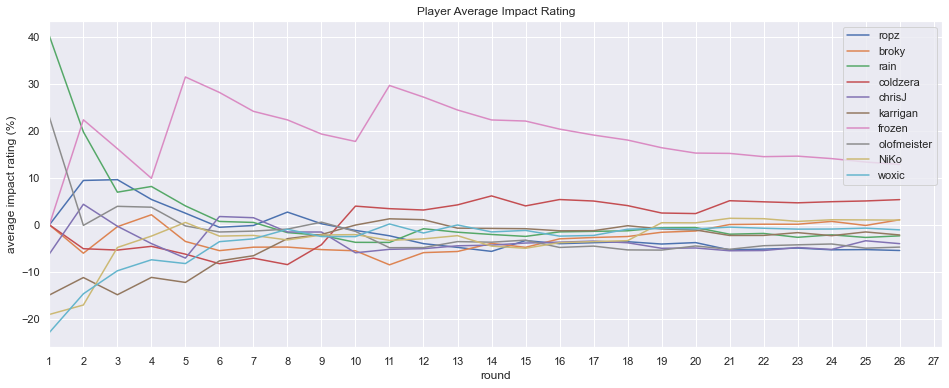

In [4]:
plt.figure(figsize=(16, 6))
for p in data['players']:
    rounds = [0]
    ratings = [0]
    for i, r in enumerate(p['roundRatings']):
        prev = ratings[-1] * rounds[-1]
        rounds.append(i+1)
        ratings.append((prev + r['totalRating'] * 100.0) / (i+1))
    plt.plot(rounds[1:], ratings[1:], label=p['name'])
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlim(1,)
plt.legend()

plt.title('Player Average Impact Rating')
plt.xlabel('round')
plt.ylabel('average impact rating (%)')

plt.show()

The previous plot shows that coldzera started the map slowly, only achieving a positive average Impact Rating at round 10, but performs well from this point onwards, ending the map with a very strong average Impact Rating. Meanwhile, frozen quickly accumulates high Impact Rating values, keeping his average very high for the whole duration of the map.

## Individual Player Results

Let's break down frozen's performance to understand why they achieved this map's highest average Impact Rating.

### Round-By-Round Impact Rating

The following plot shows frozen's rating in each of the 26 rounds played.

**Note:** unlike the previous plot of **average** Impact Ratings, this simply shows the frozen's rating in each individual round.

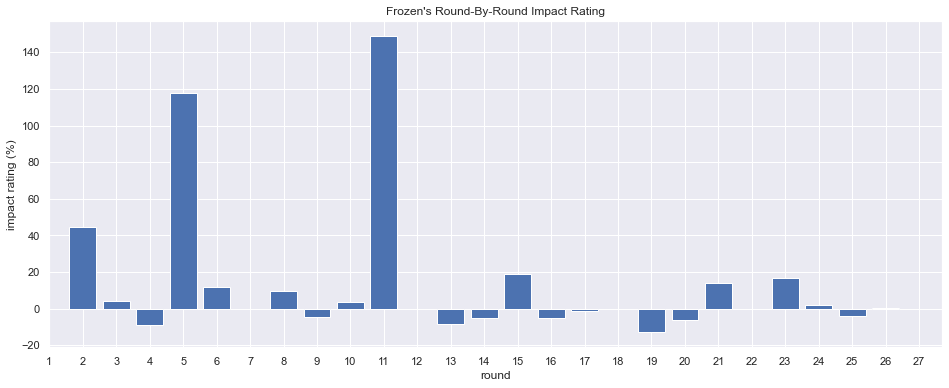

In [5]:
f_rounds = []
f_ratings = []
for p in data['players']:
    if p['name'] == 'frozen':
        for r in p['roundRatings']:
            f_rounds.append(r['round'])
            f_ratings.append(r['totalRating'] * 100.0)

plt.figure(figsize=(16, 6))
plt.bar(f_rounds, f_ratings)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title('Frozen\'s Round-By-Round Impact Rating')
plt.xlabel('round')
plt.xlim(1,)
plt.ylabel('impact rating (%)')
plt.show()

This shows that frozen ended very few rounds with a substantial negative Impact Rating, and played a key role in three rounds specifically: 2, 5, and 11.

### Single Round Breakdown

Let's look at **round 5** in detail, to see how frozen achieved such a high Impact Rating. The round in question can be viewed in the VOD below:

In [6]:
HTML('<center><iframe width="960" height="500" src="https://www.youtube.com/embed/9X7KpyXN5P0?start=674&end=815&version=3" frameborder="0" allowfullscreen></iframe></center>')

As you can see, Faze have full-bought into the round, whereas mousesports have chosen to full-eco, purchasing only a single flashbang. Mousesports end up winning the round after trading favourably in mid early, before Faze respond with entry kills leaving coldzera in a 1v2. He kills the first and plants the bomb, before frozen wins the 1v1 and defuses to win the round.

Let's first plot the **round outcome prediction probabilities**, to get an idea of how the model evaluated the round as it progressed. Annotations have been added to the plot to show the events that caused each change in prediction. The y-axis in this plot represents the predicted probability of a T-side round win.

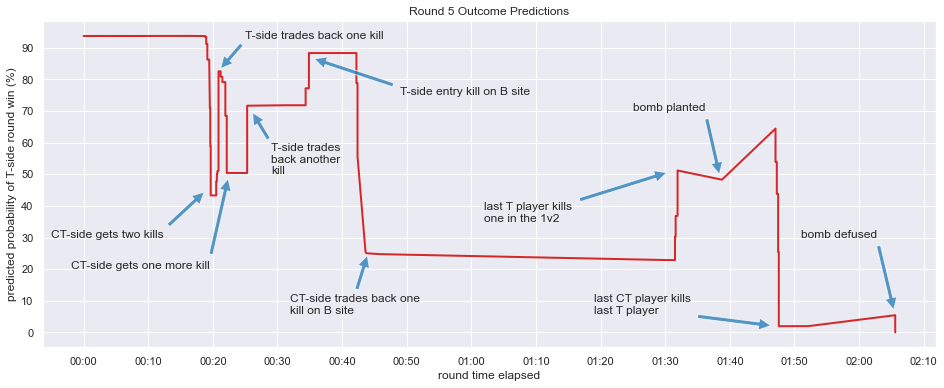

In [7]:
r_times = []
r_preds = []
round_start_tick = None

for rop in data['roundOutcomePredictions']:
    if rop['round'] == 5:
        if round_start_tick == None:
            round_start_tick = rop['tick']
        r_times.append((rop['tick'] - round_start_tick) / 128)
        r_preds.append(rop['outcomePrediction'] * 100.0)

plt.figure(figsize=(16, 6))
plt.plot(r_times, r_preds, lw=2, c='tab:red')

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))
formatter = ticker.FuncFormatter(lambda s, x: time.strftime('%M:%S', time.gmtime(s)))
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('round time elapsed')
plt.ylabel('predicted probability of T-side round win (%)')

plt.title('Round 5 Outcome Predictions')

# hardcode some annotations in
arrowprops = {'facecolor': 'tab:blue', 'shrink': 0.05, 'alpha': 0.75}
plt.gca().annotate('CT-side gets two kills', xy=(19, 45), xytext=(-5, 30), arrowprops=arrowprops)
plt.gca().annotate('T-side trades back one kill', xy=(21, 83), xytext=(25, 93), arrowprops=arrowprops)
plt.gca().annotate('CT-side gets one more kill', xy=(22.5, 50), xytext=(-2, 20), arrowprops=arrowprops)
plt.gca().annotate('T-side trades\nback another\nkill', xy=(26, 70), xytext=(29, 50), arrowprops=arrowprops)
plt.gca().annotate('T-side entry kill on B site', xy=(35, 87), xytext=(49, 75), arrowprops=arrowprops)
plt.gca().annotate('CT-side trades back one\nkill on B site', xy=(44, 25), xytext=(32, 6), arrowprops=arrowprops)
plt.gca().annotate('last T player kills\none in the 1v2', xy=(91, 51), xytext=(62, 35), arrowprops=arrowprops)
plt.gca().annotate('bomb planted', xy=(98.5, 49), xytext=(85, 70), arrowprops=arrowprops)
plt.gca().annotate('last CT player kills\nlast T player', xy=(107, 2), xytext=(79, 6), arrowprops=arrowprops)
plt.gca().annotate('bomb defused', xy=(125.5, 6), xytext=(111, 30), arrowprops=arrowprops)

plt.show()

As you can see, the initial buys from both teams has led the model to initially predict a very likely T-side round win (~95% probability). As the round progresses, the prediction changes dramatically, and ends with a certain CT round win as the final kill is found and the bomb is defused.

Now let's look at how frozen's individual Impact Rating changes as the round develops.

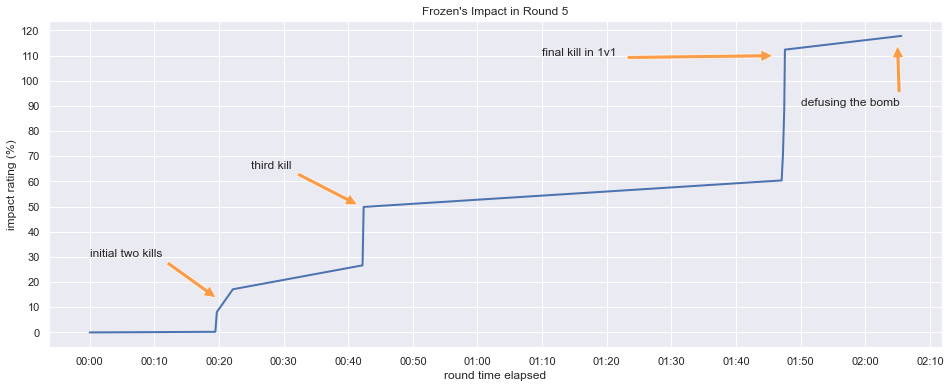

In [8]:
frozen_id = 76561198068422762
f_times = [0]
f_ratings = [0]
round_start_tick = None

for rop in data['roundOutcomePredictions']:
    if rop['round'] == 5 and round_start_tick == None:
        round_start_tick = rop['tick']

for rc in data['ratingChanges']:
    if rc['round'] == 5:
        if rc['player'] == frozen_id:
            f_times.append((rc['tick'] - round_start_tick) / 128)
            f_ratings.append(f_ratings[-1] + rc['change'] * 100.0)

plt.figure(figsize=(16, 6))
plt.plot(f_times, f_ratings, lw=2)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))
formatter = ticker.FuncFormatter(lambda s, x: time.strftime('%M:%S', time.gmtime(s)))
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('round time elapsed')
plt.ylabel('impact rating (%)')

plt.title('Frozen\'s Impact in Round 5')

# hardcode some annotations in
arrowprops = {'facecolor': 'tab:orange', 'shrink': 0.05, 'alpha': 0.75}
plt.gca().annotate('initial two kills', xy=(20, 13), xytext=(0, 30), arrowprops=arrowprops)
plt.gca().annotate('third kill', xy=(42, 50), xytext=(25, 65), arrowprops=arrowprops)
plt.gca().annotate('final kill in 1v1', xy=(107, 110), xytext=(70, 110), arrowprops=arrowprops)
plt.gca().annotate('defusing the bomb', xy=(125, 115), xytext=(110, 90), arrowprops=arrowprops)
plt.show()

As you can see, frozen was directly involved in multiple events during the round which swayed the round into his team's favour.

## Round Impact Viewer

Use the dropdown lists below to view the Impact Rating of any chosen player over any chosen round in the match.

In [10]:
player_ids = {}
for p in data['players']:
    player_ids[p['name']] = p['steamID']

out = widgets.Output()
player_dd = widgets.Dropdown(
    options=['frozen','woxic','chrisJ','ropz','karrigan','coldzera','broky','NiKo','olofmeister','rain'],
    value='frozen',
    description='Player:',
    disabled=False,
)

round_dd = widgets.Dropdown(
    options=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26],
    value=1,
    description='Round:',
    disabled=False,
)

button = widgets.Button(description='Plot')

def update(b):
    with out:
        clear_output()

        plt.figure(figsize=(16, 12))
        ax1 = plt.subplot(211)

        # show the round outcome predictions plot
        r_times = []
        r_preds = []
        round_start_tick = None

        for rop in data['roundOutcomePredictions']:
            if rop['round'] == round_dd.value:
                if round_start_tick == None:
                    round_start_tick = rop['tick']
                r_times.append((rop['tick'] - round_start_tick) / 128)
                r_preds.append(rop['outcomePrediction'] * 100.0)

        plt.plot(r_times, r_preds, lw=2, c='tab:red')

        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
        plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))
        formatter = ticker.FuncFormatter(lambda s, x: time.strftime('%M:%S', time.gmtime(s)))
        plt.gca().xaxis.set_major_formatter(formatter)

        plt.xlabel('round time elapsed')
        plt.ylabel('predicted probability of T-side round win (%)')

        plt.title('Round {} Outcome Predictions'.format(round_dd.value))
        
        ax2 = plt.subplot(212, sharex=ax1)
        plt.xlabel('round time elapsed')
        plt.ylabel('impact rating (%)')
        ax2.set_title('{}\'s Impact in Round {}'.format(player_dd.value, round_dd.value))
        
        p_times = [0]
        p_ratings = [0]       
        
        for rc in data['ratingChanges']:
            if rc['round'] == round_dd.value:
                if rc['player'] == player_ids[player_dd.value]:
                    p_times.append((rc['tick'] - round_start_tick) / 128)
                    p_ratings.append(p_ratings[-1] + rc['change'] * 100.0)
        
        if len(p_ratings) == 1:
            plt.show()
            print('{} did not have any impact in round {}'.format(player_dd.value, round_dd.value))
        else:
            plt.plot(p_times, p_ratings, lw=2)

            plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
            plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))
            plt.gca().xaxis.set_major_formatter(formatter)

            plt.show()

button.on_click(update)
display(widgets.VBox([
    widgets.HBox([player_dd, round_dd, button]),
    out
]))
update(None)